# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/data_obs.root')
file_sig = ROOT.RDataFrame('etau_tree', {'root_raw/et18_raw/ggH_bbtt*.root', 'root_raw/et18_raw/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/embedded.root')
file_TT = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/TT*.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

In [3]:
# 1b events
for i in range(len(files)):
    files[i] = files[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184 && bpt_deepcsv_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mytau+mymet).Pt(),(myele+mytau+mymet).Eta(),(myele+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
m_b1e = '(myele+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mytau)'
dR_b1e = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_e = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_tt = 'sqrt(pow(mytt.Pt()+mymet.Pt(),2)-pow(mytt.Px()+mymet.Px(),2)-pow(mytt.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt(),2)+pow(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mytau.Px())*x_zeta+(myele.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_tt', mT_tt)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
# 2018 e+tau trigger requirements
trigger32 = '(passEle32 && pt_1>33 && matchEle32_1 && filterEle32_1)'
trigger35 = '(passEle35 && pt_1>33 && matchEle35_1 && filterEle35_1)'
trigger2430 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS = '(passEle24HPSTau30 && matchEle24HPSTau30_1 && filterEle24HPSTau30_1 && matchEle24HPSTau30_2 && filterEle24HPSTau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_emb = '(matchEmbFilter_Ele24Tau30_1 && matchEmbFilter_Ele24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'

trigger_mc = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430HPS
trigger_emb = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430HPS_emb
trigger_obs_1 = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430
trigger_obs_2 = trigger32 + str(' or ') + trigger35 + str(' or ') + trigger2430HPS

for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byTightDeepVSe_2 && byVLooseDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files[1] = files[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files[1] = files[1].Filter('m_btt<250')#reject long tail (mostly wrongly reco b jet)

files[2] = files[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1 = files[0].Filter('run<317509').Filter(trigger_obs_1)
obs2 = files[0].Filter('run>=317509').Filter(trigger_obs_2)
files[1] = files[1].Filter(trigger_mc)
files[2] = files[2].Filter(trigger_emb)
files[3] = files[3].Filter(trigger_mc)

# QCD region
qcd1 = obs1.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2 = obs2.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')\
    .Filter('byLooseDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'pt_2', 'm_btt', 'm_b1e', 'm_b1tau',\
                'dR_tt', 'dR_b1e', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_e', 'mT_tau', 'mT_b1', 'mT_tt', 'norm_zeta', 'Dzeta',\
                'bpt_deepcsv_1', 'met', 'njets']


# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
    print(i)
qcd1 = pd.DataFrame(qcd1.AsNumpy(feature_list))
print('qcd1')
qcd2 = pd.DataFrame(qcd2.AsNumpy(feature_list))
print('qcd2')
qcd = [qcd1, qcd2]
qcd = pd.concat(qcd)
print('qcd')

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(1,len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

1
2
3
qcd1
qcd2
qcd
(6442, 21)
(56210, 21)
(606, 21)
(77828, 21)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 2394, random_state = 20)#Z->tautau
files[3] = files[3].sample(n = 606, random_state = 20)#ttbar
qcd = qcd.sample(n = 3607, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
#df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       pt_2       m_btt       m_b1e     m_b1tau     dR_tt  \
0      34.582008  21.651987   72.060436   88.482322   71.229010  0.405676   
1      35.931614  20.447090  110.463736   87.666347   66.677582  0.411864   
2      57.353619  20.589272  122.776053   73.588896   52.916211  0.452619   
3      44.358688  25.668238  126.908734   90.214851   59.431668  0.538028   
4      40.240074  28.912073   86.429431   63.005368   49.967078  0.420479   
...          ...        ...         ...         ...         ...       ...   
23238  86.064117  22.966139  252.683464  170.514745   29.993920  2.204670   
12919  48.263020  44.922279  261.712252   58.416240  114.484158  3.166742   
5747   47.210827  34.475735  115.012679   24.654424   65.297752  1.648711   
30213  72.798027  57.482388  291.454020   39.316892   93.571627  3.313866   
37433  34.140404  27.181665  321.443126   71.289461  194.855694  2.851327   

         dR_b1e  dR_b1tau   dR_b1tt       tt_pt  ...       

## Compare input feature distributions between sig and bkg

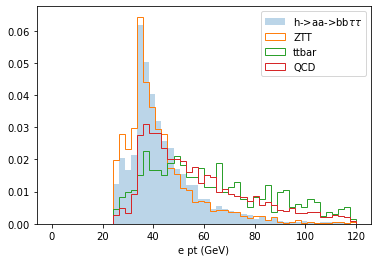

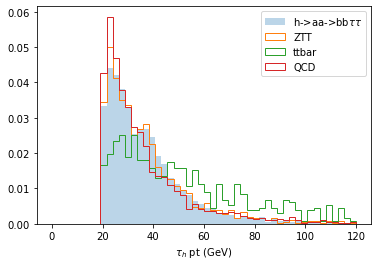

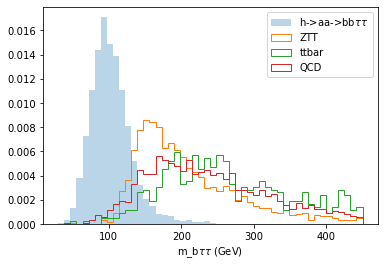

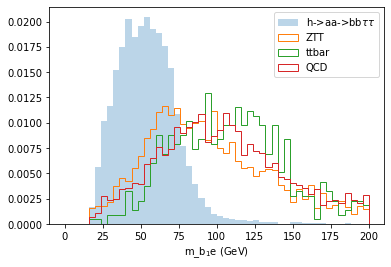

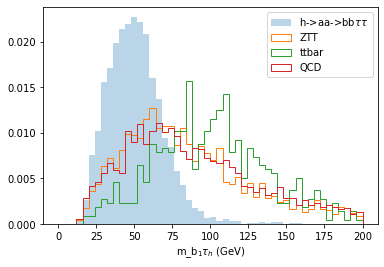

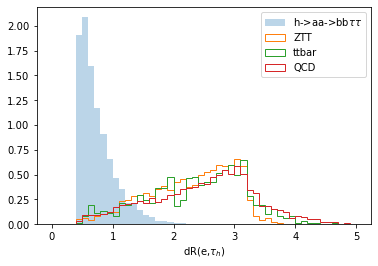

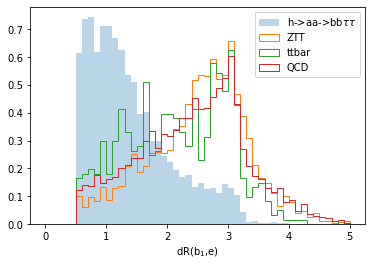

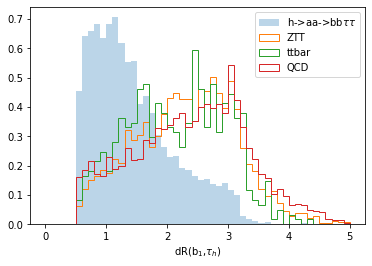

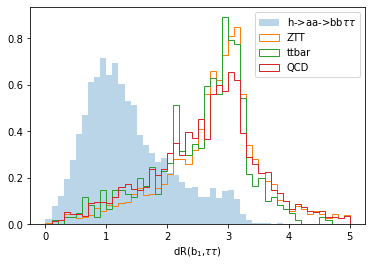

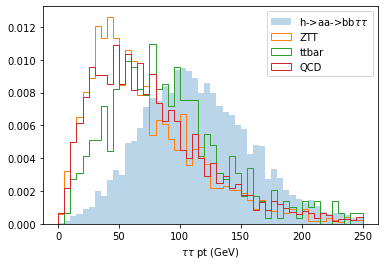

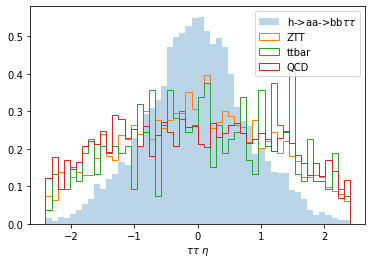

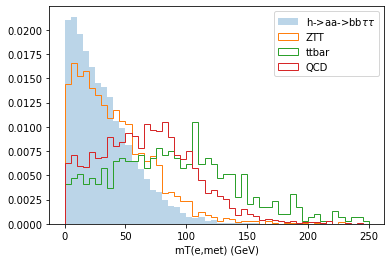

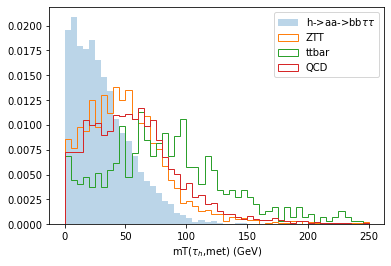

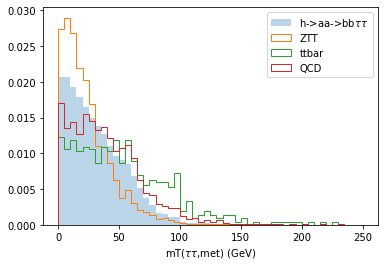

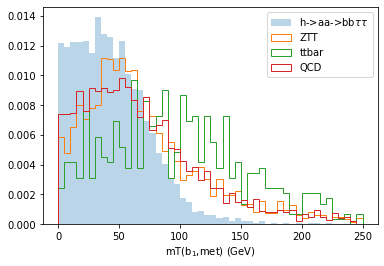

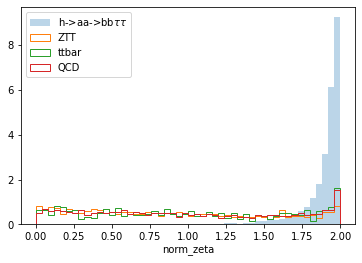

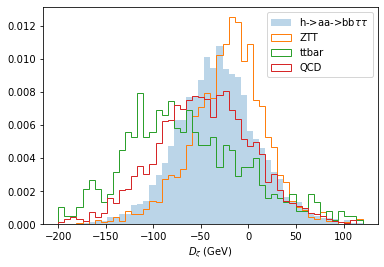

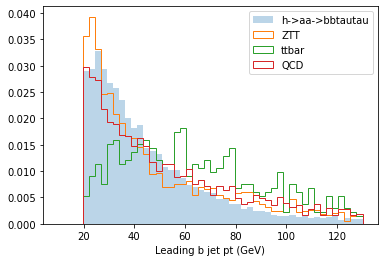

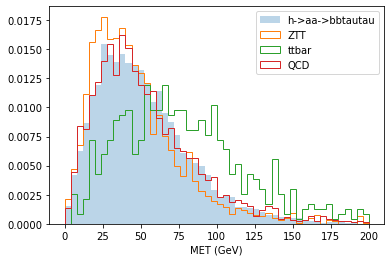

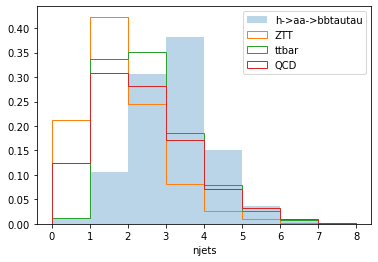

In [8]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau_h$ pt (GeV)')
pyplot.show()


pyplot.hist(files[1]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()


pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


pyplot.hist(files[1]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau\\tau$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'best')
pyplot.xlabel('norm_zeta')
pyplot.show()


pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (7829, 20)
Y_train.shape: (7829, 1)
X_val.shape: (2610, 20)
Y_val.shape: (2610, 1)
X_test.shape: (2610, 20)
Y_test.shape: (2610, 1)

Total number of sig/bkg examples: 6442/6607 (49.37%/50.63%)

Number of sig/bkg examples in each set:
train : 3894/3935 (49.7%/50.3%)
val   : 1292/1318 (49.5%/50.5%)
test  : 1256/1354 (48.1%/51.9%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-15 15:28:55.510969: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-15 15:28:55.512484: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 256)

Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 21s - loss: 0.7897 - accuracy: 0.535 - ETA: 2s - loss: 0.6854 - accuracy: 0.620 - ETA: 0s - loss: 0.6139 - accuracy: 0.68 - ETA: 0s - loss: 0.5457 - accuracy: 0.74 - 1s 144us/sample - loss: 0.4961 - accuracy: 0.7829 - val_loss: 0.2485 - val_accuracy: 0.9490
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.90 - ETA: 0s - loss: 0.2955 - accuracy: 0.91 - ETA: 0s - loss: 0.2683 - accuracy: 0.92 - ETA: 0s - loss: 0.2537 - accuracy: 0.92 - ETA: 0s - loss: 0.2371 - accuracy: 0.92 - 0s 38us/sample - loss: 0.2359 - accuracy: 0.9283 - val_loss: 0.1360 - val_accuracy: 0.9602


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7099 - accuracy: 0.582 - ETA: 1s - loss: 0.6534 - accuracy: 0.623 - ETA: 0s - loss: 0.6034 - accuracy: 0.66 - ETA: 0s - loss: 0.5588 - accuracy: 0.70 - 1s 112us/sample - loss: 0.5368 - accuracy: 0.7300 - val_loss: 0.3179 - val_accuracy: 0.9356
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.84 - ETA: 0s - loss: 0.3599 - accuracy: 0.87 - ETA: 0s - loss: 0.3439 - accuracy: 0.88 - ETA: 0s - loss: 0.3230 - accuracy: 0.89 - 0s 36us/sample - loss: 0.3121 - accuracy: 0.8948 - val_loss: 0.1816 - val_accuracy: 0.9494


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6409 - accuracy: 0.652 - ETA: 1s - loss: 0.5851 - accuracy: 0.712 - ETA: 0s - loss: 0.5257 - accuracy: 0.77 - ETA: 0s - loss: 0.4803 - accuracy: 0.80 - 1s 118us/sample - loss: 0.4497 - accuracy: 0.8256 - val_loss: 0.2539 - val_accuracy: 0.9383
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.87 - ETA: 0s - loss: 0.2754 - accuracy: 0.91 - ETA: 0s - loss: 0.2588 - accuracy: 0.91 - ETA: 0s - loss: 0.2405 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2306 - accuracy: 0.9223 - val_loss: 0.1451 - val_accuracy: 0.9529


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7251 - accuracy: 0.566 - ETA: 1s - loss: 0.6354 - accuracy: 0.654 - ETA: 0s - loss: 0.5521 - accuracy: 0.73 - ETA: 0s - loss: 0.4945 - accuracy: 0.78 - 1s 115us/sample - loss: 0.4514 - accuracy: 0.8148 - val_loss: 0.2189 - val_accuracy: 0.9552
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.91 - ETA: 0s - loss: 0.2315 - accuracy: 0.93 - ETA: 0s - loss: 0.2194 - accuracy: 0.93 - ETA: 0s - loss: 0.2057 - accuracy: 0.94 - 0s 36us/sample - loss: 0.2007 - accuracy: 0.9405 - val_loss: 0.1191 - val_accuracy: 0.9628


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7349 - accuracy: 0.507 - ETA: 1s - loss: 0.6707 - accuracy: 0.579 - ETA: 0s - loss: 0.6033 - accuracy: 0.66 - ETA: 0s - loss: 0.5589 - accuracy: 0.71 - ETA: 0s - loss: 0.5252 - accuracy: 0.74 - 1s 114us/sample - loss: 0.5218 - accuracy: 0.7434 - val_loss: 0.2988 - val_accuracy: 0.9192
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.90 - ETA: 0s - loss: 0.3273 - accuracy: 0.89 - ETA: 0s - loss: 0.2974 - accuracy: 0.90 - ETA: 0s - loss: 0.2804 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2657 - accuracy: 0.9170 - val_loss: 0.1587 - val_accuracy: 0.9529


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7023 - accuracy: 0.515 - ETA: 1s - loss: 0.6346 - accuracy: 0.585 - ETA: 0s - loss: 0.5733 - accuracy: 0.65 - ETA: 0s - loss: 0.5242 - accuracy: 0.70 - 1s 109us/sample - loss: 0.4996 - accuracy: 0.7339 - val_loss: 0.2878 - val_accuracy: 0.9598
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.88 - ETA: 0s - loss: 0.3111 - accuracy: 0.91 - ETA: 0s - loss: 0.2737 - accuracy: 0.92 - ETA: 0s - loss: 0.2592 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2482 - accuracy: 0.9320 - val_loss: 0.1433 - val_accuracy: 0.9667


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8581 - accuracy: 0.382 - ETA: 1s - loss: 0.7330 - accuracy: 0.536 - ETA: 0s - loss: 0.6622 - accuracy: 0.62 - ETA: 0s - loss: 0.6024 - accuracy: 0.68 - 1s 113us/sample - loss: 0.5635 - accuracy: 0.7238 - val_loss: 0.3196 - val_accuracy: 0.9379
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.89 - ETA: 0s - loss: 0.3254 - accuracy: 0.90 - ETA: 0s - loss: 0.3025 - accuracy: 0.91 - ETA: 0s - loss: 0.2818 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2693 - accuracy: 0.9216 - val_loss: 0.1567 - val_accuracy: 0.9548


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7211 - accuracy: 0.519 - ETA: 1s - loss: 0.6526 - accuracy: 0.607 - ETA: 0s - loss: 0.5836 - accuracy: 0.70 - ETA: 0s - loss: 0.5271 - accuracy: 0.76 - ETA: 0s - loss: 0.4803 - accuracy: 0.80 - 1s 116us/sample - loss: 0.4713 - accuracy: 0.8069 - val_loss: 0.2517 - val_accuracy: 0.9448
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.88 - ETA: 0s - loss: 0.2537 - accuracy: 0.93 - ETA: 0s - loss: 0.2356 - accuracy: 0.93 - ETA: 0s - loss: 0.2170 - accuracy: 0.94 - 0s 38us/sample - loss: 0.2077 - accuracy: 0.9412 - val_loss: 0.1348 - val_accuracy: 0.9605


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7326 - accuracy: 0.492 - ETA: 1s - loss: 0.6470 - accuracy: 0.622 - ETA: 0s - loss: 0.5852 - accuracy: 0.69 - ETA: 0s - loss: 0.5280 - accuracy: 0.74 - ETA: 0s - loss: 0.4828 - accuracy: 0.78 - 1s 114us/sample - loss: 0.4791 - accuracy: 0.7884 - val_loss: 0.2494 - val_accuracy: 0.9452
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.93 - ETA: 0s - loss: 0.2513 - accuracy: 0.93 - ETA: 0s - loss: 0.2372 - accuracy: 0.93 - ETA: 0s - loss: 0.2223 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2143 - accuracy: 0.9364 - val_loss: 0.1325 - val_accuracy: 0.9590


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7446 - accuracy: 0.476 - ETA: 1s - loss: 0.6158 - accuracy: 0.619 - ETA: 0s - loss: 0.5503 - accuracy: 0.69 - ETA: 0s - loss: 0.4903 - accuracy: 0.75 - 1s 115us/sample - loss: 0.4549 - accuracy: 0.7841 - val_loss: 0.2357 - val_accuracy: 0.9521
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.93 - ETA: 0s - loss: 0.2428 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.93 - ETA: 0s - loss: 0.2072 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1939 - accuracy: 0.9410 - val_loss: 0.1249 - val_accuracy: 0.9628


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7357 - accuracy: 0.457 - ETA: 1s - loss: 0.6403 - accuracy: 0.619 - ETA: 0s - loss: 0.5621 - accuracy: 0.71 - ETA: 0s - loss: 0.5016 - accuracy: 0.77 - 1s 113us/sample - loss: 0.4627 - accuracy: 0.8050 - val_loss: 0.2289 - val_accuracy: 0.9602
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.91 - ETA: 0s - loss: 0.2422 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.93 - ETA: 0s - loss: 0.1988 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1906 - accuracy: 0.9428 - val_loss: 0.1187 - val_accuracy: 0.9636


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6736 - accuracy: 0.617 - ETA: 1s - loss: 0.5431 - accuracy: 0.752 - ETA: 0s - loss: 0.4807 - accuracy: 0.80 - ETA: 0s - loss: 0.4242 - accuracy: 0.83 - 1s 117us/sample - loss: 0.3908 - accuracy: 0.8564 - val_loss: 0.1907 - val_accuracy: 0.9494
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.92 - ETA: 0s - loss: 0.1969 - accuracy: 0.93 - ETA: 0s - loss: 0.1859 - accuracy: 0.94 - ETA: 0s - loss: 0.1776 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1700 - accuracy: 0.9478 - val_loss: 0.1114 - val_accuracy: 0.9636


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7720 - accuracy: 0.546 - ETA: 1s - loss: 0.7561 - accuracy: 0.518 - ETA: 0s - loss: 0.6780 - accuracy: 0.58 - ETA: 0s - loss: 0.6198 - accuracy: 0.64 - 1s 114us/sample - loss: 0.5692 - accuracy: 0.6919 - val_loss: 0.3179 - val_accuracy: 0.9479
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.88 - ETA: 0s - loss: 0.3266 - accuracy: 0.90 - ETA: 0s - loss: 0.2970 - accuracy: 0.91 - ETA: 0s - loss: 0.2770 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2633 - accuracy: 0.9243 - val_loss: 0.1501 - val_accuracy: 0.9563


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 16s - loss: 0.7960 - accuracy: 0.421 - ETA: 1s - loss: 0.6948 - accuracy: 0.565 - ETA: 0s - loss: 0.6163 - accuracy: 0.66 - ETA: 0s - loss: 0.5516 - accuracy: 0.72 - 1s 119us/sample - loss: 0.5124 - accuracy: 0.7557 - val_loss: 0.2634 - val_accuracy: 0.9433
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.89 - ETA: 0s - loss: 0.2736 - accuracy: 0.91 - ETA: 0s - loss: 0.2483 - accuracy: 0.92 - ETA: 0s - loss: 0.2297 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2228 - accuracy: 0.9278 - val_loss: 0.1304 - val_accuracy: 0.9579


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8298 - accuracy: 0.453 - ETA: 1s - loss: 0.7241 - accuracy: 0.561 - ETA: 0s - loss: 0.6643 - accuracy: 0.61 - ETA: 0s - loss: 0.6130 - accuracy: 0.66 - 1s 111us/sample - loss: 0.5869 - accuracy: 0.6940 - val_loss: 0.3942 - val_accuracy: 0.8935
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.85 - ETA: 0s - loss: 0.3999 - accuracy: 0.85 - ETA: 0s - loss: 0.3703 - accuracy: 0.86 - ETA: 0s - loss: 0.3466 - accuracy: 0.87 - 0s 35us/sample - loss: 0.3359 - accuracy: 0.8839 - val_loss: 0.2091 - val_accuracy: 0.9414


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7346 - accuracy: 0.496 - ETA: 0s - loss: 0.6135 - accuracy: 0.636 - ETA: 0s - loss: 0.5310 - accuracy: 0.72 - ETA: 0s - loss: 0.4682 - accuracy: 0.77 - 1s 106us/sample - loss: 0.4649 - accuracy: 0.7811 - val_loss: 0.2363 - val_accuracy: 0.9544
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.90 - ETA: 0s - loss: 0.2515 - accuracy: 0.92 - ETA: 0s - loss: 0.2313 - accuracy: 0.93 - ETA: 0s - loss: 0.2206 - accuracy: 0.93 - 0s 31us/sample - loss: 0.2177 - accuracy: 0.9368 - val_loss: 0.1263 - val_accuracy: 0.9625


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7651 - accuracy: 0.507 - ETA: 1s - loss: 0.6661 - accuracy: 0.607 - ETA: 0s - loss: 0.5907 - accuracy: 0.68 - ETA: 0s - loss: 0.5229 - accuracy: 0.74 - 1s 111us/sample - loss: 0.4923 - accuracy: 0.7715 - val_loss: 0.2457 - val_accuracy: 0.9494
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.91 - ETA: 0s - loss: 0.2601 - accuracy: 0.92 - ETA: 0s - loss: 0.2385 - accuracy: 0.93 - ETA: 0s - loss: 0.2283 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2201 - accuracy: 0.9354 - val_loss: 0.1283 - val_accuracy: 0.9628


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7275 - accuracy: 0.507 - ETA: 1s - loss: 0.6523 - accuracy: 0.611 - ETA: 0s - loss: 0.5857 - accuracy: 0.70 - ETA: 0s - loss: 0.5395 - accuracy: 0.75 - ETA: 0s - loss: 0.4933 - accuracy: 0.79 - 1s 116us/sample - loss: 0.4782 - accuracy: 0.8037 - val_loss: 0.2541 - val_accuracy: 0.9567
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.92 - ETA: 0s - loss: 0.2605 - accuracy: 0.93 - ETA: 0s - loss: 0.2376 - accuracy: 0.94 - ETA: 0s - loss: 0.2187 - accuracy: 0.94 - 0s 37us/sample - loss: 0.2076 - accuracy: 0.9460 - val_loss: 0.1276 - val_accuracy: 0.9648


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6861 - accuracy: 0.585 - ETA: 1s - loss: 0.6042 - accuracy: 0.674 - ETA: 0s - loss: 0.5652 - accuracy: 0.73 - ETA: 0s - loss: 0.5245 - accuracy: 0.77 - 1s 112us/sample - loss: 0.4840 - accuracy: 0.8011 - val_loss: 0.2836 - val_accuracy: 0.9471
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.90 - ETA: 0s - loss: 0.3006 - accuracy: 0.90 - ETA: 0s - loss: 0.2744 - accuracy: 0.91 - ETA: 0s - loss: 0.2553 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2431 - accuracy: 0.9244 - val_loss: 0.1444 - val_accuracy: 0.9586


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7550 - accuracy: 0.410 - ETA: 1s - loss: 0.6481 - accuracy: 0.606 - ETA: 0s - loss: 0.5778 - accuracy: 0.70 - ETA: 0s - loss: 0.5139 - accuracy: 0.76 - 1s 111us/sample - loss: 0.4787 - accuracy: 0.7924 - val_loss: 0.2630 - val_accuracy: 0.9398
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.91 - ETA: 0s - loss: 0.2673 - accuracy: 0.92 - ETA: 0s - loss: 0.2482 - accuracy: 0.92 - ETA: 0s - loss: 0.2288 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2156 - accuracy: 0.9370 - val_loss: 0.1347 - val_accuracy: 0.9598


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7148 - accuracy: 0.511 - ETA: 1s - loss: 0.6689 - accuracy: 0.564 - ETA: 0s - loss: 0.6244 - accuracy: 0.62 - ETA: 0s - loss: 0.5816 - accuracy: 0.67 - 1s 109us/sample - loss: 0.5606 - accuracy: 0.7053 - val_loss: 0.3817 - val_accuracy: 0.9395
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4056 - accuracy: 0.87 - ETA: 0s - loss: 0.3886 - accuracy: 0.89 - ETA: 0s - loss: 0.3594 - accuracy: 0.90 - ETA: 0s - loss: 0.3287 - accuracy: 0.91 - 0s 34us/sample - loss: 0.3143 - accuracy: 0.9157 - val_loss: 0.1847 - val_accuracy: 0.9586


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8283 - accuracy: 0.390 - ETA: 1s - loss: 0.7655 - accuracy: 0.477 - ETA: 0s - loss: 0.7022 - accuracy: 0.55 - ETA: 0s - loss: 0.6412 - accuracy: 0.62 - 1s 111us/sample - loss: 0.6026 - accuracy: 0.6716 - val_loss: 0.3338 - val_accuracy: 0.9525
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.89 - ETA: 0s - loss: 0.3664 - accuracy: 0.90 - ETA: 0s - loss: 0.3316 - accuracy: 0.90 - ETA: 0s - loss: 0.3018 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2868 - accuracy: 0.9184 - val_loss: 0.1479 - val_accuracy: 0.9644


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 16s - loss: 0.7881 - accuracy: 0.480 - ETA: 1s - loss: 0.6868 - accuracy: 0.576 - ETA: 0s - loss: 0.6289 - accuracy: 0.63 - ETA: 0s - loss: 0.5744 - accuracy: 0.69 - 1s 115us/sample - loss: 0.5551 - accuracy: 0.7143 - val_loss: 0.3402 - val_accuracy: 0.9234
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.85 - ETA: 0s - loss: 0.3590 - accuracy: 0.88 - ETA: 0s - loss: 0.3391 - accuracy: 0.89 - ETA: 0s - loss: 0.3155 - accuracy: 0.89 - 0s 34us/sample - loss: 0.3048 - accuracy: 0.9036 - val_loss: 0.1786 - val_accuracy: 0.9456


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.9014 - accuracy: 0.429 - ETA: 1s - loss: 0.8103 - accuracy: 0.489 - ETA: 0s - loss: 0.7450 - accuracy: 0.54 - ETA: 0s - loss: 0.6850 - accuracy: 0.60 - 1s 109us/sample - loss: 0.6578 - accuracy: 0.6263 - val_loss: 0.4115 - val_accuracy: 0.9218
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.83 - ETA: 0s - loss: 0.4404 - accuracy: 0.82 - ETA: 0s - loss: 0.4100 - accuracy: 0.84 - ETA: 0s - loss: 0.3826 - accuracy: 0.86 - 0s 33us/sample - loss: 0.3702 - accuracy: 0.8670 - val_loss: 0.2070 - val_accuracy: 0.9506


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8496 - accuracy: 0.339 - ETA: 1s - loss: 0.7671 - accuracy: 0.434 - ETA: 0s - loss: 0.7136 - accuracy: 0.51 - ETA: 0s - loss: 0.6535 - accuracy: 0.59 - 1s 111us/sample - loss: 0.6140 - accuracy: 0.6553 - val_loss: 0.4012 - val_accuracy: 0.9130
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.85 - ETA: 0s - loss: 0.3980 - accuracy: 0.89 - ETA: 0s - loss: 0.3658 - accuracy: 0.89 - ETA: 0s - loss: 0.3352 - accuracy: 0.90 - 0s 36us/sample - loss: 0.3183 - accuracy: 0.9121 - val_loss: 0.1947 - val_accuracy: 0.9475


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7971 - accuracy: 0.488 - ETA: 1s - loss: 0.6558 - accuracy: 0.593 - ETA: 0s - loss: 0.6019 - accuracy: 0.65 - ETA: 0s - loss: 0.5402 - accuracy: 0.72 - 1s 110us/sample - loss: 0.4970 - accuracy: 0.7643 - val_loss: 0.2682 - val_accuracy: 0.9506
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.89 - ETA: 0s - loss: 0.2802 - accuracy: 0.92 - ETA: 0s - loss: 0.2531 - accuracy: 0.93 - ETA: 0s - loss: 0.2367 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2273 - accuracy: 0.9343 - val_loss: 0.1289 - val_accuracy: 0.9628


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7997 - accuracy: 0.492 - ETA: 1s - loss: 0.7358 - accuracy: 0.539 - ETA: 0s - loss: 0.6699 - accuracy: 0.60 - ETA: 0s - loss: 0.6181 - accuracy: 0.65 - 1s 112us/sample - loss: 0.5797 - accuracy: 0.6978 - val_loss: 0.3579 - val_accuracy: 0.9130
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.84 - ETA: 0s - loss: 0.3775 - accuracy: 0.86 - ETA: 0s - loss: 0.3594 - accuracy: 0.87 - ETA: 0s - loss: 0.3302 - accuracy: 0.88 - 0s 37us/sample - loss: 0.3181 - accuracy: 0.8944 - val_loss: 0.1849 - val_accuracy: 0.9452


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7264 - accuracy: 0.531 - ETA: 1s - loss: 0.6289 - accuracy: 0.631 - ETA: 0s - loss: 0.5570 - accuracy: 0.71 - ETA: 0s - loss: 0.5060 - accuracy: 0.76 - 1s 112us/sample - loss: 0.4665 - accuracy: 0.7945 - val_loss: 0.2471 - val_accuracy: 0.9383
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.94 - ETA: 0s - loss: 0.2565 - accuracy: 0.92 - ETA: 0s - loss: 0.2434 - accuracy: 0.92 - ETA: 0s - loss: 0.2310 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2214 - accuracy: 0.9300 - val_loss: 0.1408 - val_accuracy: 0.9510


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7143 - accuracy: 0.535 - ETA: 1s - loss: 0.6177 - accuracy: 0.668 - ETA: 0s - loss: 0.5520 - accuracy: 0.73 - ETA: 0s - loss: 0.4983 - accuracy: 0.78 - 1s 110us/sample - loss: 0.4651 - accuracy: 0.8101 - val_loss: 0.2504 - val_accuracy: 0.9517
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.89 - ETA: 0s - loss: 0.2652 - accuracy: 0.92 - ETA: 0s - loss: 0.2411 - accuracy: 0.93 - ETA: 0s - loss: 0.2195 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2115 - accuracy: 0.9377 - val_loss: 0.1292 - val_accuracy: 0.9617


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7626 - accuracy: 0.519 - ETA: 1s - loss: 0.6274 - accuracy: 0.628 - ETA: 0s - loss: 0.5446 - accuracy: 0.72 - ETA: 0s - loss: 0.4843 - accuracy: 0.77 - 1s 111us/sample - loss: 0.4479 - accuracy: 0.8001 - val_loss: 0.2308 - val_accuracy: 0.9322
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.94 - ETA: 0s - loss: 0.2350 - accuracy: 0.92 - ETA: 0s - loss: 0.2174 - accuracy: 0.93 - ETA: 0s - loss: 0.2026 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1991 - accuracy: 0.9359 - val_loss: 0.1317 - val_accuracy: 0.9567


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7287 - accuracy: 0.535 - ETA: 1s - loss: 0.6333 - accuracy: 0.616 - ETA: 0s - loss: 0.5733 - accuracy: 0.68 - ETA: 0s - loss: 0.5241 - accuracy: 0.73 - 1s 111us/sample - loss: 0.4944 - accuracy: 0.7638 - val_loss: 0.2766 - val_accuracy: 0.9414
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.90 - ETA: 0s - loss: 0.3051 - accuracy: 0.91 - ETA: 0s - loss: 0.2776 - accuracy: 0.92 - ETA: 0s - loss: 0.2593 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2492 - accuracy: 0.9266 - val_loss: 0.1465 - val_accuracy: 0.9556


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8814 - accuracy: 0.457 - ETA: 1s - loss: 0.7573 - accuracy: 0.492 - ETA: 0s - loss: 0.6677 - accuracy: 0.58 - ETA: 0s - loss: 0.5989 - accuracy: 0.66 - 1s 111us/sample - loss: 0.5608 - accuracy: 0.7005 - val_loss: 0.3025 - val_accuracy: 0.9464
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.91 - ETA: 0s - loss: 0.3204 - accuracy: 0.91 - ETA: 0s - loss: 0.2932 - accuracy: 0.91 - ETA: 0s - loss: 0.2691 - accuracy: 0.92 - ETA: 0s - loss: 0.2529 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2515 - accuracy: 0.9299 - val_loss: 0.1484 - val_accuracy: 0.9575


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8768 - accuracy: 0.406 - ETA: 1s - loss: 0.7853 - accuracy: 0.491 - ETA: 0s - loss: 0.7095 - accuracy: 0.56 - ETA: 0s - loss: 0.6525 - accuracy: 0.63 - ETA: 0s - loss: 0.5962 - accuracy: 0.68 - 1s 113us/sample - loss: 0.5922 - accuracy: 0.6911 - val_loss: 0.3362 - val_accuracy: 0.9138
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.86 - ETA: 0s - loss: 0.3434 - accuracy: 0.89 - ETA: 0s - loss: 0.3174 - accuracy: 0.90 - ETA: 0s - loss: 0.3009 - accuracy: 0.90 - 0s 36us/sample - loss: 0.2883 - accuracy: 0.9107 - val_loss: 0.1709 - val_accuracy: 0.9525


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8155 - accuracy: 0.507 - ETA: 1s - loss: 0.7369 - accuracy: 0.554 - ETA: 0s - loss: 0.6738 - accuracy: 0.61 - ETA: 0s - loss: 0.6167 - accuracy: 0.67 - 1s 111us/sample - loss: 0.5831 - accuracy: 0.7015 - val_loss: 0.3217 - val_accuracy: 0.9379
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.83 - ETA: 0s - loss: 0.3575 - accuracy: 0.88 - ETA: 0s - loss: 0.3406 - accuracy: 0.89 - ETA: 0s - loss: 0.3191 - accuracy: 0.89 - 0s 36us/sample - loss: 0.2995 - accuracy: 0.9043 - val_loss: 0.1615 - val_accuracy: 0.9533


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7705 - accuracy: 0.488 - ETA: 1s - loss: 0.6435 - accuracy: 0.640 - ETA: 0s - loss: 0.5814 - accuracy: 0.70 - ETA: 0s - loss: 0.5196 - accuracy: 0.76 - 1s 109us/sample - loss: 0.5001 - accuracy: 0.7766 - val_loss: 0.2772 - val_accuracy: 0.9456
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.92 - ETA: 0s - loss: 0.2832 - accuracy: 0.92 - ETA: 0s - loss: 0.2574 - accuracy: 0.92 - ETA: 0s - loss: 0.2440 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2342 - accuracy: 0.9329 - val_loss: 0.1408 - val_accuracy: 0.9567


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8852 - accuracy: 0.437 - ETA: 1s - loss: 0.7298 - accuracy: 0.545 - ETA: 0s - loss: 0.6521 - accuracy: 0.63 - ETA: 0s - loss: 0.5843 - accuracy: 0.70 - 1s 112us/sample - loss: 0.5368 - accuracy: 0.7407 - val_loss: 0.2888 - val_accuracy: 0.9418
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.90 - ETA: 0s - loss: 0.2997 - accuracy: 0.91 - ETA: 0s - loss: 0.2713 - accuracy: 0.92 - ETA: 0s - loss: 0.2549 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2458 - accuracy: 0.9277 - val_loss: 0.1521 - val_accuracy: 0.9521


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.9461 - accuracy: 0.539 - ETA: 1s - loss: 0.8073 - accuracy: 0.536 - ETA: 0s - loss: 0.7148 - accuracy: 0.58 - ETA: 0s - loss: 0.6400 - accuracy: 0.64 - 1s 110us/sample - loss: 0.5989 - accuracy: 0.6775 - val_loss: 0.3021 - val_accuracy: 0.9249
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.86 - ETA: 0s - loss: 0.3530 - accuracy: 0.86 - ETA: 0s - loss: 0.3272 - accuracy: 0.88 - ETA: 0s - loss: 0.3047 - accuracy: 0.89 - 0s 34us/sample - loss: 0.2933 - accuracy: 0.9023 - val_loss: 0.1683 - val_accuracy: 0.9517


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7599 - accuracy: 0.562 - ETA: 1s - loss: 0.6598 - accuracy: 0.637 - ETA: 0s - loss: 0.5828 - accuracy: 0.71 - ETA: 0s - loss: 0.5176 - accuracy: 0.76 - 1s 111us/sample - loss: 0.4806 - accuracy: 0.7958 - val_loss: 0.2559 - val_accuracy: 0.9433
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.92 - ETA: 0s - loss: 0.2578 - accuracy: 0.92 - ETA: 0s - loss: 0.2357 - accuracy: 0.93 - ETA: 0s - loss: 0.2200 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2119 - accuracy: 0.9372 - val_loss: 0.1336 - val_accuracy: 0.9651


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6832 - accuracy: 0.597 - ETA: 1s - loss: 0.5756 - accuracy: 0.740 - ETA: 0s - loss: 0.4912 - accuracy: 0.81 - ETA: 0s - loss: 0.4200 - accuracy: 0.85 - 1s 107us/sample - loss: 0.4049 - accuracy: 0.8598 - val_loss: 0.1933 - val_accuracy: 0.9513
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.97 - ETA: 0s - loss: 0.1926 - accuracy: 0.94 - ETA: 0s - loss: 0.1718 - accuracy: 0.94 - ETA: 0s - loss: 0.1697 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1687 - accuracy: 0.9483 - val_loss: 0.1156 - val_accuracy: 0.9625


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7321 - accuracy: 0.523 - ETA: 1s - loss: 0.6139 - accuracy: 0.644 - ETA: 0s - loss: 0.5361 - accuracy: 0.72 - ETA: 0s - loss: 0.4806 - accuracy: 0.77 - 1s 110us/sample - loss: 0.4502 - accuracy: 0.7958 - val_loss: 0.2177 - val_accuracy: 0.9402
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.88 - ETA: 0s - loss: 0.2491 - accuracy: 0.91 - ETA: 0s - loss: 0.2266 - accuracy: 0.92 - ETA: 0s - loss: 0.2131 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2045 - accuracy: 0.9336 - val_loss: 0.1213 - val_accuracy: 0.9575


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6768 - accuracy: 0.511 - ETA: 1s - loss: 0.5801 - accuracy: 0.675 - ETA: 0s - loss: 0.5148 - accuracy: 0.75 - ETA: 0s - loss: 0.4587 - accuracy: 0.80 - 1s 109us/sample - loss: 0.4265 - accuracy: 0.8308 - val_loss: 0.2210 - val_accuracy: 0.9571
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.94 - ETA: 0s - loss: 0.2279 - accuracy: 0.93 - ETA: 0s - loss: 0.2056 - accuracy: 0.93 - ETA: 0s - loss: 0.1910 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1878 - accuracy: 0.9441 - val_loss: 0.1221 - val_accuracy: 0.9640


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 1.0237 - accuracy: 0.328 - ETA: 1s - loss: 0.8263 - accuracy: 0.477 - ETA: 0s - loss: 0.7119 - accuracy: 0.58 - ETA: 0s - loss: 0.6244 - accuracy: 0.65 - 1s 108us/sample - loss: 0.6040 - accuracy: 0.6744 - val_loss: 0.2877 - val_accuracy: 0.9375
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.86 - ETA: 0s - loss: 0.3238 - accuracy: 0.88 - ETA: 0s - loss: 0.2932 - accuracy: 0.90 - ETA: 0s - loss: 0.2696 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2652 - accuracy: 0.9148 - val_loss: 0.1453 - val_accuracy: 0.9556


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7977 - accuracy: 0.398 - ETA: 1s - loss: 0.7356 - accuracy: 0.484 - ETA: 0s - loss: 0.6448 - accuracy: 0.60 - ETA: 0s - loss: 0.5878 - accuracy: 0.67 - 1s 108us/sample - loss: 0.5626 - accuracy: 0.6972 - val_loss: 0.3154 - val_accuracy: 0.9475
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.87 - ETA: 0s - loss: 0.3118 - accuracy: 0.90 - ETA: 0s - loss: 0.2834 - accuracy: 0.91 - ETA: 0s - loss: 0.2654 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2558 - accuracy: 0.9225 - val_loss: 0.1479 - val_accuracy: 0.9571


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7197 - accuracy: 0.550 - ETA: 1s - loss: 0.6164 - accuracy: 0.669 - ETA: 0s - loss: 0.5512 - accuracy: 0.73 - ETA: 0s - loss: 0.4914 - accuracy: 0.78 - 1s 107us/sample - loss: 0.4741 - accuracy: 0.7927 - val_loss: 0.2416 - val_accuracy: 0.9556
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.91 - ETA: 0s - loss: 0.2720 - accuracy: 0.91 - ETA: 0s - loss: 0.2443 - accuracy: 0.92 - ETA: 0s - loss: 0.2262 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2221 - accuracy: 0.9299 - val_loss: 0.1276 - val_accuracy: 0.9613


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7000 - accuracy: 0.558 - ETA: 1s - loss: 0.6168 - accuracy: 0.645 - ETA: 0s - loss: 0.5571 - accuracy: 0.71 - ETA: 0s - loss: 0.5062 - accuracy: 0.76 - 1s 109us/sample - loss: 0.4715 - accuracy: 0.7955 - val_loss: 0.2557 - val_accuracy: 0.9502
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.89 - ETA: 0s - loss: 0.2733 - accuracy: 0.91 - ETA: 0s - loss: 0.2445 - accuracy: 0.92 - ETA: 0s - loss: 0.2285 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2197 - accuracy: 0.9338 - val_loss: 0.1277 - val_accuracy: 0.9651


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8843 - accuracy: 0.453 - ETA: 1s - loss: 0.7708 - accuracy: 0.518 - ETA: 0s - loss: 0.6816 - accuracy: 0.60 - ETA: 0s - loss: 0.6084 - accuracy: 0.67 - 1s 111us/sample - loss: 0.5669 - accuracy: 0.7168 - val_loss: 0.2986 - val_accuracy: 0.9291
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.93 - ETA: 0s - loss: 0.3185 - accuracy: 0.90 - ETA: 0s - loss: 0.3002 - accuracy: 0.90 - ETA: 0s - loss: 0.2752 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2576 - accuracy: 0.9217 - val_loss: 0.1504 - val_accuracy: 0.9586


Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7615 - accuracy: 0.500 - ETA: 1s - loss: 0.6562 - accuracy: 0.604 - ETA: 0s - loss: 0.5781 - accuracy: 0.69 - ETA: 0s - loss: 0.5080 - accuracy: 0.76 - 1s 109us/sample - loss: 0.4787 - accuracy: 0.7864 - val_loss: 0.2376 - val_accuracy: 0.9533
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.92 - ETA: 0s - loss: 0.2536 - accuracy: 0.93 - ETA: 0s - loss: 0.2281 - accuracy: 0.93 - ETA: 0s - loss: 0.2107 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1996 - accuracy: 0.9434 - val_loss: 0.1200 - val_accuracy: 0.9644
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.90 - ETA: 0s - loss: 0.1516 - accuracy: 0.94 - ETA: 0s - loss: 0.1403 - accuracy: 0.95 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1383 - accuracy: 0.9524 - val_loss: 0.0993 - val_accuracy: 0.9663
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7579 - accuracy: 0.441 - ETA: 1s - loss: 0.6839 - accuracy: 0.589 - ETA: 0s - loss: 0.6172 - accuracy: 0.67 - ETA: 0s - loss: 0.5593 - accuracy: 0.73 - 1s 110us/sample - loss: 0.5233 - accuracy: 0.7680 - val_loss: 0.2897 - val_accuracy: 0.9406
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.91 - ETA: 0s - loss: 0.2875 - accuracy: 0.92 - ETA: 0s - loss: 0.2574 - accuracy: 0.93 - ETA: 0s - loss: 0.2403 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2335 - accuracy: 0.9332 - val_loss: 0.1354 - val_accuracy: 0.9548
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.96 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - ETA: 0s - loss: 0.1495 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1504 - accuracy: 0.9504 - val_loss: 0.1021 - val_accuracy: 0.9674
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.6802 - accuracy: 0.582 - ETA: 1s - loss: 0.6065 - accuracy: 0.586 - ETA: 0s - loss: 0.5341 - accuracy: 0.68 - ETA: 0s - loss: 0.4779 - accuracy: 0.75 - 1s 111us/sample - loss: 0.4427 - accuracy: 0.7841 - val_loss: 0.2275 - val_accuracy: 0.9556
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.92 - ETA: 0s - loss: 0.2293 - accuracy: 0.94 - ETA: 0s - loss: 0.2175 - accuracy: 0.94 - ETA: 0s - loss: 0.2048 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1941 - accuracy: 0.9466 - val_loss: 0.1218 - val_accuracy: 0.9625
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.95 - ETA: 0s - loss: 0.1477 - accuracy: 0.95 - ETA: 0s - loss: 0.1400 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1335 - accuracy: 0.9563 - val_loss: 0.1002 - val_accuracy: 0.9659
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7485 - accuracy: 0.433 - ETA: 1s - loss: 0.6426 - accuracy: 0.634 - ETA: 0s - loss: 0.5637 - accuracy: 0.74 - ETA: 0s - loss: 0.4985 - accuracy: 0.79 - 1s 107us/sample - loss: 0.4824 - accuracy: 0.8092 - val_loss: 0.2559 - val_accuracy: 0.9437
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.94 - ETA: 0s - loss: 0.2365 - accuracy: 0.94 - ETA: 0s - loss: 0.2114 - accuracy: 0.94 - ETA: 0s - loss: 0.1944 - accuracy: 0.94 - 0s 32us/sample - loss: 0.1936 - accuracy: 0.9457 - val_loss: 0.1265 - val_accuracy: 0.9582
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.94 - ETA: 0s - loss: 0.1372 - accuracy: 0.95 - ETA: 0s - loss: 0.1322 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1280 - accuracy: 0.9575 - val_loss: 0.0998 - val_accuracy: 0.9686
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.9472 - accuracy: 0.441 - ETA: 1s - loss: 0.7681 - accuracy: 0.563 - ETA: 0s - loss: 0.6400 - accuracy: 0.68 - ETA: 0s - loss: 0.5525 - accuracy: 0.75 - 1s 108us/sample - loss: 0.5313 - accuracy: 0.7664 - val_loss: 0.2590 - val_accuracy: 0.9402
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.93 - ETA: 0s - loss: 0.2545 - accuracy: 0.92 - ETA: 0s - loss: 0.2266 - accuracy: 0.93 - ETA: 0s - loss: 0.2073 - accuracy: 0.93 - 0s 33us/sample - loss: 0.2020 - accuracy: 0.9402 - val_loss: 0.1323 - val_accuracy: 0.9602
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.95 - ETA: 0s - loss: 0.1489 - accuracy: 0.95 - ETA: 0s - loss: 0.1437 - accuracy: 0.95 - ETA: 0s - loss: 0.1388 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1388 - accuracy: 0.9550 - val_loss: 0.1018 - val_accuracy: 0.9670


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.8536 - accuracy: 0.523 - ETA: 1s - loss: 0.7301 - accuracy: 0.547 - ETA: 0s - loss: 0.6497 - accuracy: 0.61 - ETA: 0s - loss: 0.5819 - accuracy: 0.68 - 1s 110us/sample - loss: 0.5412 - accuracy: 0.7238 - val_loss: 0.3010 - val_accuracy: 0.9387
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.90 - ETA: 0s - loss: 0.3034 - accuracy: 0.92 - ETA: 0s - loss: 0.2685 - accuracy: 0.92 - ETA: 0s - loss: 0.2439 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2300 - accuracy: 0.9375 - val_loss: 0.1401 - val_accuracy: 0.9571
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1656 - accuracy: 0.94 - ETA: 0s - loss: 0.1527 - accuracy: 0.95 - ETA: 0s - loss: 0.1458 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1444 - accuracy: 0.9525 - val_loss: 0.1071 - val_accuracy: 0.9651


Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7402 - accuracy: 0.613 - ETA: 1s - loss: 0.6724 - accuracy: 0.642 - ETA: 0s - loss: 0.5965 - accuracy: 0.70 - ETA: 0s - loss: 0.5450 - accuracy: 0.74 - 1s 108us/sample - loss: 0.5241 - accuracy: 0.7614 - val_loss: 0.2921 - val_accuracy: 0.9291
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.87 - ETA: 0s - loss: 0.3291 - accuracy: 0.88 - ETA: 0s - loss: 0.3019 - accuracy: 0.89 - ETA: 0s - loss: 0.2813 - accuracy: 0.90 - 0s 34us/sample - loss: 0.2729 - accuracy: 0.9102 - val_loss: 0.1557 - val_accuracy: 0.9540
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.95 - ETA: 0s - loss: 0.1919 - accuracy: 0.93 - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - ETA: 0s - loss: 0.1872 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1832 - accuracy: 0.9368 - val_loss: 0.1145 - val_accuracy: 0.9632
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7756 - accuracy: 0.453 - ETA: 1s - loss: 0.7053 - accuracy: 0.539 - ETA: 0s - loss: 0.6268 - accuracy: 0.64 - ETA: 0s - loss: 0.5690 - accuracy: 0.70 - 1s 112us/sample - loss: 0.5251 - accuracy: 0.7461 - val_loss: 0.2758 - val_accuracy: 0.9452
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.90 - ETA: 0s - loss: 0.2879 - accuracy: 0.91 - ETA: 0s - loss: 0.2646 - accuracy: 0.91 - ETA: 0s - loss: 0.2445 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2308 - accuracy: 0.9299 - val_loss: 0.1348 - val_accuracy: 0.9594
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.97 - ETA: 0s - loss: 0.1565 - accuracy: 0.95 - ETA: 0s - loss: 0.1551 - accuracy: 0.95 - ETA: 0s - loss: 0.1561 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1533 - accuracy: 0.9507 - val_loss: 0.1069 - val_accuracy: 0.9648
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6472 - accuracy: 0.648 - ETA: 1s - loss: 0.5987 - accuracy: 0.699 - ETA: 0s - loss: 0.5488 - accuracy: 0.75 - ETA: 0s - loss: 0.5019 - accuracy: 0.79 - 1s 111us/sample - loss: 0.4725 - accuracy: 0.8125 - val_loss: 0.2634 - val_accuracy: 0.9552
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.87 - ETA: 0s - loss: 0.3020 - accuracy: 0.90 - ETA: 0s - loss: 0.2829 - accuracy: 0.91 - ETA: 0s - loss: 0.2619 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2486 - accuracy: 0.9253 - val_loss: 0.1368 - val_accuracy: 0.9613
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2089 - accuracy: 0.92 - ETA: 0s - loss: 0.1751 - accuracy: 0.94 - ETA: 0s - loss: 0.1659 - accuracy: 0.94 - ETA: 0s - loss: 0.1655 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1631 - accuracy: 0.9480 - val_loss: 0.1056 - val_accuracy: 0.9659
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6838 - accuracy: 0.527 - ETA: 1s - loss: 0.6368 - accuracy: 0.602 - ETA: 0s - loss: 0.5926 - accuracy: 0.66 - ETA: 0s - loss: 0.5454 - accuracy: 0.72 - 1s 112us/sample - loss: 0.5089 - accuracy: 0.7582 - val_loss: 0.3089 - val_accuracy: 0.9475
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.91 - ETA: 0s - loss: 0.3152 - accuracy: 0.91 - ETA: 0s - loss: 0.2964 - accuracy: 0.91 - ETA: 0s - loss: 0.2780 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2670 - accuracy: 0.9231 - val_loss: 0.1523 - val_accuracy: 0.9617
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.93 - ETA: 0s - loss: 0.1893 - accuracy: 0.94 - ETA: 0s - loss: 0.1815 - accuracy: 0.94 - ETA: 0s - loss: 0.1738 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1740 - accuracy: 0.9493 - val_loss: 0.1115 - val_accuracy: 0.9648
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6959 - accuracy: 0.507 - ETA: 1s - loss: 0.6515 - accuracy: 0.570 - ETA: 0s - loss: 0.6070 - accuracy: 0.63 - ETA: 0s - loss: 0.5661 - accuracy: 0.69 - 1s 108us/sample - loss: 0.5550 - accuracy: 0.7081 - val_loss: 0.3873 - val_accuracy: 0.9195
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.83 - ETA: 0s - loss: 0.4011 - accuracy: 0.86 - ETA: 0s - loss: 0.3731 - accuracy: 0.87 - ETA: 0s - loss: 0.3491 - accuracy: 0.88 - 0s 32us/sample - loss: 0.3443 - accuracy: 0.8898 - val_loss: 0.2197 - val_accuracy: 0.9421
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.88 - ETA: 0s - loss: 0.2519 - accuracy: 0.91 - ETA: 0s - loss: 0.2390 - accuracy: 0.92 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2248 - accuracy: 0.9276 - val_loss: 0.1471 - val_accuracy: 0.9517
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.9004 - accuracy: 0.480 - ETA: 1s - loss: 0.7837 - accuracy: 0.532 - ETA: 0s - loss: 0.7083 - accuracy: 0.59 - ETA: 0s - loss: 0.6410 - accuracy: 0.65 - 1s 112us/sample - loss: 0.6037 - accuracy: 0.6868 - val_loss: 0.3389 - val_accuracy: 0.9433
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.87 - ETA: 0s - loss: 0.3777 - accuracy: 0.87 - ETA: 0s - loss: 0.3483 - accuracy: 0.88 - ETA: 0s - loss: 0.3181 - accuracy: 0.89 - 0s 37us/sample - loss: 0.2991 - accuracy: 0.9041 - val_loss: 0.1591 - val_accuracy: 0.9598
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.94 - ETA: 0s - loss: 0.2156 - accuracy: 0.93 - ETA: 0s - loss: 0.2079 - accuracy: 0.93 - ETA: 0s - loss: 0.1939 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1872 - accuracy: 0.9391 - val_loss: 0.1097 - val_accuracy: 0.9682
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7306 - accuracy: 0.535 - ETA: 1s - loss: 0.6244 - accuracy: 0.627 - ETA: 0s - loss: 0.5591 - accuracy: 0.69 - ETA: 0s - loss: 0.5102 - accuracy: 0.74 - 1s 112us/sample - loss: 0.4831 - accuracy: 0.7678 - val_loss: 0.2786 - val_accuracy: 0.9414
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.89 - ETA: 0s - loss: 0.3219 - accuracy: 0.89 - ETA: 0s - loss: 0.2920 - accuracy: 0.90 - ETA: 0s - loss: 0.2733 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2604 - accuracy: 0.9191 - val_loss: 0.1554 - val_accuracy: 0.9540
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.94 - ETA: 0s - loss: 0.1868 - accuracy: 0.94 - ETA: 0s - loss: 0.1894 - accuracy: 0.94 - ETA: 0s - loss: 0.1816 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1797 - accuracy: 0.9455 - val_loss: 0.1197 - val_accuracy: 0.9602
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7634 - accuracy: 0.558 - ETA: 1s - loss: 0.6712 - accuracy: 0.630 - ETA: 0s - loss: 0.5847 - accuracy: 0.70 - ETA: 0s - loss: 0.5190 - accuracy: 0.75 - 1s 108us/sample - loss: 0.5033 - accuracy: 0.7645 - val_loss: 0.2490 - val_accuracy: 0.9387
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.90 - ETA: 0s - loss: 0.2824 - accuracy: 0.90 - ETA: 0s - loss: 0.2570 - accuracy: 0.91 - ETA: 0s - loss: 0.2404 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2350 - accuracy: 0.9188 - val_loss: 0.1302 - val_accuracy: 0.9613
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.94 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1587 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - 0s 32us/sample - loss: 0.1549 - accuracy: 0.9479 - val_loss: 0.1014 - val_accuracy: 0.9682
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8091 - accuracy: 0.437 - ETA: 1s - loss: 0.7105 - accuracy: 0.541 - ETA: 0s - loss: 0.6563 - accuracy: 0.61 - ETA: 0s - loss: 0.6081 - accuracy: 0.67 - 1s 112us/sample - loss: 0.5799 - accuracy: 0.7074 - val_loss: 0.3847 - val_accuracy: 0.9238
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.87 - ETA: 0s - loss: 0.4001 - accuracy: 0.88 - ETA: 0s - loss: 0.3722 - accuracy: 0.88 - ETA: 0s - loss: 0.3424 - accuracy: 0.89 - 0s 35us/sample - loss: 0.3268 - accuracy: 0.9036 - val_loss: 0.1912 - val_accuracy: 0.9513
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.89 - ETA: 0s - loss: 0.2260 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.93 - ETA: 0s - loss: 0.2005 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1938 - accuracy: 0.9411 - val_loss: 0.1260 - val_accuracy: 0.9598
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7469 - accuracy: 0.484 - ETA: 1s - loss: 0.6690 - accuracy: 0.572 - ETA: 0s - loss: 0.6096 - accuracy: 0.65 - ETA: 0s - loss: 0.5550 - accuracy: 0.71 - ETA: 0s - loss: 0.5092 - accuracy: 0.75 - 1s 116us/sample - loss: 0.4990 - accuracy: 0.7647 - val_loss: 0.2755 - val_accuracy: 0.9364
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.89 - ETA: 0s - loss: 0.3031 - accuracy: 0.90 - ETA: 0s - loss: 0.2749 - accuracy: 0.91 - ETA: 0s - loss: 0.2623 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2519 - accuracy: 0.9212 - val_loss: 0.1542 - val_accuracy: 0.9506
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.92 - ETA: 0s - loss: 0.1750 - accuracy: 0.94 - ETA: 0s - loss: 0.1752 - accuracy: 0.94 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1749 - accuracy: 0.9401 - val_

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8084 - accuracy: 0.496 - ETA: 1s - loss: 0.7094 - accuracy: 0.557 - ETA: 0s - loss: 0.6553 - accuracy: 0.61 - ETA: 0s - loss: 0.6126 - accuracy: 0.66 - 1s 108us/sample - loss: 0.5963 - accuracy: 0.6835 - val_loss: 0.3997 - val_accuracy: 0.9284
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.82 - ETA: 0s - loss: 0.4246 - accuracy: 0.85 - ETA: 0s - loss: 0.3975 - accuracy: 0.86 - ETA: 0s - loss: 0.3759 - accuracy: 0.87 - 0s 32us/sample - loss: 0.3655 - accuracy: 0.8808 - val_loss: 0.2176 - val_accuracy: 0.9517
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.91 - ETA: 0s - loss: 0.2710 - accuracy: 0.91 - ETA: 0s - loss: 0.2557 - accuracy: 0.92 - ETA: 0s - loss: 0.2452 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2356 - accuracy: 0.9273 - val_loss: 0.1380 - val_accuracy: 0.9582
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7174 - accuracy: 0.593 - ETA: 1s - loss: 0.6162 - accuracy: 0.687 - ETA: 0s - loss: 0.5494 - accuracy: 0.74 - ETA: 0s - loss: 0.4950 - accuracy: 0.78 - ETA: 0s - loss: 0.4474 - accuracy: 0.81 - 1s 117us/sample - loss: 0.4382 - accuracy: 0.8236 - val_loss: 0.2120 - val_accuracy: 0.9579
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.91 - ETA: 0s - loss: 0.2297 - accuracy: 0.92 - ETA: 0s - loss: 0.2147 - accuracy: 0.93 - ETA: 0s - loss: 0.2076 - accuracy: 0.93 - ETA: 0s - loss: 0.1976 - accuracy: 0.93 - 0s 39us/sample - loss: 0.1969 - accuracy: 0.9389 - val_loss: 0.1192 - val_accuracy: 0.9632
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.93 - ETA: 0s - loss: 0.1548 - accuracy: 0.94 - ETA: 0s - loss: 0.1453 - accuracy: 0.94 - ETA: 0s - loss: 0.1450 - accuracy: 0.95 - ETA: 0s - los

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8357 - accuracy: 0.566 - ETA: 1s - loss: 0.7538 - accuracy: 0.588 - ETA: 0s - loss: 0.6915 - accuracy: 0.63 - ETA: 0s - loss: 0.6356 - accuracy: 0.67 - 1s 107us/sample - loss: 0.6273 - accuracy: 0.6836 - val_loss: 0.4111 - val_accuracy: 0.9276
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.80 - ETA: 0s - loss: 0.4147 - accuracy: 0.85 - ETA: 0s - loss: 0.3872 - accuracy: 0.86 - ETA: 0s - loss: 0.3551 - accuracy: 0.88 - 0s 31us/sample - loss: 0.3505 - accuracy: 0.8850 - val_loss: 0.2195 - val_accuracy: 0.9506
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.92 - ETA: 0s - loss: 0.2619 - accuracy: 0.91 - ETA: 0s - loss: 0.2439 - accuracy: 0.92 - ETA: 0s - loss: 0.2296 - accuracy: 0.92 - 0s 31us/sample - loss: 0.2255 - accuracy: 0.9308 - val_loss: 0.1462 - val_accuracy: 0.9575
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7916 - accuracy: 0.511 - ETA: 1s - loss: 0.7087 - accuracy: 0.543 - ETA: 0s - loss: 0.6437 - accuracy: 0.61 - ETA: 0s - loss: 0.5879 - accuracy: 0.68 - 1s 112us/sample - loss: 0.5370 - accuracy: 0.7325 - val_loss: 0.2992 - val_accuracy: 0.9540
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.90 - ETA: 0s - loss: 0.3035 - accuracy: 0.92 - ETA: 0s - loss: 0.2686 - accuracy: 0.93 - ETA: 0s - loss: 0.2493 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2343 - accuracy: 0.9382 - val_loss: 0.1403 - val_accuracy: 0.9636
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.95 - ETA: 0s - loss: 0.1648 - accuracy: 0.94 - ETA: 0s - loss: 0.1597 - accuracy: 0.95 - ETA: 0s - loss: 0.1553 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1491 - accuracy: 0.9529 - val_loss: 0.1042 - val_accuracy: 0.9674
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8289 - accuracy: 0.398 - ETA: 1s - loss: 0.7463 - accuracy: 0.493 - ETA: 0s - loss: 0.7080 - accuracy: 0.53 - ETA: 0s - loss: 0.6623 - accuracy: 0.59 - 1s 108us/sample - loss: 0.6475 - accuracy: 0.6163 - val_loss: 0.4684 - val_accuracy: 0.9103
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.79 - ETA: 0s - loss: 0.4683 - accuracy: 0.81 - ETA: 0s - loss: 0.4428 - accuracy: 0.83 - ETA: 0s - loss: 0.4197 - accuracy: 0.84 - 0s 32us/sample - loss: 0.4096 - accuracy: 0.8521 - val_loss: 0.2572 - val_accuracy: 0.9460
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.90 - ETA: 0s - loss: 0.2959 - accuracy: 0.91 - ETA: 0s - loss: 0.2757 - accuracy: 0.91 - ETA: 0s - loss: 0.2639 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2576 - accuracy: 0.9209 - val_loss: 0.1540 - val_accuracy: 0.9559
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7265 - accuracy: 0.554 - ETA: 1s - loss: 0.6417 - accuracy: 0.622 - ETA: 0s - loss: 0.5736 - accuracy: 0.69 - ETA: 0s - loss: 0.5221 - accuracy: 0.74 - 1s 112us/sample - loss: 0.4843 - accuracy: 0.7746 - val_loss: 0.2623 - val_accuracy: 0.9318
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.89 - ETA: 0s - loss: 0.2831 - accuracy: 0.90 - ETA: 0s - loss: 0.2564 - accuracy: 0.91 - ETA: 0s - loss: 0.2468 - accuracy: 0.91 - ETA: 0s - loss: 0.2392 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2384 - accuracy: 0.9203 - val_loss: 0.1506 - val_accuracy: 0.9479
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.94 - ETA: 0s - loss: 0.1760 - accuracy: 0.93 - ETA: 0s - loss: 0.1773 - accuracy: 0.93 - ETA: 0s - loss: 0.1701 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1667 - accuracy: 0.9437 - v

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.6550 - accuracy: 0.628 - ETA: 1s - loss: 0.5562 - accuracy: 0.732 - ETA: 0s - loss: 0.5043 - accuracy: 0.78 - ETA: 0s - loss: 0.4544 - accuracy: 0.82 - ETA: 0s - loss: 0.4086 - accuracy: 0.84 - 1s 113us/sample - loss: 0.4060 - accuracy: 0.8490 - val_loss: 0.2043 - val_accuracy: 0.9464
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.96 - ETA: 0s - loss: 0.2290 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.93 - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - ETA: 0s - loss: 0.1941 - accuracy: 0.93 - 0s 38us/sample - loss: 0.1932 - accuracy: 0.9347 - val_loss: 0.1240 - val_accuracy: 0.9598
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.94 - ETA: 0s - loss: 0.1531 - accuracy: 0.94 - ETA: 0s - loss: 0.1489 - accuracy: 0.95 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - ETA: 0s - 

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.9583 - accuracy: 0.308 - ETA: 1s - loss: 0.8379 - accuracy: 0.382 - ETA: 0s - loss: 0.7607 - accuracy: 0.47 - ETA: 0s - loss: 0.6856 - accuracy: 0.57 - 1s 112us/sample - loss: 0.6316 - accuracy: 0.6410 - val_loss: 0.3604 - val_accuracy: 0.9391
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.89 - ETA: 0s - loss: 0.3616 - accuracy: 0.89 - ETA: 0s - loss: 0.3412 - accuracy: 0.90 - ETA: 0s - loss: 0.3152 - accuracy: 0.90 - ETA: 0s - loss: 0.2882 - accuracy: 0.91 - 0s 38us/sample - loss: 0.2845 - accuracy: 0.9185 - val_loss: 0.1563 - val_accuracy: 0.9590
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.92 - ETA: 0s - loss: 0.1963 - accuracy: 0.94 - ETA: 0s - loss: 0.1820 - accuracy: 0.94 - ETA: 0s - loss: 0.1722 - accuracy: 0.94 - ETA: 0s - loss: 0.1638 - accuracy: 0.94 - 0s 38us/sa

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.8449 - accuracy: 0.484 - ETA: 1s - loss: 0.7813 - accuracy: 0.480 - ETA: 0s - loss: 0.7065 - accuracy: 0.54 - ETA: 0s - loss: 0.6403 - accuracy: 0.61 - 1s 109us/sample - loss: 0.6172 - accuracy: 0.6425 - val_loss: 0.3510 - val_accuracy: 0.9172
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.85 - ETA: 0s - loss: 0.3630 - accuracy: 0.87 - ETA: 0s - loss: 0.3290 - accuracy: 0.89 - ETA: 0s - loss: 0.3120 - accuracy: 0.90 - 0s 34us/sample - loss: 0.3046 - accuracy: 0.9022 - val_loss: 0.1687 - val_accuracy: 0.9567
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.91 - ETA: 0s - loss: 0.2176 - accuracy: 0.92 - ETA: 0s - loss: 0.2042 - accuracy: 0.93 - ETA: 0s - loss: 0.1963 - accuracy: 0.93 - 0s 32us/sample - loss: 0.1940 - accuracy: 0.9347 - val_loss: 0.1189 - val_accuracy: 0.9621
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.8410 - accuracy: 0.535 - ETA: 1s - loss: 0.7240 - accuracy: 0.577 - ETA: 0s - loss: 0.6489 - accuracy: 0.64 - ETA: 0s - loss: 0.5869 - accuracy: 0.69 - 1s 112us/sample - loss: 0.5506 - accuracy: 0.7311 - val_loss: 0.3018 - val_accuracy: 0.9429
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.85 - ETA: 0s - loss: 0.3407 - accuracy: 0.88 - ETA: 0s - loss: 0.3166 - accuracy: 0.89 - ETA: 0s - loss: 0.2892 - accuracy: 0.90 - 0s 35us/sample - loss: 0.2803 - accuracy: 0.9107 - val_loss: 0.1524 - val_accuracy: 0.9586
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.94 - ETA: 0s - loss: 0.2165 - accuracy: 0.93 - ETA: 0s - loss: 0.1964 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1848 - accuracy: 0.9389 - val_loss: 0.1141 - val_accuracy: 0.9628
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7827 - accuracy: 0.468 - ETA: 1s - loss: 0.7047 - accuracy: 0.522 - ETA: 0s - loss: 0.6183 - accuracy: 0.62 - ETA: 0s - loss: 0.5524 - accuracy: 0.69 - 1s 114us/sample - loss: 0.5050 - accuracy: 0.7456 - val_loss: 0.2625 - val_accuracy: 0.9498
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.90 - ETA: 0s - loss: 0.2693 - accuracy: 0.92 - ETA: 0s - loss: 0.2567 - accuracy: 0.92 - ETA: 0s - loss: 0.2403 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2238 - accuracy: 0.9354 - val_loss: 0.1321 - val_accuracy: 0.9636
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.95 - ETA: 0s - loss: 0.1567 - accuracy: 0.95 - ETA: 0s - loss: 0.1519 - accuracy: 0.95 - ETA: 0s - loss: 0.1492 - accuracy: 0.95 - ETA: 0s - loss: 0.1477 - accuracy: 0.95 - 0s 37us/sample - loss: 0.1472 - accuracy: 0.9531 

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.7237 - accuracy: 0.488 - ETA: 1s - loss: 0.6754 - accuracy: 0.570 - ETA: 0s - loss: 0.6069 - accuracy: 0.66 - ETA: 0s - loss: 0.5495 - accuracy: 0.73 - ETA: 0s - loss: 0.5014 - accuracy: 0.77 - 1s 114us/sample - loss: 0.4915 - accuracy: 0.7815 - val_loss: 0.2577 - val_accuracy: 0.9517
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.93 - ETA: 0s - loss: 0.2722 - accuracy: 0.92 - ETA: 0s - loss: 0.2491 - accuracy: 0.93 - ETA: 0s - loss: 0.2305 - accuracy: 0.93 - ETA: 0s - loss: 0.2180 - accuracy: 0.94 - 0s 38us/sample - loss: 0.2159 - accuracy: 0.9401 - val_loss: 0.1245 - val_accuracy: 0.9605
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.94 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - ETA: 0s - loss: 0.1490 - accuracy: 0.95 - ETA: 0s - loss: 0.1499 - accuracy: 0.95 - ETA: 0s

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.8652 - accuracy: 0.523 - ETA: 1s - loss: 0.7485 - accuracy: 0.580 - ETA: 0s - loss: 0.6686 - accuracy: 0.63 - ETA: 0s - loss: 0.6056 - accuracy: 0.69 - 1s 113us/sample - loss: 0.5562 - accuracy: 0.7355 - val_loss: 0.2969 - val_accuracy: 0.9479
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.89 - ETA: 0s - loss: 0.3108 - accuracy: 0.91 - ETA: 0s - loss: 0.2885 - accuracy: 0.91 - ETA: 0s - loss: 0.2717 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2570 - accuracy: 0.9237 - val_loss: 0.1470 - val_accuracy: 0.9567
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.96 - ETA: 0s - loss: 0.1786 - accuracy: 0.94 - ETA: 0s - loss: 0.1722 - accuracy: 0.94 - ETA: 0s - loss: 0.1700 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1657 - accuracy: 0.9467 - val_loss: 0.1109 - val_accuracy: 0.9682
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7887 - accuracy: 0.507 - ETA: 1s - loss: 0.6567 - accuracy: 0.620 - ETA: 0s - loss: 0.5824 - accuracy: 0.69 - ETA: 0s - loss: 0.5229 - accuracy: 0.75 - 1s 110us/sample - loss: 0.4885 - accuracy: 0.7818 - val_loss: 0.2486 - val_accuracy: 0.9475
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.89 - ETA: 0s - loss: 0.2657 - accuracy: 0.91 - ETA: 0s - loss: 0.2507 - accuracy: 0.91 - ETA: 0s - loss: 0.2336 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2253 - accuracy: 0.9294 - val_loss: 0.1325 - val_accuracy: 0.9625
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.95 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy: 0.94 - ETA: 0s - loss: 0.1589 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1538 - accuracy: 0.9502 - val_loss: 0.1038 - val_accuracy: 0.9686
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.6900 - accuracy: 0.574 - ETA: 1s - loss: 0.6297 - accuracy: 0.656 - ETA: 0s - loss: 0.5821 - accuracy: 0.71 - ETA: 0s - loss: 0.5392 - accuracy: 0.75 - 1s 112us/sample - loss: 0.4945 - accuracy: 0.7872 - val_loss: 0.2880 - val_accuracy: 0.9261
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.88 - ETA: 0s - loss: 0.2969 - accuracy: 0.90 - ETA: 0s - loss: 0.2741 - accuracy: 0.91 - ETA: 0s - loss: 0.2600 - accuracy: 0.91 - 0s 37us/sample - loss: 0.2427 - accuracy: 0.9221 - val_loss: 0.1469 - val_accuracy: 0.9521
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.94 - ETA: 0s - loss: 0.1759 - accuracy: 0.94 - ETA: 0s - loss: 0.1672 - accuracy: 0.94 - ETA: 0s - loss: 0.1629 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1617 - accuracy: 0.9428 - val_loss: 0.1103 - val_accuracy: 0.9648
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7375 - accuracy: 0.546 - ETA: 1s - loss: 0.6573 - accuracy: 0.643 - ETA: 0s - loss: 0.6011 - accuracy: 0.69 - ETA: 0s - loss: 0.5558 - accuracy: 0.73 - 1s 111us/sample - loss: 0.5237 - accuracy: 0.7609 - val_loss: 0.3189 - val_accuracy: 0.9268
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.90 - ETA: 0s - loss: 0.3232 - accuracy: 0.90 - ETA: 0s - loss: 0.3073 - accuracy: 0.90 - ETA: 0s - loss: 0.2873 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2731 - accuracy: 0.9207 - val_loss: 0.1634 - val_accuracy: 0.9533
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.94 - ETA: 0s - loss: 0.1900 - accuracy: 0.94 - ETA: 0s - loss: 0.1814 - accuracy: 0.94 - ETA: 0s - loss: 0.1820 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1762 - accuracy: 0.9437 - val_loss: 0.1150 - val_accuracy: 0.9644
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.8346 - accuracy: 0.507 - ETA: 1s - loss: 0.6973 - accuracy: 0.581 - ETA: 0s - loss: 0.6188 - accuracy: 0.67 - ETA: 0s - loss: 0.5569 - accuracy: 0.72 - 1s 110us/sample - loss: 0.5175 - accuracy: 0.7588 - val_loss: 0.2781 - val_accuracy: 0.9441
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.94 - ETA: 0s - loss: 0.2834 - accuracy: 0.92 - ETA: 0s - loss: 0.2595 - accuracy: 0.93 - ETA: 0s - loss: 0.2432 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2328 - accuracy: 0.9364 - val_loss: 0.1371 - val_accuracy: 0.9617
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.94 - ETA: 0s - loss: 0.1606 - accuracy: 0.94 - ETA: 0s - loss: 0.1513 - accuracy: 0.95 - ETA: 0s - loss: 0.1500 - accuracy: 0.94 - ETA: 0s - loss: 0.1493 - accuracy: 0.95 - 0s 38us/sample - loss: 0.1502 - accuracy: 0.9499 - v

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.9379 - accuracy: 0.492 - ETA: 1s - loss: 0.7981 - accuracy: 0.539 - ETA: 0s - loss: 0.7093 - accuracy: 0.60 - ETA: 0s - loss: 0.6507 - accuracy: 0.65 - 1s 112us/sample - loss: 0.6054 - accuracy: 0.6923 - val_loss: 0.3476 - val_accuracy: 0.9372
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.85 - ETA: 0s - loss: 0.3729 - accuracy: 0.87 - ETA: 0s - loss: 0.3498 - accuracy: 0.88 - ETA: 0s - loss: 0.3217 - accuracy: 0.89 - 0s 35us/sample - loss: 0.3041 - accuracy: 0.9010 - val_loss: 0.1765 - val_accuracy: 0.9559
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.92 - ETA: 0s - loss: 0.2212 - accuracy: 0.93 - ETA: 0s - loss: 0.2138 - accuracy: 0.93 - ETA: 0s - loss: 0.2059 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1993 - accuracy: 0.9359 - val_loss: 0.1214 - val_accuracy: 0.9625
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.9653 - accuracy: 0.363 - ETA: 1s - loss: 0.8280 - accuracy: 0.455 - ETA: 0s - loss: 0.7520 - accuracy: 0.52 - ETA: 0s - loss: 0.6881 - accuracy: 0.59 - 1s 112us/sample - loss: 0.6255 - accuracy: 0.6522 - val_loss: 0.3377 - val_accuracy: 0.9268
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.86 - ETA: 0s - loss: 0.3573 - accuracy: 0.87 - ETA: 0s - loss: 0.3330 - accuracy: 0.88 - ETA: 0s - loss: 0.3109 - accuracy: 0.89 - 0s 35us/sample - loss: 0.2962 - accuracy: 0.9013 - val_loss: 0.1764 - val_accuracy: 0.9529
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.89 - ETA: 0s - loss: 0.2090 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 0s - loss: 0.1954 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1896 - accuracy: 0.9352 - val_loss: 0.1273 - val_accuracy: 0.9602
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.6372 - accuracy: 0.617 - ETA: 1s - loss: 0.5686 - accuracy: 0.714 - ETA: 0s - loss: 0.5032 - accuracy: 0.78 - ETA: 0s - loss: 0.4450 - accuracy: 0.82 - 1s 111us/sample - loss: 0.4138 - accuracy: 0.8377 - val_loss: 0.2113 - val_accuracy: 0.9379
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.93 - ETA: 0s - loss: 0.2137 - accuracy: 0.93 - ETA: 0s - loss: 0.2028 - accuracy: 0.93 - ETA: 0s - loss: 0.1903 - accuracy: 0.93 - ETA: 0s - loss: 0.1830 - accuracy: 0.93 - 0s 37us/sample - loss: 0.1832 - accuracy: 0.9396 - val_loss: 0.1241 - val_accuracy: 0.9567
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.95 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - 0s 37us/sample - loss: 0.1311 - accuracy: 0.9536 - v

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7568 - accuracy: 0.488 - ETA: 1s - loss: 0.6493 - accuracy: 0.631 - ETA: 0s - loss: 0.5703 - accuracy: 0.70 - ETA: 0s - loss: 0.5139 - accuracy: 0.75 - 1s 112us/sample - loss: 0.4782 - accuracy: 0.7845 - val_loss: 0.2619 - val_accuracy: 0.9368
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.92 - ETA: 0s - loss: 0.2816 - accuracy: 0.91 - ETA: 0s - loss: 0.2635 - accuracy: 0.92 - ETA: 0s - loss: 0.2426 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2308 - accuracy: 0.9304 - val_loss: 0.1404 - val_accuracy: 0.9567
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.94 - ETA: 0s - loss: 0.1715 - accuracy: 0.94 - ETA: 0s - loss: 0.1590 - accuracy: 0.95 - ETA: 0s - loss: 0.1540 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1541 - accuracy: 0.9521 - val_loss: 0.1075 - val_accuracy: 0.9670


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.9047 - accuracy: 0.543 - ETA: 1s - loss: 0.7834 - accuracy: 0.553 - ETA: 0s - loss: 0.7065 - accuracy: 0.60 - ETA: 0s - loss: 0.6484 - accuracy: 0.65 - 1s 111us/sample - loss: 0.6117 - accuracy: 0.6795 - val_loss: 0.3437 - val_accuracy: 0.9287
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.83 - ETA: 0s - loss: 0.3913 - accuracy: 0.84 - ETA: 0s - loss: 0.3610 - accuracy: 0.86 - ETA: 0s - loss: 0.3372 - accuracy: 0.87 - 0s 35us/sample - loss: 0.3161 - accuracy: 0.8850 - val_loss: 0.1757 - val_accuracy: 0.9536
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.94 - ETA: 0s - loss: 0.2169 - accuracy: 0.92 - ETA: 0s - loss: 0.2170 - accuracy: 0.92 - ETA: 0s - loss: 0.2107 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2084 - accuracy: 0.9287 - val_loss: 0.1248 - val_accuracy: 0.9621


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.6408 - accuracy: 0.585 - ETA: 1s - loss: 0.5755 - accuracy: 0.710 - ETA: 0s - loss: 0.5001 - accuracy: 0.78 - ETA: 0s - loss: 0.4370 - accuracy: 0.82 - 1s 112us/sample - loss: 0.4029 - accuracy: 0.8481 - val_loss: 0.1882 - val_accuracy: 0.9517
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.94 - ETA: 0s - loss: 0.2020 - accuracy: 0.94 - ETA: 0s - loss: 0.1867 - accuracy: 0.94 - ETA: 0s - loss: 0.1779 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1699 - accuracy: 0.9495 - val_loss: 0.1099 - val_accuracy: 0.9648
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.98 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - 0s 38us/sample - loss: 0.1210 - accuracy: 0.9596 

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.8127 - accuracy: 0.511 - ETA: 1s - loss: 0.6786 - accuracy: 0.646 - ETA: 0s - loss: 0.6088 - accuracy: 0.71 - ETA: 0s - loss: 0.5535 - accuracy: 0.75 - 1s 110us/sample - loss: 0.5245 - accuracy: 0.7779 - val_loss: 0.2876 - val_accuracy: 0.9479
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.91 - ETA: 0s - loss: 0.3181 - accuracy: 0.90 - ETA: 0s - loss: 0.2928 - accuracy: 0.91 - ETA: 0s - loss: 0.2744 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2642 - accuracy: 0.9186 - val_loss: 0.1488 - val_accuracy: 0.9571
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - ETA: 0s - loss: 0.1852 - accuracy: 0.93 - ETA: 0s - loss: 0.1798 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1766 - accuracy: 0.9406 - val_loss: 0.1133 - val_accuracy: 0.9644
Epo

Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0890 - accuracy: 0.96 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - 0s 30us/sample - loss: 0.0837 - accuracy: 0.9715 - val_loss: 0.0764 - val_accuracy: 0.9759
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.98 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - 0s 29us/sample - loss: 0.0832 - accuracy: 0.9728 - val_loss: 0.0763 - val_accuracy: 0.9755
Epoch 29/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.98 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - 0s 30us/sample - loss: 0.0824 - accuracy: 0.9733 - val_loss: 0.0759 - val_accuracy: 0.9755
Epoch 30/30
7829/7829 [=============================

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.8375 - accuracy: 0.441 - ETA: 1s - loss: 0.7177 - accuracy: 0.551 - ETA: 0s - loss: 0.6172 - accuracy: 0.66 - ETA: 0s - loss: 0.5502 - accuracy: 0.71 - 1s 109us/sample - loss: 0.5262 - accuracy: 0.7355 - val_loss: 0.2627 - val_accuracy: 0.9364
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.89 - ETA: 0s - loss: 0.2695 - accuracy: 0.91 - ETA: 0s - loss: 0.2550 - accuracy: 0.91 - ETA: 0s - loss: 0.2330 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2283 - accuracy: 0.9243 - val_loss: 0.1406 - val_accuracy: 0.9567
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.93 - ETA: 0s - loss: 0.1641 - accuracy: 0.94 - ETA: 0s - loss: 0.1557 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - 0s 32us/sample - loss: 0.1527 - accuracy: 0.9485 - val_loss: 0.1086 - val_accuracy: 0.9644
Epo

Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.96 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0747 - accuracy: 0.97 - ETA: 0s - loss: 0.0732 - accuracy: 0.97 - 0s 29us/sample - loss: 0.0739 - accuracy: 0.9742 - val_loss: 0.0714 - val_accuracy: 0.9774
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.98 - ETA: 0s - loss: 0.0614 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - 0s 28us/sample - loss: 0.0760 - accuracy: 0.9739 - val_loss: 0.0713 - val_accuracy: 0.9774
Epoch 29/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - 0s 28us/sample - loss: 0.0784 - accuracy: 0.9746 - val_loss: 0.0702 - val_accuracy: 0.9766
Epoch 30/30
7829/7829 [=============================

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.6967 - accuracy: 0.558 - ETA: 1s - loss: 0.6613 - accuracy: 0.593 - ETA: 0s - loss: 0.6000 - accuracy: 0.66 - ETA: 0s - loss: 0.5511 - accuracy: 0.71 - 1s 112us/sample - loss: 0.5202 - accuracy: 0.7471 - val_loss: 0.3150 - val_accuracy: 0.9245
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.87 - ETA: 0s - loss: 0.3274 - accuracy: 0.89 - ETA: 0s - loss: 0.3017 - accuracy: 0.90 - ETA: 0s - loss: 0.2757 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2636 - accuracy: 0.9202 - val_loss: 0.1560 - val_accuracy: 0.9533
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.94 - ETA: 0s - loss: 0.1842 - accuracy: 0.94 - ETA: 0s - loss: 0.1787 - accuracy: 0.94 - ETA: 0s - loss: 0.1737 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy: 0.94 - 0s 37us/sample - loss: 0.1660 - accuracy: 0.9446 - v

7829/7829 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.96 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0811 - accuracy: 0.9738 - val_loss: 0.0750 - val_accuracy: 0.9755
Epoch 26/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - 0s 36us/sample - loss: 0.0848 - accuracy: 0.9724 - val_loss: 0.0748 - val_accuracy: 0.9755
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.99 - ETA: 0s - loss: 0.0709 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - 0s 35us/sample - loss: 0.0796 - accuracy: 0.9743 - val_loss: 0.0746 - v

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.7733 - accuracy: 0.449 - ETA: 1s - loss: 0.6625 - accuracy: 0.587 - ETA: 0s - loss: 0.6032 - accuracy: 0.66 - ETA: 0s - loss: 0.5558 - accuracy: 0.72 - 1s 112us/sample - loss: 0.5186 - accuracy: 0.7597 - val_loss: 0.2955 - val_accuracy: 0.9521
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.91 - ETA: 0s - loss: 0.3004 - accuracy: 0.91 - ETA: 0s - loss: 0.2756 - accuracy: 0.92 - ETA: 0s - loss: 0.2577 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2447 - accuracy: 0.9308 - val_loss: 0.1421 - val_accuracy: 0.9644
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.94 - ETA: 0s - loss: 0.1696 - accuracy: 0.95 - ETA: 0s - loss: 0.1652 - accuracy: 0.95 - ETA: 0s - loss: 0.1630 - accuracy: 0.94 - ETA: 0s - loss: 0.1568 - accuracy: 0.95 - 0s 40us/sample - loss: 0.1560 - accuracy: 0.9518 - v

7829/7829 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.98 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0789 - accuracy: 0.9738 - val_loss: 0.0735 - val_accuracy: 0.9739
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.96 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0783 - accuracy: 0.9736 - val_loss: 0.0729 - val_accuracy: 0.9739
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.98 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0774 - accuracy: 0.9743 - val_loss: 0.0727 - val_accuracy: 0.9747
Epoch 29/30
7829/7829 

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.7145 - accuracy: 0.589 - ETA: 1s - loss: 0.6485 - accuracy: 0.632 - ETA: 0s - loss: 0.5838 - accuracy: 0.69 - ETA: 0s - loss: 0.5261 - accuracy: 0.75 - 1s 112us/sample - loss: 0.4916 - accuracy: 0.7781 - val_loss: 0.2706 - val_accuracy: 0.9391
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.92 - ETA: 0s - loss: 0.2906 - accuracy: 0.91 - ETA: 0s - loss: 0.2732 - accuracy: 0.92 - ETA: 0s - loss: 0.2533 - accuracy: 0.92 - ETA: 0s - loss: 0.2370 - accuracy: 0.93 - 0s 41us/sample - loss: 0.2270 - accuracy: 0.9335 - val_loss: 0.1411 - val_accuracy: 0.9563
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.92 - ETA: 0s - loss: 0.1620 - accuracy: 0.94 - ETA: 0s - loss: 0.1566 - accuracy: 0.95 - ETA: 0s - loss: 0.1522 - accuracy: 0.95 - ETA: 0s - loss: 0.1505 - accuracy: 0.95 - 0s 42us/sa

7829/7829 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.98 - ETA: 0s - loss: 0.0876 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0766 - accuracy: 0.9750 - val_loss: 0.0739 - val_accuracy: 0.9759
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.98 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0784 - accuracy: 0.9739 - val_loss: 0.0724 - val_accuracy: 0.9755
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.0847 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - 0s 35us/sample - loss: 0.0764 - accuracy: 0.9741 - val_loss: 0.0725 - val_accuracy: 0.9762
Epoch 29/30
7829/7829 [==============================] - ETA: 0s

Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.6773 - accuracy: 0.585 - ETA: 1s - loss: 0.6424 - accuracy: 0.625 - ETA: 0s - loss: 0.5865 - accuracy: 0.67 - ETA: 0s - loss: 0.5429 - accuracy: 0.72 - ETA: 0s - loss: 0.5054 - accuracy: 0.75 - 1s 120us/sample - loss: 0.5023 - accuracy: 0.7544 - val_loss: 0.2826 - val_accuracy: 0.9195
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.89 - ETA: 0s - loss: 0.3294 - accuracy: 0.87 - ETA: 0s - loss: 0.3001 - accuracy: 0.89 - ETA: 0s - loss: 0.2836 - accuracy: 0.90 - ETA: 0s - loss: 0.2732 - accuracy: 0.90 - 0s 42us/sample - loss: 0.2694 - accuracy: 0.9065 - val_loss: 0.1632 - val_accuracy: 0.9460


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 17s - loss: 0.6247 - accuracy: 0.703 - ETA: 1s - loss: 0.5440 - accuracy: 0.793 - ETA: 0s - loss: 0.4713 - accuracy: 0.84 - ETA: 0s - loss: 0.4127 - accuracy: 0.87 - 1s 126us/sample - loss: 0.3789 - accuracy: 0.8831 - val_loss: 0.1824 - val_accuracy: 0.9586
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.94 - ETA: 0s - loss: 0.1802 - accuracy: 0.94 - ETA: 0s - loss: 0.1714 - accuracy: 0.94 - ETA: 0s - loss: 0.1636 - accuracy: 0.94 - 0s 37us/sample - loss: 0.1565 - accuracy: 0.9511 - val_loss: 0.1039 - val_accuracy: 0.9678


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7260 - accuracy: 0.476 - ETA: 1s - loss: 0.6223 - accuracy: 0.607 - ETA: 0s - loss: 0.5562 - accuracy: 0.70 - ETA: 0s - loss: 0.4948 - accuracy: 0.76 - 1s 114us/sample - loss: 0.4727 - accuracy: 0.7882 - val_loss: 0.2520 - val_accuracy: 0.9525
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.92 - ETA: 0s - loss: 0.2604 - accuracy: 0.93 - ETA: 0s - loss: 0.2282 - accuracy: 0.93 - ETA: 0s - loss: 0.2149 - accuracy: 0.93 - 0s 34us/sample - loss: 0.2025 - accuracy: 0.9424 - val_loss: 0.1214 - val_accuracy: 0.9632


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 16s - loss: 0.8240 - accuracy: 0.453 - ETA: 1s - loss: 0.7469 - accuracy: 0.510 - ETA: 0s - loss: 0.6954 - accuracy: 0.57 - ETA: 0s - loss: 0.6435 - accuracy: 0.62 - 1s 118us/sample - loss: 0.6140 - accuracy: 0.6509 - val_loss: 0.3950 - val_accuracy: 0.9115
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.81 - ETA: 0s - loss: 0.4125 - accuracy: 0.83 - ETA: 0s - loss: 0.3919 - accuracy: 0.84 - ETA: 0s - loss: 0.3748 - accuracy: 0.85 - 0s 35us/sample - loss: 0.3624 - accuracy: 0.8629 - val_loss: 0.2132 - val_accuracy: 0.9517


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 1.0034 - accuracy: 0.496 - ETA: 1s - loss: 0.8192 - accuracy: 0.549 - ETA: 0s - loss: 0.7147 - accuracy: 0.63 - ETA: 0s - loss: 0.6333 - accuracy: 0.69 - 1s 112us/sample - loss: 0.5903 - accuracy: 0.7284 - val_loss: 0.3298 - val_accuracy: 0.9084
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.87 - ETA: 0s - loss: 0.3224 - accuracy: 0.90 - ETA: 0s - loss: 0.3022 - accuracy: 0.91 - ETA: 0s - loss: 0.2779 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2675 - accuracy: 0.9222 - val_loss: 0.1608 - val_accuracy: 0.9525


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.6797 - accuracy: 0.582 - ETA: 1s - loss: 0.6240 - accuracy: 0.641 - ETA: 0s - loss: 0.5720 - accuracy: 0.70 - ETA: 0s - loss: 0.5183 - accuracy: 0.75 - 1s 114us/sample - loss: 0.4797 - accuracy: 0.7838 - val_loss: 0.2562 - val_accuracy: 0.9490
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.89 - ETA: 0s - loss: 0.2762 - accuracy: 0.91 - ETA: 0s - loss: 0.2597 - accuracy: 0.92 - ETA: 0s - loss: 0.2414 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2352 - accuracy: 0.9268 - val_loss: 0.1362 - val_accuracy: 0.9605


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8794 - accuracy: 0.472 - ETA: 1s - loss: 0.7275 - accuracy: 0.560 - ETA: 0s - loss: 0.6468 - accuracy: 0.62 - ETA: 0s - loss: 0.5809 - accuracy: 0.69 - 1s 114us/sample - loss: 0.5425 - accuracy: 0.7265 - val_loss: 0.2904 - val_accuracy: 0.9349
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.91 - ETA: 0s - loss: 0.3074 - accuracy: 0.90 - ETA: 0s - loss: 0.2834 - accuracy: 0.91 - ETA: 0s - loss: 0.2630 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2537 - accuracy: 0.9214 - val_loss: 0.1552 - val_accuracy: 0.9521


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7734 - accuracy: 0.418 - ETA: 1s - loss: 0.7185 - accuracy: 0.523 - ETA: 0s - loss: 0.6650 - accuracy: 0.59 - ETA: 0s - loss: 0.6176 - accuracy: 0.65 - 1s 115us/sample - loss: 0.5693 - accuracy: 0.7076 - val_loss: 0.3316 - val_accuracy: 0.9418
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.91 - ETA: 0s - loss: 0.3367 - accuracy: 0.90 - ETA: 0s - loss: 0.3133 - accuracy: 0.91 - ETA: 0s - loss: 0.2921 - accuracy: 0.91 - ETA: 0s - loss: 0.2731 - accuracy: 0.92 - 0s 40us/sample - loss: 0.2710 - accuracy: 0.9213 - val_loss: 0.1502 - val_accuracy: 0.9579


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7396 - accuracy: 0.496 - ETA: 1s - loss: 0.6740 - accuracy: 0.565 - ETA: 0s - loss: 0.6362 - accuracy: 0.60 - ETA: 0s - loss: 0.5937 - accuracy: 0.65 - 1s 114us/sample - loss: 0.5825 - accuracy: 0.6647 - val_loss: 0.3745 - val_accuracy: 0.9326
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.82 - ETA: 0s - loss: 0.4078 - accuracy: 0.83 - ETA: 0s - loss: 0.3791 - accuracy: 0.85 - ETA: 0s - loss: 0.3543 - accuracy: 0.86 - 0s 33us/sample - loss: 0.3464 - accuracy: 0.8732 - val_loss: 0.2006 - val_accuracy: 0.9517


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.6746 - accuracy: 0.585 - ETA: 1s - loss: 0.5880 - accuracy: 0.690 - ETA: 0s - loss: 0.5408 - accuracy: 0.74 - ETA: 0s - loss: 0.4995 - accuracy: 0.77 - 1s 113us/sample - loss: 0.4726 - accuracy: 0.7981 - val_loss: 0.2820 - val_accuracy: 0.9444
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.91 - ETA: 0s - loss: 0.3092 - accuracy: 0.90 - ETA: 0s - loss: 0.2887 - accuracy: 0.91 - ETA: 0s - loss: 0.2734 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2604 - accuracy: 0.9191 - val_loss: 0.1605 - val_accuracy: 0.9563


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.6070 - accuracy: 0.691 - ETA: 1s - loss: 0.5437 - accuracy: 0.790 - ETA: 0s - loss: 0.4723 - accuracy: 0.84 - ETA: 0s - loss: 0.4151 - accuracy: 0.87 - 1s 112us/sample - loss: 0.4012 - accuracy: 0.8757 - val_loss: 0.1921 - val_accuracy: 0.9644
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.95 - ETA: 0s - loss: 0.2058 - accuracy: 0.94 - ETA: 0s - loss: 0.1887 - accuracy: 0.94 - ETA: 0s - loss: 0.1748 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1738 - accuracy: 0.9499 - val_loss: 0.1112 - val_accuracy: 0.9659


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7066 - accuracy: 0.566 - ETA: 1s - loss: 0.6364 - accuracy: 0.667 - ETA: 0s - loss: 0.5770 - accuracy: 0.72 - ETA: 0s - loss: 0.5286 - accuracy: 0.75 - 1s 112us/sample - loss: 0.4961 - accuracy: 0.7804 - val_loss: 0.2838 - val_accuracy: 0.9295
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.89 - ETA: 0s - loss: 0.2862 - accuracy: 0.91 - ETA: 0s - loss: 0.2791 - accuracy: 0.91 - ETA: 0s - loss: 0.2633 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2517 - accuracy: 0.9211 - val_loss: 0.1569 - val_accuracy: 0.9536


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7718 - accuracy: 0.500 - ETA: 1s - loss: 0.6564 - accuracy: 0.620 - ETA: 0s - loss: 0.6068 - accuracy: 0.67 - ETA: 0s - loss: 0.5634 - accuracy: 0.72 - 1s 115us/sample - loss: 0.5315 - accuracy: 0.7488 - val_loss: 0.3182 - val_accuracy: 0.9356
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.89 - ETA: 0s - loss: 0.3404 - accuracy: 0.89 - ETA: 0s - loss: 0.3234 - accuracy: 0.89 - ETA: 0s - loss: 0.2994 - accuracy: 0.90 - 0s 36us/sample - loss: 0.2817 - accuracy: 0.9125 - val_loss: 0.1551 - val_accuracy: 0.9548


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7656 - accuracy: 0.457 - ETA: 1s - loss: 0.7025 - accuracy: 0.563 - ETA: 0s - loss: 0.6396 - accuracy: 0.63 - ETA: 0s - loss: 0.5841 - accuracy: 0.68 - 1s 110us/sample - loss: 0.5647 - accuracy: 0.7056 - val_loss: 0.3341 - val_accuracy: 0.9218
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.86 - ETA: 0s - loss: 0.3774 - accuracy: 0.86 - ETA: 0s - loss: 0.3461 - accuracy: 0.88 - ETA: 0s - loss: 0.3264 - accuracy: 0.88 - 0s 32us/sample - loss: 0.3207 - accuracy: 0.8904 - val_loss: 0.1889 - val_accuracy: 0.9479


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6342 - accuracy: 0.656 - ETA: 1s - loss: 0.5702 - accuracy: 0.720 - ETA: 0s - loss: 0.5105 - accuracy: 0.78 - ETA: 0s - loss: 0.4620 - accuracy: 0.82 - ETA: 0s - loss: 0.4189 - accuracy: 0.84 - 1s 115us/sample - loss: 0.4103 - accuracy: 0.8509 - val_loss: 0.2022 - val_accuracy: 0.9552
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.92 - ETA: 0s - loss: 0.2220 - accuracy: 0.93 - ETA: 0s - loss: 0.2056 - accuracy: 0.94 - ETA: 0s - loss: 0.1951 - accuracy: 0.94 - 0s 38us/sample - loss: 0.1856 - accuracy: 0.9434 - val_loss: 0.1143 - val_accuracy: 0.9625


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 16s - loss: 0.7845 - accuracy: 0.418 - ETA: 1s - loss: 0.6830 - accuracy: 0.564 - ETA: 0s - loss: 0.6014 - accuracy: 0.67 - ETA: 0s - loss: 0.5316 - accuracy: 0.74 - 1s 118us/sample - loss: 0.5075 - accuracy: 0.7600 - val_loss: 0.2801 - val_accuracy: 0.9318
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.90 - ETA: 0s - loss: 0.2876 - accuracy: 0.91 - ETA: 0s - loss: 0.2645 - accuracy: 0.92 - ETA: 0s - loss: 0.2441 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2295 - accuracy: 0.9301 - val_loss: 0.1376 - val_accuracy: 0.9571


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7809 - accuracy: 0.480 - ETA: 1s - loss: 0.7386 - accuracy: 0.503 - ETA: 0s - loss: 0.6891 - accuracy: 0.56 - ETA: 0s - loss: 0.6390 - accuracy: 0.61 - 1s 113us/sample - loss: 0.6110 - accuracy: 0.6499 - val_loss: 0.3568 - val_accuracy: 0.9391
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.81 - ETA: 0s - loss: 0.4055 - accuracy: 0.85 - ETA: 0s - loss: 0.3790 - accuracy: 0.86 - ETA: 0s - loss: 0.3554 - accuracy: 0.87 - 0s 35us/sample - loss: 0.3389 - accuracy: 0.8779 - val_loss: 0.1806 - val_accuracy: 0.9552


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7048 - accuracy: 0.488 - ETA: 1s - loss: 0.6164 - accuracy: 0.588 - ETA: 0s - loss: 0.5631 - accuracy: 0.65 - ETA: 0s - loss: 0.5182 - accuracy: 0.71 - 1s 112us/sample - loss: 0.4888 - accuracy: 0.7449 - val_loss: 0.2867 - val_accuracy: 0.9345
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.87 - ETA: 0s - loss: 0.3023 - accuracy: 0.91 - ETA: 0s - loss: 0.2810 - accuracy: 0.91 - ETA: 0s - loss: 0.2573 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2483 - accuracy: 0.9260 - val_loss: 0.1396 - val_accuracy: 0.9648


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7033 - accuracy: 0.574 - ETA: 1s - loss: 0.6379 - accuracy: 0.643 - ETA: 0s - loss: 0.5717 - accuracy: 0.72 - ETA: 0s - loss: 0.5200 - accuracy: 0.77 - 1s 110us/sample - loss: 0.5063 - accuracy: 0.7813 - val_loss: 0.2892 - val_accuracy: 0.9421
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.91 - ETA: 0s - loss: 0.3015 - accuracy: 0.92 - ETA: 0s - loss: 0.2673 - accuracy: 0.93 - ETA: 0s - loss: 0.2476 - accuracy: 0.93 - 0s 31us/sample - loss: 0.2440 - accuracy: 0.9351 - val_loss: 0.1497 - val_accuracy: 0.9579


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7445 - accuracy: 0.433 - ETA: 1s - loss: 0.6845 - accuracy: 0.508 - ETA: 0s - loss: 0.6357 - accuracy: 0.57 - ETA: 0s - loss: 0.5976 - accuracy: 0.63 - 1s 111us/sample - loss: 0.5709 - accuracy: 0.6687 - val_loss: 0.3982 - val_accuracy: 0.9019
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.83 - ETA: 0s - loss: 0.4226 - accuracy: 0.84 - ETA: 0s - loss: 0.3898 - accuracy: 0.87 - ETA: 0s - loss: 0.3642 - accuracy: 0.88 - 0s 34us/sample - loss: 0.3512 - accuracy: 0.8918 - val_loss: 0.2338 - val_accuracy: 0.9387


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7483 - accuracy: 0.511 - ETA: 1s - loss: 0.6904 - accuracy: 0.563 - ETA: 0s - loss: 0.6537 - accuracy: 0.61 - ETA: 0s - loss: 0.6066 - accuracy: 0.66 - 1s 110us/sample - loss: 0.5896 - accuracy: 0.6860 - val_loss: 0.3997 - val_accuracy: 0.8962
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.85 - ETA: 0s - loss: 0.4042 - accuracy: 0.86 - ETA: 0s - loss: 0.3745 - accuracy: 0.87 - ETA: 0s - loss: 0.3580 - accuracy: 0.88 - 0s 33us/sample - loss: 0.3483 - accuracy: 0.8847 - val_loss: 0.2223 - val_accuracy: 0.9299


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7050 - accuracy: 0.546 - ETA: 1s - loss: 0.6463 - accuracy: 0.611 - ETA: 0s - loss: 0.5854 - accuracy: 0.69 - ETA: 0s - loss: 0.5324 - accuracy: 0.74 - 1s 110us/sample - loss: 0.5065 - accuracy: 0.7666 - val_loss: 0.2798 - val_accuracy: 0.9425
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.90 - ETA: 0s - loss: 0.3001 - accuracy: 0.91 - ETA: 0s - loss: 0.2699 - accuracy: 0.92 - ETA: 0s - loss: 0.2518 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2435 - accuracy: 0.9295 - val_loss: 0.1397 - val_accuracy: 0.9590


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8338 - accuracy: 0.390 - ETA: 1s - loss: 0.7148 - accuracy: 0.522 - ETA: 0s - loss: 0.6270 - accuracy: 0.63 - ETA: 0s - loss: 0.5588 - accuracy: 0.71 - 1s 109us/sample - loss: 0.5421 - accuracy: 0.7259 - val_loss: 0.2955 - val_accuracy: 0.9333
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.91 - ETA: 0s - loss: 0.2952 - accuracy: 0.91 - ETA: 0s - loss: 0.2707 - accuracy: 0.91 - ETA: 0s - loss: 0.2479 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2399 - accuracy: 0.9262 - val_loss: 0.1390 - val_accuracy: 0.9590


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7075 - accuracy: 0.527 - ETA: 1s - loss: 0.6714 - accuracy: 0.581 - ETA: 0s - loss: 0.6037 - accuracy: 0.66 - ETA: 0s - loss: 0.5482 - accuracy: 0.72 - 1s 112us/sample - loss: 0.5140 - accuracy: 0.7588 - val_loss: 0.3064 - val_accuracy: 0.9299
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.87 - ETA: 0s - loss: 0.3000 - accuracy: 0.91 - ETA: 0s - loss: 0.2822 - accuracy: 0.92 - ETA: 0s - loss: 0.2640 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2546 - accuracy: 0.9262 - val_loss: 0.1586 - val_accuracy: 0.9529


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7622 - accuracy: 0.480 - ETA: 1s - loss: 0.6815 - accuracy: 0.565 - ETA: 0s - loss: 0.6076 - accuracy: 0.65 - ETA: 0s - loss: 0.5506 - accuracy: 0.71 - 1s 114us/sample - loss: 0.5060 - accuracy: 0.7555 - val_loss: 0.2716 - val_accuracy: 0.9444
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.91 - ETA: 0s - loss: 0.2834 - accuracy: 0.92 - ETA: 0s - loss: 0.2576 - accuracy: 0.92 - ETA: 0s - loss: 0.2373 - accuracy: 0.93 - 0s 37us/sample - loss: 0.2231 - accuracy: 0.9341 - val_loss: 0.1317 - val_accuracy: 0.9586


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7338 - accuracy: 0.562 - ETA: 1s - loss: 0.6394 - accuracy: 0.639 - ETA: 0s - loss: 0.5722 - accuracy: 0.71 - ETA: 0s - loss: 0.5227 - accuracy: 0.75 - ETA: 0s - loss: 0.4786 - accuracy: 0.79 - 1s 116us/sample - loss: 0.4701 - accuracy: 0.7951 - val_loss: 0.2452 - val_accuracy: 0.9375
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.89 - ETA: 0s - loss: 0.2845 - accuracy: 0.90 - ETA: 0s - loss: 0.2592 - accuracy: 0.91 - ETA: 0s - loss: 0.2431 - accuracy: 0.92 - ETA: 0s - loss: 0.2322 - accuracy: 0.92 - 0s 40us/sample - loss: 0.2314 - accuracy: 0.9245 - val_loss: 0.1380 - val_accuracy: 0.9536


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8305 - accuracy: 0.566 - ETA: 1s - loss: 0.6649 - accuracy: 0.652 - ETA: 0s - loss: 0.5926 - accuracy: 0.71 - ETA: 0s - loss: 0.5318 - accuracy: 0.76 - 1s 111us/sample - loss: 0.5124 - accuracy: 0.7761 - val_loss: 0.2967 - val_accuracy: 0.9230
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.88 - ETA: 0s - loss: 0.3161 - accuracy: 0.90 - ETA: 0s - loss: 0.2908 - accuracy: 0.91 - ETA: 0s - loss: 0.2700 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2638 - accuracy: 0.9181 - val_loss: 0.1665 - val_accuracy: 0.9487


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7937 - accuracy: 0.531 - ETA: 1s - loss: 0.7186 - accuracy: 0.579 - ETA: 0s - loss: 0.6495 - accuracy: 0.63 - ETA: 0s - loss: 0.5883 - accuracy: 0.69 - 1s 109us/sample - loss: 0.5663 - accuracy: 0.7138 - val_loss: 0.3334 - val_accuracy: 0.9475
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.87 - ETA: 0s - loss: 0.3505 - accuracy: 0.89 - ETA: 0s - loss: 0.3253 - accuracy: 0.89 - ETA: 0s - loss: 0.3035 - accuracy: 0.90 - 0s 32us/sample - loss: 0.2938 - accuracy: 0.9093 - val_loss: 0.1659 - val_accuracy: 0.9590


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8867 - accuracy: 0.320 - ETA: 1s - loss: 0.7442 - accuracy: 0.479 - ETA: 0s - loss: 0.6716 - accuracy: 0.57 - ETA: 0s - loss: 0.6166 - accuracy: 0.65 - 1s 114us/sample - loss: 0.5749 - accuracy: 0.6964 - val_loss: 0.3474 - val_accuracy: 0.9421
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.84 - ETA: 0s - loss: 0.3591 - accuracy: 0.88 - ETA: 0s - loss: 0.3312 - accuracy: 0.89 - ETA: 0s - loss: 0.3004 - accuracy: 0.91 - 0s 37us/sample - loss: 0.2806 - accuracy: 0.9171 - val_loss: 0.1670 - val_accuracy: 0.9575


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8826 - accuracy: 0.351 - ETA: 1s - loss: 0.7814 - accuracy: 0.458 - ETA: 0s - loss: 0.6997 - accuracy: 0.55 - ETA: 0s - loss: 0.6403 - accuracy: 0.62 - 1s 112us/sample - loss: 0.6179 - accuracy: 0.6533 - val_loss: 0.3847 - val_accuracy: 0.9157
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.85 - ETA: 0s - loss: 0.3876 - accuracy: 0.87 - ETA: 0s - loss: 0.3506 - accuracy: 0.89 - ETA: 0s - loss: 0.3208 - accuracy: 0.90 - 0s 32us/sample - loss: 0.3124 - accuracy: 0.9039 - val_loss: 0.1848 - val_accuracy: 0.9506


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8652 - accuracy: 0.503 - ETA: 1s - loss: 0.7548 - accuracy: 0.569 - ETA: 0s - loss: 0.6775 - accuracy: 0.62 - ETA: 0s - loss: 0.6138 - accuracy: 0.68 - 1s 111us/sample - loss: 0.5785 - accuracy: 0.7116 - val_loss: 0.3278 - val_accuracy: 0.9360
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.89 - ETA: 0s - loss: 0.3718 - accuracy: 0.88 - ETA: 0s - loss: 0.3467 - accuracy: 0.88 - ETA: 0s - loss: 0.3173 - accuracy: 0.90 - 0s 34us/sample - loss: 0.3027 - accuracy: 0.9047 - val_loss: 0.1737 - val_accuracy: 0.9510


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7130 - accuracy: 0.500 - ETA: 1s - loss: 0.6495 - accuracy: 0.563 - ETA: 0s - loss: 0.5891 - accuracy: 0.65 - ETA: 0s - loss: 0.5399 - accuracy: 0.72 - ETA: 0s - loss: 0.4949 - accuracy: 0.76 - 1s 115us/sample - loss: 0.4857 - accuracy: 0.7748 - val_loss: 0.2726 - val_accuracy: 0.9494
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.91 - ETA: 0s - loss: 0.2899 - accuracy: 0.91 - ETA: 0s - loss: 0.2685 - accuracy: 0.92 - ETA: 0s - loss: 0.2487 - accuracy: 0.92 - ETA: 0s - loss: 0.2299 - accuracy: 0.93 - 0s 38us/sample - loss: 0.2274 - accuracy: 0.9312 - val_loss: 0.1347 - val_accuracy: 0.9582


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8504 - accuracy: 0.460 - ETA: 1s - loss: 0.7201 - accuracy: 0.513 - ETA: 0s - loss: 0.6568 - accuracy: 0.56 - ETA: 0s - loss: 0.6020 - accuracy: 0.63 - 1s 113us/sample - loss: 0.5699 - accuracy: 0.6698 - val_loss: 0.3525 - val_accuracy: 0.9192
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.85 - ETA: 0s - loss: 0.3528 - accuracy: 0.89 - ETA: 0s - loss: 0.3338 - accuracy: 0.90 - ETA: 0s - loss: 0.3148 - accuracy: 0.90 - ETA: 0s - loss: 0.2917 - accuracy: 0.91 - 0s 38us/sample - loss: 0.2903 - accuracy: 0.9134 - val_loss: 0.1768 - val_accuracy: 0.9529


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8460 - accuracy: 0.406 - ETA: 1s - loss: 0.7699 - accuracy: 0.477 - ETA: 0s - loss: 0.6748 - accuracy: 0.59 - ETA: 0s - loss: 0.5992 - accuracy: 0.67 - 1s 110us/sample - loss: 0.5823 - accuracy: 0.6928 - val_loss: 0.3229 - val_accuracy: 0.9341
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.88 - ETA: 0s - loss: 0.3255 - accuracy: 0.90 - ETA: 0s - loss: 0.3006 - accuracy: 0.91 - ETA: 0s - loss: 0.2730 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2627 - accuracy: 0.9249 - val_loss: 0.1527 - val_accuracy: 0.9582


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7168 - accuracy: 0.507 - ETA: 1s - loss: 0.6021 - accuracy: 0.668 - ETA: 0s - loss: 0.5267 - accuracy: 0.74 - ETA: 0s - loss: 0.4660 - accuracy: 0.79 - 1s 111us/sample - loss: 0.4277 - accuracy: 0.8212 - val_loss: 0.2200 - val_accuracy: 0.9406
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.93 - ETA: 0s - loss: 0.2135 - accuracy: 0.94 - ETA: 0s - loss: 0.2021 - accuracy: 0.93 - ETA: 0s - loss: 0.1904 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1837 - accuracy: 0.9425 - val_loss: 0.1225 - val_accuracy: 0.9621


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6873 - accuracy: 0.519 - ETA: 1s - loss: 0.5858 - accuracy: 0.669 - ETA: 0s - loss: 0.5089 - accuracy: 0.76 - ETA: 0s - loss: 0.4558 - accuracy: 0.81 - 1s 110us/sample - loss: 0.4316 - accuracy: 0.8296 - val_loss: 0.2254 - val_accuracy: 0.9598
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.93 - ETA: 0s - loss: 0.2197 - accuracy: 0.94 - ETA: 0s - loss: 0.1978 - accuracy: 0.94 - ETA: 0s - loss: 0.1826 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1804 - accuracy: 0.9497 - val_loss: 0.1160 - val_accuracy: 0.9648


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8407 - accuracy: 0.480 - ETA: 1s - loss: 0.7029 - accuracy: 0.575 - ETA: 0s - loss: 0.6074 - accuracy: 0.66 - ETA: 0s - loss: 0.5267 - accuracy: 0.73 - 1s 110us/sample - loss: 0.5022 - accuracy: 0.7508 - val_loss: 0.2196 - val_accuracy: 0.9563
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.89 - ETA: 0s - loss: 0.2625 - accuracy: 0.91 - ETA: 0s - loss: 0.2478 - accuracy: 0.92 - ETA: 0s - loss: 0.2262 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2207 - accuracy: 0.9306 - val_loss: 0.1245 - val_accuracy: 0.9632


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8259 - accuracy: 0.418 - ETA: 1s - loss: 0.6737 - accuracy: 0.554 - ETA: 0s - loss: 0.5848 - accuracy: 0.67 - ETA: 0s - loss: 0.5159 - accuracy: 0.74 - 1s 110us/sample - loss: 0.4988 - accuracy: 0.7611 - val_loss: 0.2615 - val_accuracy: 0.9375
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.89 - ETA: 0s - loss: 0.2613 - accuracy: 0.92 - ETA: 0s - loss: 0.2319 - accuracy: 0.93 - ETA: 0s - loss: 0.2143 - accuracy: 0.93 - 0s 32us/sample - loss: 0.2083 - accuracy: 0.9393 - val_loss: 0.1316 - val_accuracy: 0.9563


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7539 - accuracy: 0.511 - ETA: 1s - loss: 0.5933 - accuracy: 0.639 - ETA: 0s - loss: 0.5306 - accuracy: 0.71 - ETA: 0s - loss: 0.4714 - accuracy: 0.76 - 1s 114us/sample - loss: 0.4393 - accuracy: 0.7951 - val_loss: 0.2173 - val_accuracy: 0.9479
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.92 - ETA: 0s - loss: 0.2417 - accuracy: 0.92 - ETA: 0s - loss: 0.2252 - accuracy: 0.93 - ETA: 0s - loss: 0.2139 - accuracy: 0.93 - ETA: 0s - loss: 0.1999 - accuracy: 0.93 - 0s 37us/sample - loss: 0.1993 - accuracy: 0.9395 - val_loss: 0.1276 - val_accuracy: 0.9586


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.9629 - accuracy: 0.335 - ETA: 1s - loss: 0.8247 - accuracy: 0.441 - ETA: 0s - loss: 0.7409 - accuracy: 0.51 - ETA: 0s - loss: 0.6763 - accuracy: 0.58 - 1s 113us/sample - loss: 0.6377 - accuracy: 0.6306 - val_loss: 0.3883 - val_accuracy: 0.9176
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.83 - ETA: 0s - loss: 0.3979 - accuracy: 0.87 - ETA: 0s - loss: 0.3725 - accuracy: 0.88 - ETA: 0s - loss: 0.3449 - accuracy: 0.88 - 0s 34us/sample - loss: 0.3290 - accuracy: 0.8967 - val_loss: 0.1857 - val_accuracy: 0.9490


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7689 - accuracy: 0.500 - ETA: 1s - loss: 0.6856 - accuracy: 0.569 - ETA: 0s - loss: 0.6131 - accuracy: 0.66 - ETA: 0s - loss: 0.5526 - accuracy: 0.72 - 1s 114us/sample - loss: 0.5184 - accuracy: 0.7541 - val_loss: 0.2862 - val_accuracy: 0.9479
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.91 - ETA: 0s - loss: 0.2905 - accuracy: 0.92 - ETA: 0s - loss: 0.2673 - accuracy: 0.92 - ETA: 0s - loss: 0.2486 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2389 - accuracy: 0.9306 - val_loss: 0.1359 - val_accuracy: 0.9617


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7465 - accuracy: 0.523 - ETA: 1s - loss: 0.6621 - accuracy: 0.622 - ETA: 0s - loss: 0.5790 - accuracy: 0.71 - ETA: 0s - loss: 0.5097 - accuracy: 0.77 - 1s 111us/sample - loss: 0.4864 - accuracy: 0.7873 - val_loss: 0.2480 - val_accuracy: 0.9387
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.91 - ETA: 0s - loss: 0.2688 - accuracy: 0.91 - ETA: 0s - loss: 0.2360 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.93 - 0s 33us/sample - loss: 0.2104 - accuracy: 0.9332 - val_loss: 0.1318 - val_accuracy: 0.9575


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7280 - accuracy: 0.539 - ETA: 1s - loss: 0.6575 - accuracy: 0.608 - ETA: 0s - loss: 0.6103 - accuracy: 0.66 - ETA: 0s - loss: 0.5708 - accuracy: 0.71 - 1s 109us/sample - loss: 0.5637 - accuracy: 0.7168 - val_loss: 0.3824 - val_accuracy: 0.9180
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4269 - accuracy: 0.83 - ETA: 0s - loss: 0.3896 - accuracy: 0.87 - ETA: 0s - loss: 0.3628 - accuracy: 0.88 - ETA: 0s - loss: 0.3434 - accuracy: 0.88 - 0s 33us/sample - loss: 0.3311 - accuracy: 0.8960 - val_loss: 0.2001 - val_accuracy: 0.9559


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7110 - accuracy: 0.566 - ETA: 1s - loss: 0.6057 - accuracy: 0.673 - ETA: 0s - loss: 0.5362 - accuracy: 0.74 - ETA: 0s - loss: 0.4759 - accuracy: 0.79 - 1s 113us/sample - loss: 0.4297 - accuracy: 0.8265 - val_loss: 0.2058 - val_accuracy: 0.9540
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.93 - ETA: 0s - loss: 0.2204 - accuracy: 0.93 - ETA: 0s - loss: 0.2108 - accuracy: 0.93 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1848 - accuracy: 0.9416 - val_loss: 0.1160 - val_accuracy: 0.9651


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7156 - accuracy: 0.523 - ETA: 1s - loss: 0.6632 - accuracy: 0.583 - ETA: 0s - loss: 0.5991 - accuracy: 0.66 - ETA: 0s - loss: 0.5418 - accuracy: 0.73 - ETA: 0s - loss: 0.4927 - accuracy: 0.77 - 1s 116us/sample - loss: 0.4838 - accuracy: 0.7785 - val_loss: 0.2542 - val_accuracy: 0.9471
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.91 - ETA: 0s - loss: 0.2728 - accuracy: 0.92 - ETA: 0s - loss: 0.2498 - accuracy: 0.92 - ETA: 0s - loss: 0.2318 - accuracy: 0.93 - ETA: 0s - loss: 0.2225 - accuracy: 0.93 - 0s 39us/sample - loss: 0.2191 - accuracy: 0.9350 - val_loss: 0.1305 - val_accuracy: 0.9613


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7382 - accuracy: 0.546 - ETA: 1s - loss: 0.6661 - accuracy: 0.621 - ETA: 0s - loss: 0.5728 - accuracy: 0.71 - ETA: 0s - loss: 0.5012 - accuracy: 0.77 - 1s 109us/sample - loss: 0.4831 - accuracy: 0.7840 - val_loss: 0.2323 - val_accuracy: 0.9563
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.94 - ETA: 0s - loss: 0.2411 - accuracy: 0.93 - ETA: 0s - loss: 0.2205 - accuracy: 0.93 - ETA: 0s - loss: 0.2112 - accuracy: 0.93 - 0s 32us/sample - loss: 0.2091 - accuracy: 0.9372 - val_loss: 0.1251 - val_accuracy: 0.9617


Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6659 - accuracy: 0.605 - ETA: 1s - loss: 0.5700 - accuracy: 0.720 - ETA: 0s - loss: 0.5011 - accuracy: 0.78 - ETA: 0s - loss: 0.4491 - accuracy: 0.82 - 1s 113us/sample - loss: 0.4163 - accuracy: 0.8446 - val_loss: 0.2083 - val_accuracy: 0.9467
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.92 - ETA: 0s - loss: 0.2234 - accuracy: 0.93 - ETA: 0s - loss: 0.2119 - accuracy: 0.93 - ETA: 0s - loss: 0.1961 - accuracy: 0.94 - ETA: 0s - loss: 0.1887 - accuracy: 0.94 - 0s 38us/sample - loss: 0.1876 - accuracy: 0.9466 - val_loss: 0.1230 - val_accuracy: 0.9586
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.94 - ETA: 0s - loss: 0.1537 - accuracy: 0.94 - ETA: 0s - loss: 0.1510 - accuracy: 0.94 - ETA: 0s - loss: 0.1452 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1395 - accuracy: 0.9540 - v

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.8197 - accuracy: 0.453 - ETA: 1s - loss: 0.6671 - accuracy: 0.612 - ETA: 0s - loss: 0.5699 - accuracy: 0.72 - ETA: 0s - loss: 0.4994 - accuracy: 0.78 - 1s 109us/sample - loss: 0.4884 - accuracy: 0.7882 - val_loss: 0.2480 - val_accuracy: 0.9467
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.91 - ETA: 0s - loss: 0.2526 - accuracy: 0.92 - ETA: 0s - loss: 0.2208 - accuracy: 0.93 - ETA: 0s - loss: 0.2070 - accuracy: 0.94 - 0s 32us/sample - loss: 0.2021 - accuracy: 0.9411 - val_loss: 0.1282 - val_accuracy: 0.9590
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.97 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1367 - accuracy: 0.95 - 0s 32us/sample - loss: 0.1343 - accuracy: 0.9570 - val_loss: 0.1011 - val_accuracy: 0.9659
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7542 - accuracy: 0.566 - ETA: 1s - loss: 0.6913 - accuracy: 0.622 - ETA: 0s - loss: 0.6123 - accuracy: 0.68 - ETA: 0s - loss: 0.5469 - accuracy: 0.74 - 1s 110us/sample - loss: 0.5150 - accuracy: 0.7643 - val_loss: 0.2537 - val_accuracy: 0.9475
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.92 - ETA: 0s - loss: 0.2780 - accuracy: 0.91 - ETA: 0s - loss: 0.2565 - accuracy: 0.92 - ETA: 0s - loss: 0.2387 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2334 - accuracy: 0.9297 - val_loss: 0.1325 - val_accuracy: 0.9625
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.94 - ETA: 0s - loss: 0.1639 - accuracy: 0.94 - ETA: 0s - loss: 0.1580 - accuracy: 0.94 - ETA: 0s - loss: 0.1549 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1538 - accuracy: 0.9512 - val_loss: 0.1053 - val_accuracy: 0.9663
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7135 - accuracy: 0.511 - ETA: 1s - loss: 0.6001 - accuracy: 0.687 - ETA: 0s - loss: 0.5276 - accuracy: 0.76 - ETA: 0s - loss: 0.4719 - accuracy: 0.80 - 1s 111us/sample - loss: 0.4368 - accuracy: 0.8301 - val_loss: 0.2284 - val_accuracy: 0.9467
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.94 - ETA: 0s - loss: 0.2280 - accuracy: 0.93 - ETA: 0s - loss: 0.2034 - accuracy: 0.94 - ETA: 0s - loss: 0.1917 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1823 - accuracy: 0.9457 - val_loss: 0.1216 - val_accuracy: 0.9605
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.94 - ETA: 0s - loss: 0.1413 - accuracy: 0.95 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1265 - accuracy: 0.9571 - val_loss: 0.0993 - val_accuracy: 0.9674
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7002 - accuracy: 0.550 - ETA: 1s - loss: 0.6440 - accuracy: 0.632 - ETA: 0s - loss: 0.5636 - accuracy: 0.72 - ETA: 0s - loss: 0.4952 - accuracy: 0.78 - 1s 109us/sample - loss: 0.4803 - accuracy: 0.7969 - val_loss: 0.2495 - val_accuracy: 0.9460
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.92 - ETA: 0s - loss: 0.2473 - accuracy: 0.92 - ETA: 0s - loss: 0.2333 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.93 - 0s 32us/sample - loss: 0.2071 - accuracy: 0.9382 - val_loss: 0.1288 - val_accuracy: 0.9605
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.95 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - ETA: 0s - loss: 0.1408 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1400 - accuracy: 0.9545 - val_loss: 0.1000 - val_accuracy: 0.9682


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.6740 - accuracy: 0.632 - ETA: 1s - loss: 0.6091 - accuracy: 0.704 - ETA: 0s - loss: 0.5479 - accuracy: 0.76 - ETA: 0s - loss: 0.4914 - accuracy: 0.80 - 1s 114us/sample - loss: 0.4498 - accuracy: 0.8285 - val_loss: 0.2369 - val_accuracy: 0.9395
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.92 - ETA: 0s - loss: 0.2474 - accuracy: 0.93 - ETA: 0s - loss: 0.2305 - accuracy: 0.93 - ETA: 0s - loss: 0.2156 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2094 - accuracy: 0.9356 - val_loss: 0.1276 - val_accuracy: 0.9598
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.93 - ETA: 0s - loss: 0.1442 - accuracy: 0.95 - ETA: 0s - loss: 0.1458 - accuracy: 0.95 - ETA: 0s - loss: 0.1418 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1391 - accuracy: 0.9540 - val_loss: 0.0996 - val_accuracy: 0.9686


Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7217 - accuracy: 0.543 - ETA: 1s - loss: 0.6327 - accuracy: 0.638 - ETA: 0s - loss: 0.5599 - accuracy: 0.72 - ETA: 0s - loss: 0.4973 - accuracy: 0.77 - 1s 110us/sample - loss: 0.4806 - accuracy: 0.7913 - val_loss: 0.2547 - val_accuracy: 0.9421
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.90 - ETA: 0s - loss: 0.2631 - accuracy: 0.92 - ETA: 0s - loss: 0.2328 - accuracy: 0.93 - ETA: 0s - loss: 0.2190 - accuracy: 0.93 - 0s 34us/sample - loss: 0.2104 - accuracy: 0.9363 - val_loss: 0.1274 - val_accuracy: 0.9594
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.94 - ETA: 0s - loss: 0.1578 - accuracy: 0.94 - ETA: 0s - loss: 0.1450 - accuracy: 0.95 - ETA: 0s - loss: 0.1392 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1389 - accuracy: 0.9541 - val_loss: 0.0997 - val_accuracy: 0.9663
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7358 - accuracy: 0.535 - ETA: 1s - loss: 0.6148 - accuracy: 0.694 - ETA: 0s - loss: 0.5467 - accuracy: 0.76 - ETA: 0s - loss: 0.4918 - accuracy: 0.80 - 1s 111us/sample - loss: 0.4570 - accuracy: 0.8282 - val_loss: 0.2501 - val_accuracy: 0.9460
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.87 - ETA: 0s - loss: 0.2559 - accuracy: 0.92 - ETA: 0s - loss: 0.2319 - accuracy: 0.93 - ETA: 0s - loss: 0.2154 - accuracy: 0.93 - 0s 34us/sample - loss: 0.2062 - accuracy: 0.9375 - val_loss: 0.1362 - val_accuracy: 0.9579
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.94 - ETA: 0s - loss: 0.1557 - accuracy: 0.95 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1480 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1427 - accuracy: 0.9531 - val_loss: 0.1086 - val_accuracy: 0.9640
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.5996 - accuracy: 0.683 - ETA: 1s - loss: 0.5828 - accuracy: 0.692 - ETA: 0s - loss: 0.5321 - accuracy: 0.74 - ETA: 0s - loss: 0.4941 - accuracy: 0.77 - ETA: 0s - loss: 0.4551 - accuracy: 0.80 - 1s 114us/sample - loss: 0.4484 - accuracy: 0.8056 - val_loss: 0.2365 - val_accuracy: 0.9483
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.92 - ETA: 0s - loss: 0.2705 - accuracy: 0.91 - ETA: 0s - loss: 0.2503 - accuracy: 0.92 - ETA: 0s - loss: 0.2356 - accuracy: 0.92 - ETA: 0s - loss: 0.2270 - accuracy: 0.92 - 0s 39us/sample - loss: 0.2252 - accuracy: 0.9276 - val_loss: 0.1286 - val_accuracy: 0.9609
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.92 - ETA: 0s - loss: 0.1660 - accuracy: 0.93 - ETA: 0s - loss: 0.1640 - accuracy: 0.94 - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - 0s 38us/sampl

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8122 - accuracy: 0.507 - ETA: 1s - loss: 0.6942 - accuracy: 0.603 - ETA: 0s - loss: 0.6399 - accuracy: 0.65 - ETA: 0s - loss: 0.5939 - accuracy: 0.69 - 1s 111us/sample - loss: 0.5669 - accuracy: 0.7131 - val_loss: 0.3329 - val_accuracy: 0.9230
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.83 - ETA: 0s - loss: 0.3783 - accuracy: 0.85 - ETA: 0s - loss: 0.3505 - accuracy: 0.86 - ETA: 0s - loss: 0.3321 - accuracy: 0.88 - 0s 34us/sample - loss: 0.3191 - accuracy: 0.8873 - val_loss: 0.1850 - val_accuracy: 0.9471
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.91 - ETA: 0s - loss: 0.2300 - accuracy: 0.91 - ETA: 0s - loss: 0.2219 - accuracy: 0.92 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2090 - accuracy: 0.9303 - val_loss: 0.1319 - val_accuracy: 0.9567
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.9394 - accuracy: 0.539 - ETA: 1s - loss: 0.8539 - accuracy: 0.568 - ETA: 0s - loss: 0.7681 - accuracy: 0.60 - ETA: 0s - loss: 0.6955 - accuracy: 0.64 - 1s 112us/sample - loss: 0.6632 - accuracy: 0.6642 - val_loss: 0.3382 - val_accuracy: 0.9494
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.80 - ETA: 0s - loss: 0.4011 - accuracy: 0.84 - ETA: 0s - loss: 0.3777 - accuracy: 0.85 - ETA: 0s - loss: 0.3542 - accuracy: 0.86 - 0s 35us/sample - loss: 0.3437 - accuracy: 0.8728 - val_loss: 0.1846 - val_accuracy: 0.9559
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.89 - ETA: 0s - loss: 0.2519 - accuracy: 0.91 - ETA: 0s - loss: 0.2413 - accuracy: 0.91 - ETA: 0s - loss: 0.2382 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2312 - accuracy: 0.9231 - val_loss: 0.1301 - val_accuracy: 0.9609
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7879 - accuracy: 0.503 - ETA: 1s - loss: 0.6933 - accuracy: 0.589 - ETA: 0s - loss: 0.6386 - accuracy: 0.64 - ETA: 0s - loss: 0.5816 - accuracy: 0.69 - 1s 110us/sample - loss: 0.5645 - accuracy: 0.7131 - val_loss: 0.3280 - val_accuracy: 0.9540
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.84 - ETA: 0s - loss: 0.3599 - accuracy: 0.88 - ETA: 0s - loss: 0.3335 - accuracy: 0.89 - ETA: 0s - loss: 0.3081 - accuracy: 0.90 - 0s 32us/sample - loss: 0.3007 - accuracy: 0.9060 - val_loss: 0.1647 - val_accuracy: 0.9621
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - ETA: 0s - loss: 0.2123 - accuracy: 0.93 - ETA: 0s - loss: 0.1990 - accuracy: 0.93 - ETA: 0s - loss: 0.1921 - accuracy: 0.94 - 0s 32us/sample - loss: 0.1891 - accuracy: 0.9420 - val_loss: 0.1164 - val_accuracy: 0.9667
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8121 - accuracy: 0.472 - ETA: 1s - loss: 0.7277 - accuracy: 0.540 - ETA: 0s - loss: 0.6736 - accuracy: 0.60 - ETA: 0s - loss: 0.6215 - accuracy: 0.66 - 1s 111us/sample - loss: 0.5878 - accuracy: 0.6980 - val_loss: 0.3653 - val_accuracy: 0.9360
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.89 - ETA: 0s - loss: 0.3560 - accuracy: 0.89 - ETA: 0s - loss: 0.3387 - accuracy: 0.90 - ETA: 0s - loss: 0.3205 - accuracy: 0.90 - ETA: 0s - loss: 0.2982 - accuracy: 0.91 - 0s 37us/sample - loss: 0.2968 - accuracy: 0.9143 - val_loss: 0.1772 - val_accuracy: 0.9525
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.94 - ETA: 0s - loss: 0.1908 - accuracy: 0.94 - ETA: 0s - loss: 0.1922 - accuracy: 0.94 - ETA: 0s - loss: 0.1892 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1807 - accuracy: 0.9441 - val_

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8160 - accuracy: 0.484 - ETA: 1s - loss: 0.7393 - accuracy: 0.529 - ETA: 0s - loss: 0.6793 - accuracy: 0.58 - ETA: 0s - loss: 0.6229 - accuracy: 0.65 - 1s 110us/sample - loss: 0.6016 - accuracy: 0.6726 - val_loss: 0.3942 - val_accuracy: 0.8927
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.87 - ETA: 0s - loss: 0.3829 - accuracy: 0.87 - ETA: 0s - loss: 0.3578 - accuracy: 0.88 - ETA: 0s - loss: 0.3331 - accuracy: 0.89 - 0s 32us/sample - loss: 0.3262 - accuracy: 0.8959 - val_loss: 0.2126 - val_accuracy: 0.9356
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2397 - accuracy: 0.92 - ETA: 0s - loss: 0.2257 - accuracy: 0.93 - ETA: 0s - loss: 0.2103 - accuracy: 0.93 - 0s 32us/sample - loss: 0.2060 - accuracy: 0.9349 - val_loss: 0.1458 - val_accuracy: 0.9529
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7981 - accuracy: 0.453 - ETA: 1s - loss: 0.7201 - accuracy: 0.537 - ETA: 0s - loss: 0.6469 - accuracy: 0.62 - ETA: 0s - loss: 0.5887 - accuracy: 0.69 - 1s 113us/sample - loss: 0.5573 - accuracy: 0.7268 - val_loss: 0.3323 - val_accuracy: 0.9268
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.85 - ETA: 0s - loss: 0.3733 - accuracy: 0.87 - ETA: 0s - loss: 0.3421 - accuracy: 0.88 - ETA: 0s - loss: 0.3164 - accuracy: 0.89 - 0s 35us/sample - loss: 0.2963 - accuracy: 0.9055 - val_loss: 0.1720 - val_accuracy: 0.9525
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.92 - ETA: 0s - loss: 0.2052 - accuracy: 0.93 - ETA: 0s - loss: 0.1991 - accuracy: 0.93 - ETA: 0s - loss: 0.2020 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2001 - accuracy: 0.9354 - val_loss: 0.1240 - val_accuracy: 0.9621
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8178 - accuracy: 0.457 - ETA: 1s - loss: 0.6976 - accuracy: 0.564 - ETA: 0s - loss: 0.6478 - accuracy: 0.62 - ETA: 0s - loss: 0.6074 - accuracy: 0.66 - 1s 113us/sample - loss: 0.5699 - accuracy: 0.7002 - val_loss: 0.3362 - val_accuracy: 0.9245
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.87 - ETA: 0s - loss: 0.3521 - accuracy: 0.87 - ETA: 0s - loss: 0.3356 - accuracy: 0.88 - ETA: 0s - loss: 0.3153 - accuracy: 0.88 - 0s 34us/sample - loss: 0.3007 - accuracy: 0.8970 - val_loss: 0.1622 - val_accuracy: 0.9533
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.91 - ETA: 0s - loss: 0.2295 - accuracy: 0.92 - ETA: 0s - loss: 0.2203 - accuracy: 0.93 - ETA: 0s - loss: 0.2073 - accuracy: 0.93 - 0s 35us/sample - loss: 0.1981 - accuracy: 0.9354 - val_loss: 0.1183 - val_accuracy: 0.9609
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7893 - accuracy: 0.543 - ETA: 1s - loss: 0.6791 - accuracy: 0.637 - ETA: 0s - loss: 0.6181 - accuracy: 0.69 - ETA: 0s - loss: 0.5719 - accuracy: 0.73 - 1s 110us/sample - loss: 0.5557 - accuracy: 0.7489 - val_loss: 0.3780 - val_accuracy: 0.8943
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.84 - ETA: 0s - loss: 0.3896 - accuracy: 0.88 - ETA: 0s - loss: 0.3586 - accuracy: 0.89 - ETA: 0s - loss: 0.3389 - accuracy: 0.90 - 0s 33us/sample - loss: 0.3300 - accuracy: 0.9045 - val_loss: 0.2134 - val_accuracy: 0.9448
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.91 - ETA: 0s - loss: 0.2377 - accuracy: 0.92 - ETA: 0s - loss: 0.2302 - accuracy: 0.93 - ETA: 0s - loss: 0.2181 - accuracy: 0.93 - 0s 33us/sample - loss: 0.2126 - accuracy: 0.9352 - val_loss: 0.1401 - val_accuracy: 0.9586
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7650 - accuracy: 0.457 - ETA: 1s - loss: 0.7056 - accuracy: 0.538 - ETA: 0s - loss: 0.6584 - accuracy: 0.59 - ETA: 0s - loss: 0.6189 - accuracy: 0.64 - 1s 111us/sample - loss: 0.5946 - accuracy: 0.6771 - val_loss: 0.3966 - val_accuracy: 0.9406
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.83 - ETA: 0s - loss: 0.4070 - accuracy: 0.86 - ETA: 0s - loss: 0.3773 - accuracy: 0.87 - ETA: 0s - loss: 0.3529 - accuracy: 0.88 - 0s 34us/sample - loss: 0.3412 - accuracy: 0.8899 - val_loss: 0.1974 - val_accuracy: 0.9540
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.93 - ETA: 0s - loss: 0.2396 - accuracy: 0.93 - ETA: 0s - loss: 0.2307 - accuracy: 0.92 - ETA: 0s - loss: 0.2171 - accuracy: 0.93 - 0s 34us/sample - loss: 0.2097 - accuracy: 0.9323 - val_loss: 0.1308 - val_accuracy: 0.9590
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.6382 - accuracy: 0.636 - ETA: 1s - loss: 0.5822 - accuracy: 0.706 - ETA: 0s - loss: 0.5186 - accuracy: 0.76 - ETA: 0s - loss: 0.4703 - accuracy: 0.80 - 1s 112us/sample - loss: 0.4401 - accuracy: 0.8245 - val_loss: 0.2457 - val_accuracy: 0.9429
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.87 - ETA: 0s - loss: 0.2572 - accuracy: 0.92 - ETA: 0s - loss: 0.2418 - accuracy: 0.92 - ETA: 0s - loss: 0.2270 - accuracy: 0.93 - ETA: 0s - loss: 0.2140 - accuracy: 0.93 - 0s 38us/sample - loss: 0.2135 - accuracy: 0.9345 - val_loss: 0.1366 - val_accuracy: 0.9575
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.92 - ETA: 0s - loss: 0.1794 - accuracy: 0.93 - ETA: 0s - loss: 0.1616 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - accuracy: 0.95 - 0s 38us/sampl

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8562 - accuracy: 0.441 - ETA: 1s - loss: 0.7685 - accuracy: 0.512 - ETA: 0s - loss: 0.6914 - accuracy: 0.59 - ETA: 0s - loss: 0.6360 - accuracy: 0.65 - 1s 111us/sample - loss: 0.6115 - accuracy: 0.6825 - val_loss: 0.3779 - val_accuracy: 0.9180
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.87 - ETA: 0s - loss: 0.3814 - accuracy: 0.88 - ETA: 0s - loss: 0.3508 - accuracy: 0.89 - ETA: 0s - loss: 0.3259 - accuracy: 0.90 - 0s 33us/sample - loss: 0.3184 - accuracy: 0.9062 - val_loss: 0.1972 - val_accuracy: 0.9448
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.90 - ETA: 0s - loss: 0.2142 - accuracy: 0.93 - ETA: 0s - loss: 0.2112 - accuracy: 0.93 - ETA: 0s - loss: 0.2038 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1977 - accuracy: 0.9415 - val_loss: 0.1359 - val_accuracy: 0.9556
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7327 - accuracy: 0.570 - ETA: 1s - loss: 0.6723 - accuracy: 0.602 - ETA: 0s - loss: 0.6117 - accuracy: 0.65 - ETA: 0s - loss: 0.5658 - accuracy: 0.69 - 1s 113us/sample - loss: 0.5359 - accuracy: 0.7222 - val_loss: 0.3024 - val_accuracy: 0.9188
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.84 - ETA: 0s - loss: 0.3416 - accuracy: 0.87 - ETA: 0s - loss: 0.3283 - accuracy: 0.88 - ETA: 0s - loss: 0.3123 - accuracy: 0.88 - ETA: 0s - loss: 0.3008 - accuracy: 0.89 - 0s 37us/sample - loss: 0.2999 - accuracy: 0.8923 - val_loss: 0.1749 - val_accuracy: 0.9425
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.89 - ETA: 0s - loss: 0.2287 - accuracy: 0.91 - ETA: 0s - loss: 0.2108 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2062 - accuracy: 0.9281 - val_

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6888 - accuracy: 0.531 - ETA: 1s - loss: 0.6220 - accuracy: 0.625 - ETA: 0s - loss: 0.5714 - accuracy: 0.68 - ETA: 0s - loss: 0.5257 - accuracy: 0.73 - 1s 114us/sample - loss: 0.4899 - accuracy: 0.7697 - val_loss: 0.2854 - val_accuracy: 0.9345
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.89 - ETA: 0s - loss: 0.3053 - accuracy: 0.90 - ETA: 0s - loss: 0.2818 - accuracy: 0.91 - ETA: 0s - loss: 0.2632 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2532 - accuracy: 0.9193 - val_loss: 0.1508 - val_accuracy: 0.9579
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.94 - ETA: 0s - loss: 0.1799 - accuracy: 0.94 - ETA: 0s - loss: 0.1764 - accuracy: 0.94 - ETA: 0s - loss: 0.1715 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - 0s 37us/sample - loss: 0.1676 - accuracy: 0.9449 - v

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.6596 - accuracy: 0.562 - ETA: 1s - loss: 0.6056 - accuracy: 0.609 - ETA: 0s - loss: 0.5253 - accuracy: 0.70 - ETA: 0s - loss: 0.4646 - accuracy: 0.76 - 1s 109us/sample - loss: 0.4508 - accuracy: 0.7771 - val_loss: 0.2517 - val_accuracy: 0.9226
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.91 - ETA: 0s - loss: 0.2497 - accuracy: 0.92 - ETA: 0s - loss: 0.2309 - accuracy: 0.92 - ETA: 0s - loss: 0.2141 - accuracy: 0.93 - 0s 33us/sample - loss: 0.2078 - accuracy: 0.9356 - val_loss: 0.1396 - val_accuracy: 0.9567
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.95 - ETA: 0s - loss: 0.1538 - accuracy: 0.95 - ETA: 0s - loss: 0.1419 - accuracy: 0.95 - ETA: 0s - loss: 0.1484 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1456 - accuracy: 0.9524 - val_loss: 0.1097 - val_accuracy: 0.9651
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7740 - accuracy: 0.441 - ETA: 1s - loss: 0.6570 - accuracy: 0.609 - ETA: 0s - loss: 0.5908 - accuracy: 0.68 - ETA: 0s - loss: 0.5250 - accuracy: 0.75 - 1s 113us/sample - loss: 0.4815 - accuracy: 0.7886 - val_loss: 0.2542 - val_accuracy: 0.9398
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.94 - ETA: 0s - loss: 0.2675 - accuracy: 0.92 - ETA: 0s - loss: 0.2486 - accuracy: 0.92 - ETA: 0s - loss: 0.2302 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2178 - accuracy: 0.9358 - val_loss: 0.1381 - val_accuracy: 0.9544
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.96 - ETA: 0s - loss: 0.1634 - accuracy: 0.94 - ETA: 0s - loss: 0.1509 - accuracy: 0.94 - ETA: 0s - loss: 0.1501 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1478 - accuracy: 0.9507 - val_loss: 0.1078 - val_accuracy: 0.9663
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7605 - accuracy: 0.484 - ETA: 1s - loss: 0.6533 - accuracy: 0.618 - ETA: 0s - loss: 0.5650 - accuracy: 0.71 - ETA: 0s - loss: 0.5000 - accuracy: 0.77 - 1s 111us/sample - loss: 0.4654 - accuracy: 0.8036 - val_loss: 0.2417 - val_accuracy: 0.9506
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.96 - ETA: 0s - loss: 0.2572 - accuracy: 0.94 - ETA: 0s - loss: 0.2354 - accuracy: 0.94 - ETA: 0s - loss: 0.2180 - accuracy: 0.94 - 0s 35us/sample - loss: 0.2074 - accuracy: 0.9444 - val_loss: 0.1337 - val_accuracy: 0.9598
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.96 - ETA: 0s - loss: 0.1486 - accuracy: 0.95 - ETA: 0s - loss: 0.1450 - accuracy: 0.95 - ETA: 0s - loss: 0.1422 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1414 - accuracy: 0.9559 - val_loss: 0.1071 - val_accuracy: 0.9644
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7806 - accuracy: 0.507 - ETA: 1s - loss: 0.7250 - accuracy: 0.533 - ETA: 0s - loss: 0.6678 - accuracy: 0.60 - ETA: 0s - loss: 0.6159 - accuracy: 0.65 - 1s 109us/sample - loss: 0.6032 - accuracy: 0.6716 - val_loss: 0.3852 - val_accuracy: 0.9410
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.80 - ETA: 0s - loss: 0.4116 - accuracy: 0.86 - ETA: 0s - loss: 0.3782 - accuracy: 0.87 - ETA: 0s - loss: 0.3538 - accuracy: 0.88 - 0s 33us/sample - loss: 0.3474 - accuracy: 0.8908 - val_loss: 0.2107 - val_accuracy: 0.9533
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.92 - ETA: 0s - loss: 0.2506 - accuracy: 0.92 - ETA: 0s - loss: 0.2405 - accuracy: 0.92 - ETA: 0s - loss: 0.2319 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2278 - accuracy: 0.9282 - val_loss: 0.1367 - val_accuracy: 0.9628
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.6759 - accuracy: 0.589 - ETA: 1s - loss: 0.5949 - accuracy: 0.684 - ETA: 0s - loss: 0.5228 - accuracy: 0.75 - ETA: 0s - loss: 0.4715 - accuracy: 0.79 - 1s 111us/sample - loss: 0.4407 - accuracy: 0.8099 - val_loss: 0.2463 - val_accuracy: 0.9180
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.91 - ETA: 0s - loss: 0.2580 - accuracy: 0.91 - ETA: 0s - loss: 0.2420 - accuracy: 0.91 - ETA: 0s - loss: 0.2262 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2188 - accuracy: 0.9272 - val_loss: 0.1446 - val_accuracy: 0.9533
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.94 - ETA: 0s - loss: 0.1729 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - ETA: 0s - loss: 0.1540 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1497 - accuracy: 0.9504 - val_loss: 0.1104 - val_accuracy: 0.9655


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.7551 - accuracy: 0.507 - ETA: 1s - loss: 0.6587 - accuracy: 0.604 - ETA: 0s - loss: 0.5835 - accuracy: 0.69 - ETA: 0s - loss: 0.5256 - accuracy: 0.76 - 1s 113us/sample - loss: 0.4858 - accuracy: 0.7937 - val_loss: 0.2665 - val_accuracy: 0.9406
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.86 - ETA: 0s - loss: 0.2775 - accuracy: 0.91 - ETA: 0s - loss: 0.2492 - accuracy: 0.93 - ETA: 0s - loss: 0.2347 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2241 - accuracy: 0.9345 - val_loss: 0.1442 - val_accuracy: 0.9521
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.94 - ETA: 0s - loss: 0.1724 - accuracy: 0.94 - ETA: 0s - loss: 0.1565 - accuracy: 0.94 - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1516 - accuracy: 0.9504 - val_loss: 0.1125 - val_accuracy: 0.9594


Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.8049 - accuracy: 0.503 - ETA: 1s - loss: 0.7143 - accuracy: 0.574 - ETA: 0s - loss: 0.6493 - accuracy: 0.64 - ETA: 0s - loss: 0.6019 - accuracy: 0.69 - 1s 109us/sample - loss: 0.5886 - accuracy: 0.7032 - val_loss: 0.3772 - val_accuracy: 0.9471
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.84 - ETA: 0s - loss: 0.4056 - accuracy: 0.86 - ETA: 0s - loss: 0.3904 - accuracy: 0.86 - ETA: 0s - loss: 0.3615 - accuracy: 0.88 - 0s 32us/sample - loss: 0.3496 - accuracy: 0.8847 - val_loss: 0.2066 - val_accuracy: 0.9559
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.91 - ETA: 0s - loss: 0.2620 - accuracy: 0.91 - ETA: 0s - loss: 0.2552 - accuracy: 0.91 - ETA: 0s - loss: 0.2367 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2343 - accuracy: 0.9240 - val_loss: 0.1400 - val_accuracy: 0.9582
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.9194 - accuracy: 0.418 - ETA: 1s - loss: 0.7525 - accuracy: 0.523 - ETA: 0s - loss: 0.6703 - accuracy: 0.62 - ETA: 0s - loss: 0.6007 - accuracy: 0.69 - 1s 111us/sample - loss: 0.5591 - accuracy: 0.7343 - val_loss: 0.3113 - val_accuracy: 0.9460
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.93 - ETA: 0s - loss: 0.3005 - accuracy: 0.92 - ETA: 0s - loss: 0.2778 - accuracy: 0.93 - ETA: 0s - loss: 0.2582 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2446 - accuracy: 0.9369 - val_loss: 0.1518 - val_accuracy: 0.9575
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.93 - ETA: 0s - loss: 0.1749 - accuracy: 0.94 - ETA: 0s - loss: 0.1709 - accuracy: 0.94 - ETA: 0s - loss: 0.1609 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1597 - accuracy: 0.9476 - val_loss: 0.1144 - val_accuracy: 0.9628
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7270 - accuracy: 0.464 - ETA: 1s - loss: 0.6079 - accuracy: 0.645 - ETA: 0s - loss: 0.5341 - accuracy: 0.73 - ETA: 0s - loss: 0.4699 - accuracy: 0.79 - 1s 111us/sample - loss: 0.4539 - accuracy: 0.8079 - val_loss: 0.2311 - val_accuracy: 0.9586
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.89 - ETA: 0s - loss: 0.2379 - accuracy: 0.94 - ETA: 0s - loss: 0.2111 - accuracy: 0.94 - ETA: 0s - loss: 0.1958 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1942 - accuracy: 0.9458 - val_loss: 0.1201 - val_accuracy: 0.9636
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.94 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - ETA: 0s - loss: 0.1388 - accuracy: 0.95 - ETA: 0s - loss: 0.1357 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1352 - accuracy: 0.9557 - val_loss: 0.0993 - val_accuracy: 0.9667
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.8142 - accuracy: 0.402 - ETA: 1s - loss: 0.7074 - accuracy: 0.523 - ETA: 0s - loss: 0.6425 - accuracy: 0.61 - ETA: 0s - loss: 0.5893 - accuracy: 0.67 - 1s 109us/sample - loss: 0.5736 - accuracy: 0.6908 - val_loss: 0.3677 - val_accuracy: 0.9337
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.82 - ETA: 0s - loss: 0.3869 - accuracy: 0.87 - ETA: 0s - loss: 0.3614 - accuracy: 0.88 - ETA: 0s - loss: 0.3399 - accuracy: 0.88 - 0s 33us/sample - loss: 0.3302 - accuracy: 0.8894 - val_loss: 0.1766 - val_accuracy: 0.9548
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.90 - ETA: 0s - loss: 0.2342 - accuracy: 0.92 - ETA: 0s - loss: 0.2223 - accuracy: 0.92 - ETA: 0s - loss: 0.2142 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2089 - accuracy: 0.9314 - val_loss: 0.1201 - val_accuracy: 0.9609
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7644 - accuracy: 0.496 - ETA: 1s - loss: 0.7156 - accuracy: 0.543 - ETA: 0s - loss: 0.6750 - accuracy: 0.59 - ETA: 0s - loss: 0.6353 - accuracy: 0.63 - 1s 111us/sample - loss: 0.6147 - accuracy: 0.6586 - val_loss: 0.4060 - val_accuracy: 0.9276
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.78 - ETA: 0s - loss: 0.4464 - accuracy: 0.82 - ETA: 0s - loss: 0.4205 - accuracy: 0.83 - ETA: 0s - loss: 0.3980 - accuracy: 0.85 - 0s 34us/sample - loss: 0.3831 - accuracy: 0.8566 - val_loss: 0.2139 - val_accuracy: 0.9464
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.82 - ETA: 0s - loss: 0.2758 - accuracy: 0.90 - ETA: 0s - loss: 0.2676 - accuracy: 0.90 - ETA: 0s - loss: 0.2538 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2456 - accuracy: 0.9153 - val_loss: 0.1374 - val_accuracy: 0.9575
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7979 - accuracy: 0.507 - ETA: 1s - loss: 0.6762 - accuracy: 0.613 - ETA: 0s - loss: 0.6120 - accuracy: 0.68 - ETA: 0s - loss: 0.5485 - accuracy: 0.74 - 1s 110us/sample - loss: 0.5289 - accuracy: 0.7596 - val_loss: 0.2936 - val_accuracy: 0.9402
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.87 - ETA: 0s - loss: 0.3152 - accuracy: 0.90 - ETA: 0s - loss: 0.2885 - accuracy: 0.91 - ETA: 0s - loss: 0.2614 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2566 - accuracy: 0.9240 - val_loss: 0.1459 - val_accuracy: 0.9559
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.96 - ETA: 0s - loss: 0.1689 - accuracy: 0.94 - ETA: 0s - loss: 0.1674 - accuracy: 0.94 - ETA: 0s - loss: 0.1672 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1659 - accuracy: 0.9470 - val_loss: 0.1111 - val_accuracy: 0.9632
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7333 - accuracy: 0.476 - ETA: 1s - loss: 0.6696 - accuracy: 0.578 - ETA: 0s - loss: 0.6077 - accuracy: 0.65 - ETA: 0s - loss: 0.5638 - accuracy: 0.71 - 1s 114us/sample - loss: 0.5257 - accuracy: 0.7477 - val_loss: 0.3114 - val_accuracy: 0.9299
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.88 - ETA: 0s - loss: 0.3195 - accuracy: 0.91 - ETA: 0s - loss: 0.2990 - accuracy: 0.91 - ETA: 0s - loss: 0.2814 - accuracy: 0.91 - ETA: 0s - loss: 0.2642 - accuracy: 0.92 - 0s 40us/sample - loss: 0.2613 - accuracy: 0.9223 - val_loss: 0.1503 - val_accuracy: 0.9544
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.93 - ETA: 0s - loss: 0.1860 - accuracy: 0.93 - ETA: 0s - loss: 0.1755 - accuracy: 0.94 - ETA: 0s - loss: 0.1687 - accuracy: 0.94 - ETA: 0s - loss: 0.1628 - accuracy: 0.94 - 0s 38us/sa

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6695 - accuracy: 0.648 - ETA: 1s - loss: 0.6452 - accuracy: 0.634 - ETA: 0s - loss: 0.5945 - accuracy: 0.68 - ETA: 0s - loss: 0.5552 - accuracy: 0.71 - 1s 113us/sample - loss: 0.5424 - accuracy: 0.7254 - val_loss: 0.3253 - val_accuracy: 0.9483
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.86 - ETA: 0s - loss: 0.3741 - accuracy: 0.86 - ETA: 0s - loss: 0.3626 - accuracy: 0.86 - ETA: 0s - loss: 0.3473 - accuracy: 0.87 - 0s 37us/sample - loss: 0.3346 - accuracy: 0.8771 - val_loss: 0.1790 - val_accuracy: 0.9609
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.91 - ETA: 0s - loss: 0.2509 - accuracy: 0.91 - ETA: 0s - loss: 0.2449 - accuracy: 0.91 - ETA: 0s - loss: 0.2344 - accuracy: 0.91 - 0s 34us/sample - loss: 0.2276 - accuracy: 0.9198 - val_loss: 0.1253 - val_accuracy: 0.9621
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.6066 - accuracy: 0.668 - ETA: 1s - loss: 0.5645 - accuracy: 0.726 - ETA: 0s - loss: 0.5069 - accuracy: 0.77 - ETA: 0s - loss: 0.4553 - accuracy: 0.81 - 1s 112us/sample - loss: 0.4196 - accuracy: 0.8420 - val_loss: 0.2161 - val_accuracy: 0.9490
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.94 - ETA: 0s - loss: 0.2233 - accuracy: 0.94 - ETA: 0s - loss: 0.2177 - accuracy: 0.93 - ETA: 0s - loss: 0.2092 - accuracy: 0.93 - ETA: 0s - loss: 0.2010 - accuracy: 0.94 - 0s 37us/sample - loss: 0.2001 - accuracy: 0.9411 - val_loss: 0.1262 - val_accuracy: 0.9621
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.94 - ETA: 0s - loss: 0.1569 - accuracy: 0.95 - ETA: 0s - loss: 0.1479 - accuracy: 0.95 - ETA: 0s - loss: 0.1443 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1434 - accuracy: 0.9536 

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.6491 - accuracy: 0.593 - ETA: 1s - loss: 0.5968 - accuracy: 0.654 - ETA: 0s - loss: 0.5311 - accuracy: 0.73 - ETA: 0s - loss: 0.4800 - accuracy: 0.77 - 1s 109us/sample - loss: 0.4548 - accuracy: 0.7956 - val_loss: 0.2240 - val_accuracy: 0.9429
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.92 - ETA: 0s - loss: 0.2562 - accuracy: 0.91 - ETA: 0s - loss: 0.2377 - accuracy: 0.91 - ETA: 0s - loss: 0.2244 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2159 - accuracy: 0.9271 - val_loss: 0.1255 - val_accuracy: 0.9582
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.94 - ETA: 0s - loss: 0.1662 - accuracy: 0.94 - ETA: 0s - loss: 0.1649 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1544 - accuracy: 0.9506 - val_loss: 0.1023 - val_accuracy: 0.9651


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 14s - loss: 0.7199 - accuracy: 0.531 - ETA: 1s - loss: 0.6265 - accuracy: 0.633 - ETA: 0s - loss: 0.5628 - accuracy: 0.71 - ETA: 0s - loss: 0.5078 - accuracy: 0.77 - 1s 111us/sample - loss: 0.4749 - accuracy: 0.7964 - val_loss: 0.2633 - val_accuracy: 0.9414
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.92 - ETA: 0s - loss: 0.2788 - accuracy: 0.92 - ETA: 0s - loss: 0.2506 - accuracy: 0.93 - ETA: 0s - loss: 0.2301 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2175 - accuracy: 0.9386 - val_loss: 0.1357 - val_accuracy: 0.9613
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.93 - ETA: 0s - loss: 0.1525 - accuracy: 0.95 - ETA: 0s - loss: 0.1534 - accuracy: 0.95 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1448 - accuracy: 0.9524 - val_loss: 0.1055 - val_accuracy: 0.9663


Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.8910 - accuracy: 0.410 - ETA: 1s - loss: 0.7776 - accuracy: 0.507 - ETA: 0s - loss: 0.6768 - accuracy: 0.60 - ETA: 0s - loss: 0.6108 - accuracy: 0.67 - 1s 112us/sample - loss: 0.5579 - accuracy: 0.7212 - val_loss: 0.2757 - val_accuracy: 0.9479
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.90 - ETA: 0s - loss: 0.2899 - accuracy: 0.91 - ETA: 0s - loss: 0.2643 - accuracy: 0.92 - ETA: 0s - loss: 0.2447 - accuracy: 0.92 - 0s 38us/sample - loss: 0.2340 - accuracy: 0.9301 - val_loss: 0.1319 - val_accuracy: 0.9605
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.93 - ETA: 0s - loss: 0.1742 - accuracy: 0.94 - ETA: 0s - loss: 0.1691 - accuracy: 0.94 - ETA: 0s - loss: 0.1603 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1552 - accuracy: 0.9507 - val_loss: 0.1019 - val_accuracy: 0.9670
Epo

Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.99 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0758 - accuracy: 0.9743 - val_loss: 0.0713 - val_accuracy: 0.9782
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0754 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0772 - accuracy: 0.9738 - val_loss: 0.0705 - val_accuracy: 0.9782
Epoch 29/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0777 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0756 - accuracy: 0.9755 - val_loss: 0.0713 - val_accuracy: 0.9774
Epoch 30/30
7829/7829 [=============================

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.8295 - accuracy: 0.437 - ETA: 1s - loss: 0.7050 - accuracy: 0.563 - ETA: 0s - loss: 0.6212 - accuracy: 0.65 - ETA: 0s - loss: 0.5557 - accuracy: 0.72 - ETA: 0s - loss: 0.4945 - accuracy: 0.76 - 1s 114us/sample - loss: 0.4907 - accuracy: 0.7726 - val_loss: 0.2440 - val_accuracy: 0.9280
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.92 - ETA: 0s - loss: 0.2638 - accuracy: 0.91 - ETA: 0s - loss: 0.2426 - accuracy: 0.92 - ETA: 0s - loss: 0.2292 - accuracy: 0.92 - ETA: 0s - loss: 0.2150 - accuracy: 0.93 - 0s 38us/sample - loss: 0.2158 - accuracy: 0.9312 - val_loss: 0.1368 - val_accuracy: 0.9563
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.94 - ETA: 0s - loss: 0.1651 - accuracy: 0.94 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - ETA: 0s - loss: 0.1534 - accuracy: 0.94 - ETA: 0s - 

Epoch 25/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0800 - accuracy: 0.9733 - val_loss: 0.0738 - val_accuracy: 0.9762
Epoch 26/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - ETA: 0s - loss: 0.0795 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0800 - accuracy: 0.9746 - val_loss: 0.0740 - val_accuracy: 0.9759
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.98 - ETA: 0s - loss: 0.0709 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0790 - accuracy: 0.9732 - val_loss: 0.0742 - val_accuracy: 0.9766
Epoch 28/30
7829/7829 [=============================

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 14s - loss: 0.8642 - accuracy: 0.468 - ETA: 1s - loss: 0.7924 - accuracy: 0.534 - ETA: 0s - loss: 0.7104 - accuracy: 0.60 - ETA: 0s - loss: 0.6439 - accuracy: 0.66 - ETA: 0s - loss: 0.5792 - accuracy: 0.71 - 1s 115us/sample - loss: 0.5748 - accuracy: 0.7219 - val_loss: 0.3183 - val_accuracy: 0.9172
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.91 - ETA: 0s - loss: 0.3103 - accuracy: 0.91 - ETA: 0s - loss: 0.2938 - accuracy: 0.91 - ETA: 0s - loss: 0.2779 - accuracy: 0.91 - ETA: 0s - loss: 0.2612 - accuracy: 0.91 - 0s 38us/sample - loss: 0.2603 - accuracy: 0.9188 - val_loss: 0.1582 - val_accuracy: 0.9498
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.93 - ETA: 0s - loss: 0.1871 - accuracy: 0.94 - ETA: 0s - loss: 0.1764 - accuracy: 0.94 - ETA: 0s - loss: 0.1699 - accuracy: 0.94 - ETA: 0s - 

7829/7829 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.94 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0805 - accuracy: 0.9738 - val_loss: 0.0743 - val_accuracy: 0.9751
Epoch 26/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0786 - accuracy: 0.9732 - val_loss: 0.0739 - val_accuracy: 0.9755
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0709 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - 0s 36us/sample - loss: 0.0772 - accuracy: 0.9750 - val_loss: 0.0737 - val_accuracy: 0.9755
Epoch 28/30
7829/7829 

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.8150 - accuracy: 0.464 - ETA: 1s - loss: 0.6965 - accuracy: 0.583 - ETA: 0s - loss: 0.6256 - accuracy: 0.65 - ETA: 0s - loss: 0.5619 - accuracy: 0.71 - 1s 115us/sample - loss: 0.5259 - accuracy: 0.7499 - val_loss: 0.2880 - val_accuracy: 0.9299
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.88 - ETA: 0s - loss: 0.2875 - accuracy: 0.90 - ETA: 0s - loss: 0.2735 - accuracy: 0.91 - ETA: 0s - loss: 0.2577 - accuracy: 0.92 - ETA: 0s - loss: 0.2445 - accuracy: 0.92 - 0s 39us/sample - loss: 0.2433 - accuracy: 0.9236 - val_loss: 0.1567 - val_accuracy: 0.9521
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.95 - ETA: 0s - loss: 0.1817 - accuracy: 0.94 - ETA: 0s - loss: 0.1763 - accuracy: 0.94 - ETA: 0s - loss: 0.1691 - accuracy: 0.94 - ETA: 0s - loss: 0.1661 - accuracy: 0.94 - 0s 39us/sa

7829/7829 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.98 - ETA: 0s - loss: 0.0808 - accuracy: 0.97 - ETA: 0s - loss: 0.0788 - accuracy: 0.97 - ETA: 0s - loss: 0.0781 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0772 - accuracy: 0.9739 - val_loss: 0.0739 - val_accuracy: 0.9766
Epoch 26/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0781 - accuracy: 0.9748 - val_loss: 0.0733 - val_accuracy: 0.9762
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0757 - accuracy: 0.9743 - val_loss: 0.0734 - val_accuracy: 0.9766
Epoch 28/30
7829/7829 [==============================] - ETA: 0s

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7307 - accuracy: 0.539 - ETA: 1s - loss: 0.6096 - accuracy: 0.668 - ETA: 0s - loss: 0.5365 - accuracy: 0.73 - ETA: 0s - loss: 0.4817 - accuracy: 0.78 - 1s 114us/sample - loss: 0.4507 - accuracy: 0.8088 - val_loss: 0.2312 - val_accuracy: 0.9433
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.91 - ETA: 0s - loss: 0.2596 - accuracy: 0.91 - ETA: 0s - loss: 0.2332 - accuracy: 0.93 - ETA: 0s - loss: 0.2238 - accuracy: 0.93 - ETA: 0s - loss: 0.2114 - accuracy: 0.93 - 0s 39us/sample - loss: 0.2100 - accuracy: 0.9369 - val_loss: 0.1285 - val_accuracy: 0.9579
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.92 - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - ETA: 0s - loss: 0.1503 - accuracy: 0.95 - ETA: 0s - loss: 0.1463 - accuracy: 0.95 - ETA: 0s - loss: 0.1466 - accuracy: 0.95 - 0s 39us/sa

7829/7829 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.96 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accuracy: 0.97 - ETA: 0s - loss: 0.0793 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0829 - accuracy: 0.9750 - val_loss: 0.0744 - val_accuracy: 0.9778
Epoch 25/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.94 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - 0s 36us/sample - loss: 0.0824 - accuracy: 0.9723 - val_loss: 0.0739 - val_accuracy: 0.9785
Epoch 26/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.98 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0832 - accuracy: 0.9748 - val_loss: 0.0734 - val_accuracy: 0.9774
Epoch 27/30
7829/7829 [==============================] - ETA: 0s

Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6702 - accuracy: 0.578 - ETA: 1s - loss: 0.6369 - accuracy: 0.627 - ETA: 0s - loss: 0.5821 - accuracy: 0.69 - ETA: 0s - loss: 0.5340 - accuracy: 0.74 - 1s 112us/sample - loss: 0.4895 - accuracy: 0.7868 - val_loss: 0.2800 - val_accuracy: 0.9494
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.92 - ETA: 0s - loss: 0.2813 - accuracy: 0.92 - ETA: 0s - loss: 0.2604 - accuracy: 0.93 - ETA: 0s - loss: 0.2439 - accuracy: 0.93 - 0s 34us/sample - loss: 0.2293 - accuracy: 0.9400 - val_loss: 0.1350 - val_accuracy: 0.9644


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8359 - accuracy: 0.460 - ETA: 1s - loss: 0.7367 - accuracy: 0.545 - ETA: 0s - loss: 0.6494 - accuracy: 0.62 - ETA: 0s - loss: 0.5866 - accuracy: 0.68 - ETA: 0s - loss: 0.5366 - accuracy: 0.72 - 1s 114us/sample - loss: 0.5329 - accuracy: 0.7318 - val_loss: 0.2810 - val_accuracy: 0.9314
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.89 - ETA: 0s - loss: 0.3030 - accuracy: 0.90 - ETA: 0s - loss: 0.2874 - accuracy: 0.90 - ETA: 0s - loss: 0.2698 - accuracy: 0.91 - 0s 37us/sample - loss: 0.2528 - accuracy: 0.9165 - val_loss: 0.1544 - val_accuracy: 0.9487


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7740 - accuracy: 0.578 - ETA: 1s - loss: 0.6542 - accuracy: 0.659 - ETA: 0s - loss: 0.5655 - accuracy: 0.74 - ETA: 0s - loss: 0.4897 - accuracy: 0.79 - 1s 110us/sample - loss: 0.4646 - accuracy: 0.8115 - val_loss: 0.2303 - val_accuracy: 0.9391
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.93 - ETA: 0s - loss: 0.2355 - accuracy: 0.93 - ETA: 0s - loss: 0.2129 - accuracy: 0.93 - ETA: 0s - loss: 0.1978 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1946 - accuracy: 0.9423 - val_loss: 0.1231 - val_accuracy: 0.9613


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7435 - accuracy: 0.519 - ETA: 1s - loss: 0.7147 - accuracy: 0.548 - ETA: 0s - loss: 0.6818 - accuracy: 0.57 - ETA: 0s - loss: 0.6382 - accuracy: 0.62 - 1s 110us/sample - loss: 0.6206 - accuracy: 0.6457 - val_loss: 0.4088 - val_accuracy: 0.9398
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.76 - ETA: 0s - loss: 0.4616 - accuracy: 0.80 - ETA: 0s - loss: 0.4309 - accuracy: 0.82 - ETA: 0s - loss: 0.4065 - accuracy: 0.84 - 0s 33us/sample - loss: 0.3945 - accuracy: 0.8489 - val_loss: 0.2242 - val_accuracy: 0.9490


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8373 - accuracy: 0.488 - ETA: 1s - loss: 0.7391 - accuracy: 0.558 - ETA: 0s - loss: 0.6488 - accuracy: 0.64 - ETA: 0s - loss: 0.5768 - accuracy: 0.71 - 1s 113us/sample - loss: 0.5361 - accuracy: 0.7438 - val_loss: 0.2729 - val_accuracy: 0.9333
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.90 - ETA: 0s - loss: 0.3013 - accuracy: 0.91 - ETA: 0s - loss: 0.2714 - accuracy: 0.91 - ETA: 0s - loss: 0.2502 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2402 - accuracy: 0.9252 - val_loss: 0.1355 - val_accuracy: 0.9571


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.8893 - accuracy: 0.433 - ETA: 1s - loss: 0.7265 - accuracy: 0.563 - ETA: 0s - loss: 0.6310 - accuracy: 0.65 - ETA: 0s - loss: 0.5583 - accuracy: 0.71 - 1s 109us/sample - loss: 0.5397 - accuracy: 0.7324 - val_loss: 0.2647 - val_accuracy: 0.9402
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.92 - ETA: 0s - loss: 0.2934 - accuracy: 0.90 - ETA: 0s - loss: 0.2688 - accuracy: 0.91 - ETA: 0s - loss: 0.2429 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2388 - accuracy: 0.9262 - val_loss: 0.1405 - val_accuracy: 0.9575


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.6836 - accuracy: 0.515 - ETA: 1s - loss: 0.6455 - accuracy: 0.581 - ETA: 0s - loss: 0.5868 - accuracy: 0.65 - ETA: 0s - loss: 0.5351 - accuracy: 0.72 - 1s 117us/sample - loss: 0.4958 - accuracy: 0.7569 - val_loss: 0.2937 - val_accuracy: 0.9326
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.92 - ETA: 0s - loss: 0.2957 - accuracy: 0.91 - ETA: 0s - loss: 0.2795 - accuracy: 0.91 - ETA: 0s - loss: 0.2609 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2491 - accuracy: 0.9267 - val_loss: 0.1513 - val_accuracy: 0.9563


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7763 - accuracy: 0.543 - ETA: 1s - loss: 0.6678 - accuracy: 0.628 - ETA: 0s - loss: 0.5979 - accuracy: 0.69 - ETA: 0s - loss: 0.5440 - accuracy: 0.74 - 1s 111us/sample - loss: 0.5082 - accuracy: 0.7697 - val_loss: 0.2687 - val_accuracy: 0.9540
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.94 - ETA: 0s - loss: 0.2881 - accuracy: 0.92 - ETA: 0s - loss: 0.2732 - accuracy: 0.91 - ETA: 0s - loss: 0.2564 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2457 - accuracy: 0.9243 - val_loss: 0.1388 - val_accuracy: 0.9605


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7258 - accuracy: 0.500 - ETA: 1s - loss: 0.6797 - accuracy: 0.571 - ETA: 0s - loss: 0.6121 - accuracy: 0.64 - ETA: 0s - loss: 0.5549 - accuracy: 0.70 - ETA: 0s - loss: 0.5080 - accuracy: 0.74 - 1s 116us/sample - loss: 0.5049 - accuracy: 0.7481 - val_loss: 0.2449 - val_accuracy: 0.9567
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.89 - ETA: 0s - loss: 0.2781 - accuracy: 0.91 - ETA: 0s - loss: 0.2572 - accuracy: 0.92 - ETA: 0s - loss: 0.2407 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2341 - accuracy: 0.9280 - val_loss: 0.1302 - val_accuracy: 0.9651


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7985 - accuracy: 0.527 - ETA: 1s - loss: 0.6726 - accuracy: 0.612 - ETA: 0s - loss: 0.6175 - accuracy: 0.67 - ETA: 0s - loss: 0.5657 - accuracy: 0.72 - 1s 111us/sample - loss: 0.5499 - accuracy: 0.7383 - val_loss: 0.3236 - val_accuracy: 0.9261
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.89 - ETA: 0s - loss: 0.3423 - accuracy: 0.88 - ETA: 0s - loss: 0.3219 - accuracy: 0.89 - ETA: 0s - loss: 0.2972 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2929 - accuracy: 0.9023 - val_loss: 0.1767 - val_accuracy: 0.9483


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8306 - accuracy: 0.543 - ETA: 1s - loss: 0.7011 - accuracy: 0.609 - ETA: 0s - loss: 0.6168 - accuracy: 0.68 - ETA: 0s - loss: 0.5571 - accuracy: 0.73 - 1s 111us/sample - loss: 0.5391 - accuracy: 0.7443 - val_loss: 0.2849 - val_accuracy: 0.9310
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.89 - ETA: 0s - loss: 0.3156 - accuracy: 0.89 - ETA: 0s - loss: 0.2870 - accuracy: 0.90 - ETA: 0s - loss: 0.2664 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2623 - accuracy: 0.9157 - val_loss: 0.1529 - val_accuracy: 0.9536


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7568 - accuracy: 0.492 - ETA: 1s - loss: 0.6733 - accuracy: 0.544 - ETA: 0s - loss: 0.6109 - accuracy: 0.61 - ETA: 0s - loss: 0.5685 - accuracy: 0.67 - 1s 112us/sample - loss: 0.5233 - accuracy: 0.7276 - val_loss: 0.3201 - val_accuracy: 0.9387
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.92 - ETA: 0s - loss: 0.3062 - accuracy: 0.92 - ETA: 0s - loss: 0.2779 - accuracy: 0.93 - ETA: 0s - loss: 0.2572 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2454 - accuracy: 0.9361 - val_loss: 0.1509 - val_accuracy: 0.9582


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8630 - accuracy: 0.351 - ETA: 1s - loss: 0.7137 - accuracy: 0.505 - ETA: 0s - loss: 0.6333 - accuracy: 0.61 - ETA: 0s - loss: 0.5641 - accuracy: 0.69 - 1s 112us/sample - loss: 0.5225 - accuracy: 0.7374 - val_loss: 0.2665 - val_accuracy: 0.9494
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.96 - ETA: 0s - loss: 0.2523 - accuracy: 0.94 - ETA: 0s - loss: 0.2359 - accuracy: 0.94 - ETA: 0s - loss: 0.2177 - accuracy: 0.94 - 0s 35us/sample - loss: 0.2082 - accuracy: 0.9438 - val_loss: 0.1254 - val_accuracy: 0.9621


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7197 - accuracy: 0.546 - ETA: 1s - loss: 0.6391 - accuracy: 0.635 - ETA: 0s - loss: 0.5783 - accuracy: 0.69 - ETA: 0s - loss: 0.5280 - accuracy: 0.74 - 1s 114us/sample - loss: 0.4812 - accuracy: 0.7832 - val_loss: 0.2564 - val_accuracy: 0.9448
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.90 - ETA: 0s - loss: 0.2675 - accuracy: 0.91 - ETA: 0s - loss: 0.2432 - accuracy: 0.92 - ETA: 0s - loss: 0.2260 - accuracy: 0.93 - 0s 37us/sample - loss: 0.2171 - accuracy: 0.9324 - val_loss: 0.1317 - val_accuracy: 0.9594


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7214 - accuracy: 0.519 - ETA: 1s - loss: 0.5965 - accuracy: 0.680 - ETA: 0s - loss: 0.5322 - accuracy: 0.75 - ETA: 0s - loss: 0.4794 - accuracy: 0.79 - 1s 113us/sample - loss: 0.4415 - accuracy: 0.8235 - val_loss: 0.2399 - val_accuracy: 0.9418
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.91 - ETA: 0s - loss: 0.2562 - accuracy: 0.92 - ETA: 0s - loss: 0.2337 - accuracy: 0.93 - ETA: 0s - loss: 0.2204 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2133 - accuracy: 0.9373 - val_loss: 0.1393 - val_accuracy: 0.9544


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7869 - accuracy: 0.429 - ETA: 1s - loss: 0.6949 - accuracy: 0.543 - ETA: 0s - loss: 0.6240 - accuracy: 0.63 - ETA: 0s - loss: 0.5725 - accuracy: 0.69 - 1s 109us/sample - loss: 0.5592 - accuracy: 0.7067 - val_loss: 0.3541 - val_accuracy: 0.8969
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.86 - ETA: 0s - loss: 0.3551 - accuracy: 0.87 - ETA: 0s - loss: 0.3270 - accuracy: 0.88 - ETA: 0s - loss: 0.3085 - accuracy: 0.89 - 0s 34us/sample - loss: 0.2983 - accuracy: 0.8976 - val_loss: 0.1931 - val_accuracy: 0.9333


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.8694 - accuracy: 0.546 - ETA: 1s - loss: 0.7732 - accuracy: 0.560 - ETA: 0s - loss: 0.7020 - accuracy: 0.61 - ETA: 0s - loss: 0.6388 - accuracy: 0.66 - 1s 114us/sample - loss: 0.5985 - accuracy: 0.7012 - val_loss: 0.3676 - val_accuracy: 0.9042
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.86 - ETA: 0s - loss: 0.3662 - accuracy: 0.87 - ETA: 0s - loss: 0.3411 - accuracy: 0.88 - ETA: 0s - loss: 0.3188 - accuracy: 0.89 - 0s 36us/sample - loss: 0.3033 - accuracy: 0.9041 - val_loss: 0.1784 - val_accuracy: 0.9521


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7552 - accuracy: 0.511 - ETA: 1s - loss: 0.6493 - accuracy: 0.576 - ETA: 0s - loss: 0.5676 - accuracy: 0.67 - ETA: 0s - loss: 0.5134 - accuracy: 0.73 - ETA: 0s - loss: 0.4678 - accuracy: 0.77 - 1s 116us/sample - loss: 0.4583 - accuracy: 0.7838 - val_loss: 0.2237 - val_accuracy: 0.9544
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.93 - ETA: 0s - loss: 0.2415 - accuracy: 0.93 - ETA: 0s - loss: 0.2199 - accuracy: 0.94 - ETA: 0s - loss: 0.2173 - accuracy: 0.93 - ETA: 0s - loss: 0.2054 - accuracy: 0.93 - 0s 38us/sample - loss: 0.2038 - accuracy: 0.9392 - val_loss: 0.1267 - val_accuracy: 0.9625


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7598 - accuracy: 0.492 - ETA: 1s - loss: 0.6524 - accuracy: 0.624 - ETA: 0s - loss: 0.5885 - accuracy: 0.70 - ETA: 0s - loss: 0.5355 - accuracy: 0.75 - 1s 112us/sample - loss: 0.5062 - accuracy: 0.7790 - val_loss: 0.3059 - val_accuracy: 0.9272
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.90 - ETA: 0s - loss: 0.3085 - accuracy: 0.90 - ETA: 0s - loss: 0.2908 - accuracy: 0.91 - ETA: 0s - loss: 0.2699 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2575 - accuracy: 0.9226 - val_loss: 0.1588 - val_accuracy: 0.9559


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.6775 - accuracy: 0.593 - ETA: 1s - loss: 0.5931 - accuracy: 0.714 - ETA: 0s - loss: 0.5477 - accuracy: 0.75 - ETA: 0s - loss: 0.5076 - accuracy: 0.78 - ETA: 0s - loss: 0.4714 - accuracy: 0.80 - 1s 115us/sample - loss: 0.4687 - accuracy: 0.8111 - val_loss: 0.2617 - val_accuracy: 0.9322
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.88 - ETA: 0s - loss: 0.2866 - accuracy: 0.91 - ETA: 0s - loss: 0.2591 - accuracy: 0.92 - ETA: 0s - loss: 0.2460 - accuracy: 0.92 - ETA: 0s - loss: 0.2342 - accuracy: 0.92 - 0s 39us/sample - loss: 0.2318 - accuracy: 0.9306 - val_loss: 0.1388 - val_accuracy: 0.9563


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7987 - accuracy: 0.468 - ETA: 1s - loss: 0.7017 - accuracy: 0.568 - ETA: 0s - loss: 0.6646 - accuracy: 0.60 - ETA: 0s - loss: 0.6162 - accuracy: 0.65 - 1s 109us/sample - loss: 0.6055 - accuracy: 0.6601 - val_loss: 0.3998 - val_accuracy: 0.8969
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.77 - ETA: 0s - loss: 0.4389 - accuracy: 0.81 - ETA: 0s - loss: 0.4171 - accuracy: 0.82 - ETA: 0s - loss: 0.3958 - accuracy: 0.84 - 0s 31us/sample - loss: 0.3919 - accuracy: 0.8433 - val_loss: 0.2394 - val_accuracy: 0.9352


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6849 - accuracy: 0.582 - ETA: 1s - loss: 0.6152 - accuracy: 0.655 - ETA: 0s - loss: 0.5650 - accuracy: 0.71 - ETA: 0s - loss: 0.5203 - accuracy: 0.75 - 1s 110us/sample - loss: 0.5048 - accuracy: 0.7675 - val_loss: 0.3076 - val_accuracy: 0.9429
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.91 - ETA: 0s - loss: 0.3385 - accuracy: 0.89 - ETA: 0s - loss: 0.3099 - accuracy: 0.90 - ETA: 0s - loss: 0.2931 - accuracy: 0.90 - 0s 33us/sample - loss: 0.2786 - accuracy: 0.9128 - val_loss: 0.1664 - val_accuracy: 0.9556


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.6816 - accuracy: 0.543 - ETA: 1s - loss: 0.5800 - accuracy: 0.704 - ETA: 0s - loss: 0.4976 - accuracy: 0.78 - ETA: 0s - loss: 0.4290 - accuracy: 0.83 - 1s 109us/sample - loss: 0.4127 - accuracy: 0.8406 - val_loss: 0.1999 - val_accuracy: 0.9429
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.93 - ETA: 0s - loss: 0.2043 - accuracy: 0.93 - ETA: 0s - loss: 0.1902 - accuracy: 0.93 - ETA: 0s - loss: 0.1781 - accuracy: 0.94 - 0s 32us/sample - loss: 0.1748 - accuracy: 0.9438 - val_loss: 0.1160 - val_accuracy: 0.9613


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.7709 - accuracy: 0.550 - ETA: 1s - loss: 0.6755 - accuracy: 0.613 - ETA: 0s - loss: 0.6213 - accuracy: 0.68 - ETA: 0s - loss: 0.5627 - accuracy: 0.74 - 1s 110us/sample - loss: 0.5385 - accuracy: 0.7636 - val_loss: 0.3392 - val_accuracy: 0.9406
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.89 - ETA: 0s - loss: 0.3383 - accuracy: 0.90 - ETA: 0s - loss: 0.3083 - accuracy: 0.91 - ETA: 0s - loss: 0.2878 - accuracy: 0.92 - 0s 33us/sample - loss: 0.2790 - accuracy: 0.9250 - val_loss: 0.1694 - val_accuracy: 0.9609


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 14s - loss: 0.9290 - accuracy: 0.441 - ETA: 1s - loss: 0.7825 - accuracy: 0.520 - ETA: 0s - loss: 0.7077 - accuracy: 0.59 - ETA: 0s - loss: 0.6449 - accuracy: 0.65 - 1s 111us/sample - loss: 0.6067 - accuracy: 0.6942 - val_loss: 0.3635 - val_accuracy: 0.9211
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.87 - ETA: 0s - loss: 0.3828 - accuracy: 0.87 - ETA: 0s - loss: 0.3480 - accuracy: 0.88 - ETA: 0s - loss: 0.3280 - accuracy: 0.89 - 0s 35us/sample - loss: 0.3126 - accuracy: 0.8978 - val_loss: 0.1816 - val_accuracy: 0.9479


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7098 - accuracy: 0.546 - ETA: 1s - loss: 0.6107 - accuracy: 0.664 - ETA: 0s - loss: 0.5406 - accuracy: 0.74 - ETA: 0s - loss: 0.4861 - accuracy: 0.79 - 1s 111us/sample - loss: 0.4531 - accuracy: 0.8161 - val_loss: 0.2319 - val_accuracy: 0.9536
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.95 - ETA: 0s - loss: 0.2366 - accuracy: 0.94 - ETA: 0s - loss: 0.2247 - accuracy: 0.94 - ETA: 0s - loss: 0.2095 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1986 - accuracy: 0.9447 - val_loss: 0.1229 - val_accuracy: 0.9648


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 16s - loss: 0.7610 - accuracy: 0.453 - ETA: 1s - loss: 0.7077 - accuracy: 0.524 - ETA: 0s - loss: 0.6324 - accuracy: 0.60 - ETA: 0s - loss: 0.5788 - accuracy: 0.67 - 1s 114us/sample - loss: 0.5649 - accuracy: 0.6895 - val_loss: 0.3448 - val_accuracy: 0.9429
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.84 - ETA: 0s - loss: 0.3653 - accuracy: 0.87 - ETA: 0s - loss: 0.3343 - accuracy: 0.89 - ETA: 0s - loss: 0.3144 - accuracy: 0.90 - 0s 33us/sample - loss: 0.3049 - accuracy: 0.9034 - val_loss: 0.1763 - val_accuracy: 0.9567


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 15s - loss: 0.7246 - accuracy: 0.566 - ETA: 1s - loss: 0.6373 - accuracy: 0.659 - ETA: 0s - loss: 0.5662 - accuracy: 0.72 - ETA: 0s - loss: 0.5291 - accuracy: 0.75 - 1s 116us/sample - loss: 0.4933 - accuracy: 0.7841 - val_loss: 0.2807 - val_accuracy: 0.9199
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.86 - ETA: 0s - loss: 0.3141 - accuracy: 0.89 - ETA: 0s - loss: 0.2932 - accuracy: 0.90 - ETA: 0s - loss: 0.2715 - accuracy: 0.90 - 0s 34us/sample - loss: 0.2607 - accuracy: 0.9129 - val_loss: 0.1543 - val_accuracy: 0.9494


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 16s - loss: 0.8373 - accuracy: 0.429 - ETA: 1s - loss: 0.7556 - accuracy: 0.495 - ETA: 0s - loss: 0.6891 - accuracy: 0.56 - ETA: 0s - loss: 0.6298 - accuracy: 0.63 - 1s 122us/sample - loss: 0.5984 - accuracy: 0.6748 - val_loss: 0.3759 - val_accuracy: 0.9433
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.84 - ETA: 0s - loss: 0.3927 - accuracy: 0.87 - ETA: 0s - loss: 0.3673 - accuracy: 0.89 - ETA: 0s - loss: 0.3462 - accuracy: 0.90 - ETA: 0s - loss: 0.3223 - accuracy: 0.90 - 0s 39us/sample - loss: 0.3213 - accuracy: 0.9082 - val_loss: 0.1858 - val_accuracy: 0.9579


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 17s - loss: 0.6655 - accuracy: 0.582 - ETA: 1s - loss: 0.6053 - accuracy: 0.652 - ETA: 0s - loss: 0.5323 - accuracy: 0.73 - ETA: 0s - loss: 0.4888 - accuracy: 0.77 - 1s 129us/sample - loss: 0.4462 - accuracy: 0.8055 - val_loss: 0.2433 - val_accuracy: 0.9475
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.89 - ETA: 0s - loss: 0.2716 - accuracy: 0.92 - ETA: 0s - loss: 0.2526 - accuracy: 0.92 - ETA: 0s - loss: 0.2400 - accuracy: 0.93 - ETA: 0s - loss: 0.2272 - accuracy: 0.93 - 0s 40us/sample - loss: 0.2229 - accuracy: 0.9345 - val_loss: 0.1389 - val_accuracy: 0.9567


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 18s - loss: 0.9968 - accuracy: 0.468 - ETA: 1s - loss: 0.8766 - accuracy: 0.502 - ETA: 0s - loss: 0.7827 - accuracy: 0.55 - ETA: 0s - loss: 0.7077 - accuracy: 0.62 - ETA: 0s - loss: 0.6487 - accuracy: 0.67 - 1s 131us/sample - loss: 0.6443 - accuracy: 0.6749 - val_loss: 0.3522 - val_accuracy: 0.9211
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.87 - ETA: 0s - loss: 0.3696 - accuracy: 0.88 - ETA: 0s - loss: 0.3457 - accuracy: 0.88 - ETA: 0s - loss: 0.3153 - accuracy: 0.89 - 0s 38us/sample - loss: 0.2965 - accuracy: 0.9055 - val_loss: 0.1629 - val_accuracy: 0.9521


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 17s - loss: 0.7594 - accuracy: 0.543 - ETA: 1s - loss: 0.6974 - accuracy: 0.601 - ETA: 0s - loss: 0.6330 - accuracy: 0.65 - ETA: 0s - loss: 0.5827 - accuracy: 0.69 - 1s 128us/sample - loss: 0.5480 - accuracy: 0.7236 - val_loss: 0.3146 - val_accuracy: 0.9360
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.84 - ETA: 0s - loss: 0.3489 - accuracy: 0.88 - ETA: 0s - loss: 0.3236 - accuracy: 0.89 - ETA: 0s - loss: 0.3119 - accuracy: 0.89 - 0s 35us/sample - loss: 0.2953 - accuracy: 0.9020 - val_loss: 0.1726 - val_accuracy: 0.9552


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 17s - loss: 0.8800 - accuracy: 0.488 - ETA: 1s - loss: 0.8148 - accuracy: 0.533 - ETA: 0s - loss: 0.7454 - accuracy: 0.58 - ETA: 0s - loss: 0.6814 - accuracy: 0.63 - 1s 121us/sample - loss: 0.6351 - accuracy: 0.6745 - val_loss: 0.3733 - val_accuracy: 0.9307
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.88 - ETA: 0s - loss: 0.3954 - accuracy: 0.86 - ETA: 0s - loss: 0.3627 - accuracy: 0.88 - ETA: 0s - loss: 0.3381 - accuracy: 0.89 - 0s 33us/sample - loss: 0.3266 - accuracy: 0.8999 - val_loss: 0.1887 - val_accuracy: 0.9521


Train on 7829 samples, validate on 2610 samples
Epoch 1/2
7829/7829 [==============================] - ETA: 17s - loss: 0.8006 - accuracy: 0.437 - ETA: 1s - loss: 0.7130 - accuracy: 0.513 - ETA: 0s - loss: 0.6361 - accuracy: 0.60 - ETA: 0s - loss: 0.5717 - accuracy: 0.68 - 1s 123us/sample - loss: 0.5254 - accuracy: 0.7350 - val_loss: 0.2813 - val_accuracy: 0.9429
Epoch 2/2
7829/7829 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.91 - ETA: 0s - loss: 0.2918 - accuracy: 0.91 - ETA: 0s - loss: 0.2657 - accuracy: 0.92 - ETA: 0s - loss: 0.2433 - accuracy: 0.93 - 0s 37us/sample - loss: 0.2319 - accuracy: 0.9318 - val_loss: 0.1376 - val_accuracy: 0.9571


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 16s - loss: 0.6876 - accuracy: 0.609 - ETA: 1s - loss: 0.6234 - accuracy: 0.670 - ETA: 0s - loss: 0.5555 - accuracy: 0.74 - ETA: 0s - loss: 0.5084 - accuracy: 0.78 - 1s 120us/sample - loss: 0.4712 - accuracy: 0.8136 - val_loss: 0.2476 - val_accuracy: 0.9609
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.92 - ETA: 0s - loss: 0.2685 - accuracy: 0.93 - ETA: 0s - loss: 0.2525 - accuracy: 0.93 - ETA: 0s - loss: 0.2390 - accuracy: 0.93 - ETA: 0s - loss: 0.2243 - accuracy: 0.93 - 0s 40us/sample - loss: 0.2204 - accuracy: 0.9384 - val_loss: 0.1235 - val_accuracy: 0.9636


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 16s - loss: 0.7970 - accuracy: 0.472 - ETA: 1s - loss: 0.7271 - accuracy: 0.580 - ETA: 0s - loss: 0.6459 - accuracy: 0.66 - ETA: 0s - loss: 0.5813 - accuracy: 0.71 - 1s 117us/sample - loss: 0.5415 - accuracy: 0.7509 - val_loss: 0.2924 - val_accuracy: 0.9280
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.91 - ETA: 0s - loss: 0.3036 - accuracy: 0.91 - ETA: 0s - loss: 0.2866 - accuracy: 0.90 - ETA: 0s - loss: 0.2653 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2531 - accuracy: 0.9218 - val_loss: 0.1507 - val_accuracy: 0.9498


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 17s - loss: 0.7078 - accuracy: 0.460 - ETA: 1s - loss: 0.6636 - accuracy: 0.555 - ETA: 0s - loss: 0.6160 - accuracy: 0.65 - ETA: 0s - loss: 0.5768 - accuracy: 0.71 - 1s 124us/sample - loss: 0.5506 - accuracy: 0.7426 - val_loss: 0.3772 - val_accuracy: 0.9314
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.88 - ETA: 0s - loss: 0.3568 - accuracy: 0.90 - ETA: 0s - loss: 0.3320 - accuracy: 0.91 - ETA: 0s - loss: 0.3033 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2864 - accuracy: 0.9303 - val_loss: 0.1726 - val_accuracy: 0.9552


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7334 - accuracy: 0.500 - ETA: 1s - loss: 0.6685 - accuracy: 0.556 - ETA: 0s - loss: 0.6116 - accuracy: 0.63 - ETA: 0s - loss: 0.5682 - accuracy: 0.69 - 1s 113us/sample - loss: 0.5314 - accuracy: 0.7344 - val_loss: 0.3192 - val_accuracy: 0.9475
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.91 - ETA: 0s - loss: 0.3286 - accuracy: 0.91 - ETA: 0s - loss: 0.3007 - accuracy: 0.92 - ETA: 0s - loss: 0.2733 - accuracy: 0.92 - ETA: 0s - loss: 0.2558 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2536 - accuracy: 0.9297 - val_loss: 0.1437 - val_accuracy: 0.9636


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7686 - accuracy: 0.453 - ETA: 1s - loss: 0.6551 - accuracy: 0.549 - ETA: 0s - loss: 0.5802 - accuracy: 0.64 - ETA: 0s - loss: 0.5082 - accuracy: 0.73 - 1s 112us/sample - loss: 0.4658 - accuracy: 0.7738 - val_loss: 0.2376 - val_accuracy: 0.9494
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.96 - ETA: 0s - loss: 0.2423 - accuracy: 0.94 - ETA: 0s - loss: 0.2212 - accuracy: 0.94 - ETA: 0s - loss: 0.2027 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1923 - accuracy: 0.9481 - val_loss: 0.1217 - val_accuracy: 0.9640


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8268 - accuracy: 0.367 - ETA: 1s - loss: 0.6320 - accuracy: 0.632 - ETA: 0s - loss: 0.5344 - accuracy: 0.73 - ETA: 0s - loss: 0.4559 - accuracy: 0.79 - 1s 110us/sample - loss: 0.4321 - accuracy: 0.8107 - val_loss: 0.2038 - val_accuracy: 0.9330
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.89 - ETA: 0s - loss: 0.2126 - accuracy: 0.93 - ETA: 0s - loss: 0.1960 - accuracy: 0.93 - ETA: 0s - loss: 0.1887 - accuracy: 0.93 - 0s 34us/sample - loss: 0.1835 - accuracy: 0.9391 - val_loss: 0.1184 - val_accuracy: 0.9640


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 16s - loss: 0.6624 - accuracy: 0.546 - ETA: 1s - loss: 0.5608 - accuracy: 0.698 - ETA: 0s - loss: 0.4848 - accuracy: 0.78 - ETA: 0s - loss: 0.4255 - accuracy: 0.82 - 1s 117us/sample - loss: 0.4127 - accuracy: 0.8366 - val_loss: 0.2091 - val_accuracy: 0.9460
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.91 - ETA: 0s - loss: 0.2071 - accuracy: 0.93 - ETA: 0s - loss: 0.1916 - accuracy: 0.94 - ETA: 0s - loss: 0.1831 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1804 - accuracy: 0.9458 - val_loss: 0.1177 - val_accuracy: 0.9628


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.9062 - accuracy: 0.523 - ETA: 1s - loss: 0.7480 - accuracy: 0.595 - ETA: 0s - loss: 0.6747 - accuracy: 0.65 - ETA: 0s - loss: 0.6148 - accuracy: 0.70 - ETA: 0s - loss: 0.5696 - accuracy: 0.74 - 1s 115us/sample - loss: 0.5655 - accuracy: 0.7459 - val_loss: 0.3400 - val_accuracy: 0.9096
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.85 - ETA: 0s - loss: 0.3529 - accuracy: 0.88 - ETA: 0s - loss: 0.3271 - accuracy: 0.89 - ETA: 0s - loss: 0.2988 - accuracy: 0.90 - 0s 34us/sample - loss: 0.2875 - accuracy: 0.9106 - val_loss: 0.1832 - val_accuracy: 0.9437


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7513 - accuracy: 0.468 - ETA: 1s - loss: 0.6790 - accuracy: 0.553 - ETA: 0s - loss: 0.6280 - accuracy: 0.61 - ETA: 0s - loss: 0.5771 - accuracy: 0.68 - 1s 114us/sample - loss: 0.5459 - accuracy: 0.7166 - val_loss: 0.3256 - val_accuracy: 0.9326
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.89 - ETA: 0s - loss: 0.3561 - accuracy: 0.89 - ETA: 0s - loss: 0.3231 - accuracy: 0.90 - ETA: 0s - loss: 0.2979 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2883 - accuracy: 0.9183 - val_loss: 0.1630 - val_accuracy: 0.9525


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.6631 - accuracy: 0.550 - ETA: 1s - loss: 0.6063 - accuracy: 0.636 - ETA: 0s - loss: 0.5471 - accuracy: 0.71 - ETA: 0s - loss: 0.5064 - accuracy: 0.75 - 1s 113us/sample - loss: 0.4761 - accuracy: 0.7843 - val_loss: 0.2624 - val_accuracy: 0.9444
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.91 - ETA: 0s - loss: 0.2902 - accuracy: 0.91 - ETA: 0s - loss: 0.2564 - accuracy: 0.92 - ETA: 0s - loss: 0.2405 - accuracy: 0.92 - 0s 35us/sample - loss: 0.2322 - accuracy: 0.9301 - val_loss: 0.1320 - val_accuracy: 0.9579


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.6323 - accuracy: 0.640 - ETA: 1s - loss: 0.5643 - accuracy: 0.724 - ETA: 0s - loss: 0.5231 - accuracy: 0.78 - ETA: 0s - loss: 0.4830 - accuracy: 0.81 - ETA: 0s - loss: 0.4429 - accuracy: 0.84 - 1s 115us/sample - loss: 0.4405 - accuracy: 0.8452 - val_loss: 0.2548 - val_accuracy: 0.9460
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.92 - ETA: 0s - loss: 0.2520 - accuracy: 0.93 - ETA: 0s - loss: 0.2305 - accuracy: 0.93 - ETA: 0s - loss: 0.2175 - accuracy: 0.93 - ETA: 0s - loss: 0.2080 - accuracy: 0.94 - 0s 39us/sample - loss: 0.2053 - accuracy: 0.9409 - val_loss: 0.1326 - val_accuracy: 0.9605


Train on 7829 samples, validate on 2610 samples
Epoch 3/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8649 - accuracy: 0.402 - ETA: 1s - loss: 0.7790 - accuracy: 0.510 - ETA: 0s - loss: 0.6887 - accuracy: 0.59 - ETA: 0s - loss: 0.6270 - accuracy: 0.64 - 1s 111us/sample - loss: 0.6041 - accuracy: 0.6691 - val_loss: 0.3416 - val_accuracy: 0.9414
Epoch 4/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.83 - ETA: 0s - loss: 0.3687 - accuracy: 0.87 - ETA: 0s - loss: 0.3456 - accuracy: 0.88 - ETA: 0s - loss: 0.3216 - accuracy: 0.89 - 0s 34us/sample - loss: 0.3071 - accuracy: 0.9008 - val_loss: 0.1685 - val_accuracy: 0.9590


Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7072 - accuracy: 0.507 - ETA: 1s - loss: 0.6050 - accuracy: 0.661 - ETA: 0s - loss: 0.5279 - accuracy: 0.75 - ETA: 0s - loss: 0.4646 - accuracy: 0.80 - 1s 112us/sample - loss: 0.4315 - accuracy: 0.8306 - val_loss: 0.2106 - val_accuracy: 0.9640
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.94 - ETA: 0s - loss: 0.2127 - accuracy: 0.94 - ETA: 0s - loss: 0.1950 - accuracy: 0.94 - ETA: 0s - loss: 0.1863 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1767 - accuracy: 0.9501 - val_loss: 0.1093 - val_accuracy: 0.9651
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.98 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1256 - accuracy: 0.9580 - val_loss: 0.0946 - val_accuracy: 0.9705
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7487 - accuracy: 0.464 - ETA: 1s - loss: 0.6207 - accuracy: 0.658 - ETA: 0s - loss: 0.5363 - accuracy: 0.75 - ETA: 0s - loss: 0.4693 - accuracy: 0.80 - 1s 110us/sample - loss: 0.4525 - accuracy: 0.8153 - val_loss: 0.2288 - val_accuracy: 0.9448
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.94 - ETA: 0s - loss: 0.2390 - accuracy: 0.93 - ETA: 0s - loss: 0.2174 - accuracy: 0.93 - ETA: 0s - loss: 0.1951 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1924 - accuracy: 0.9443 - val_loss: 0.1192 - val_accuracy: 0.9655
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.93 - ETA: 0s - loss: 0.1398 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - 0s 33us/sample - loss: 0.1315 - accuracy: 0.9567 - val_loss: 0.0968 - val_accuracy: 0.9705
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 16s - loss: 0.7564 - accuracy: 0.441 - ETA: 1s - loss: 0.6936 - accuracy: 0.570 - ETA: 0s - loss: 0.6438 - accuracy: 0.63 - ETA: 0s - loss: 0.6027 - accuracy: 0.68 - ETA: 0s - loss: 0.5616 - accuracy: 0.72 - 1s 122us/sample - loss: 0.5527 - accuracy: 0.7375 - val_loss: 0.3540 - val_accuracy: 0.9134
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.85 - ETA: 0s - loss: 0.3564 - accuracy: 0.88 - ETA: 0s - loss: 0.3314 - accuracy: 0.89 - ETA: 0s - loss: 0.3084 - accuracy: 0.90 - 0s 36us/sample - loss: 0.2938 - accuracy: 0.9061 - val_loss: 0.1766 - val_accuracy: 0.9533
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.91 - ETA: 0s - loss: 0.2220 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.93 - ETA: 0s - loss: 0.1978 - accuracy: 0.93 - ETA: 0s - loss: 0.1893 - accuracy: 0.93 - 0s 38us/sa

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.8201 - accuracy: 0.437 - ETA: 1s - loss: 0.7010 - accuracy: 0.551 - ETA: 0s - loss: 0.6594 - accuracy: 0.60 - ETA: 0s - loss: 0.5920 - accuracy: 0.68 - ETA: 0s - loss: 0.5369 - accuracy: 0.73 - 1s 122us/sample - loss: 0.5080 - accuracy: 0.7583 - val_loss: 0.2597 - val_accuracy: 0.9406
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.90 - ETA: 0s - loss: 0.2822 - accuracy: 0.91 - ETA: 0s - loss: 0.2703 - accuracy: 0.91 - ETA: 0s - loss: 0.2562 - accuracy: 0.92 - ETA: 0s - loss: 0.2414 - accuracy: 0.92 - 0s 42us/sample - loss: 0.2351 - accuracy: 0.9271 - val_loss: 0.1395 - val_accuracy: 0.9575
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.93 - ETA: 0s - loss: 0.1698 - accuracy: 0.94 - ETA: 0s - loss: 0.1708 - accuracy: 0.94 - ETA: 0s - loss: 0.1695 - accuracy: 0.94 - ETA: 0s - 

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.6190 - accuracy: 0.625 - ETA: 1s - loss: 0.5587 - accuracy: 0.738 - ETA: 0s - loss: 0.4882 - accuracy: 0.80 - ETA: 0s - loss: 0.4356 - accuracy: 0.83 - 1s 113us/sample - loss: 0.4067 - accuracy: 0.8531 - val_loss: 0.1907 - val_accuracy: 0.9540
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.93 - ETA: 0s - loss: 0.2159 - accuracy: 0.93 - ETA: 0s - loss: 0.1886 - accuracy: 0.94 - ETA: 0s - loss: 0.1761 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1742 - accuracy: 0.9441 - val_loss: 0.1090 - val_accuracy: 0.9678
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.94 - ETA: 0s - loss: 0.1471 - accuracy: 0.95 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1327 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1301 - accuracy: 0.9577 - val_loss: 0.0938 - val_accuracy: 0.9709


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7466 - accuracy: 0.484 - ETA: 1s - loss: 0.6439 - accuracy: 0.627 - ETA: 0s - loss: 0.5563 - accuracy: 0.72 - ETA: 0s - loss: 0.4988 - accuracy: 0.77 - 1s 113us/sample - loss: 0.4531 - accuracy: 0.8067 - val_loss: 0.2233 - val_accuracy: 0.9402
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.91 - ETA: 0s - loss: 0.2301 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.93 - ETA: 0s - loss: 0.1968 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1851 - accuracy: 0.9377 - val_loss: 0.1198 - val_accuracy: 0.9613
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.93 - ETA: 0s - loss: 0.1443 - accuracy: 0.95 - ETA: 0s - loss: 0.1381 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1285 - accuracy: 0.9564 - val_loss: 0.0959 - val_accuracy: 0.9690


Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7233 - accuracy: 0.460 - ETA: 1s - loss: 0.6443 - accuracy: 0.592 - ETA: 0s - loss: 0.5800 - accuracy: 0.68 - ETA: 0s - loss: 0.5322 - accuracy: 0.73 - 1s 109us/sample - loss: 0.5133 - accuracy: 0.7565 - val_loss: 0.3108 - val_accuracy: 0.9567
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.91 - ETA: 0s - loss: 0.3177 - accuracy: 0.91 - ETA: 0s - loss: 0.2903 - accuracy: 0.92 - ETA: 0s - loss: 0.2655 - accuracy: 0.92 - 0s 32us/sample - loss: 0.2605 - accuracy: 0.9301 - val_loss: 0.1526 - val_accuracy: 0.9613
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.95 - ETA: 0s - loss: 0.1782 - accuracy: 0.94 - ETA: 0s - loss: 0.1700 - accuracy: 0.94 - ETA: 0s - loss: 0.1667 - accuracy: 0.94 - 0s 32us/sample - loss: 0.1672 - accuracy: 0.9485 - val_loss: 0.1110 - val_accuracy: 0.9648
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.7654 - accuracy: 0.445 - ETA: 1s - loss: 0.7055 - accuracy: 0.545 - ETA: 0s - loss: 0.6348 - accuracy: 0.63 - ETA: 0s - loss: 0.5799 - accuracy: 0.69 - ETA: 0s - loss: 0.5271 - accuracy: 0.74 - 1s 114us/sample - loss: 0.5229 - accuracy: 0.7449 - val_loss: 0.2578 - val_accuracy: 0.9475
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.88 - ETA: 0s - loss: 0.3024 - accuracy: 0.90 - ETA: 0s - loss: 0.2811 - accuracy: 0.91 - ETA: 0s - loss: 0.2658 - accuracy: 0.91 - ETA: 0s - loss: 0.2537 - accuracy: 0.91 - 0s 38us/sample - loss: 0.2524 - accuracy: 0.9202 - val_loss: 0.1363 - val_accuracy: 0.9556
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.91 - ETA: 0s - loss: 0.2155 - accuracy: 0.93 - ETA: 0s - loss: 0.2001 - accuracy: 0.93 - ETA: 0s - loss: 0.1857 - accuracy: 0.93 - ETA: 0s - los

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8879 - accuracy: 0.437 - ETA: 1s - loss: 0.8160 - accuracy: 0.483 - ETA: 0s - loss: 0.7469 - accuracy: 0.53 - ETA: 0s - loss: 0.6940 - accuracy: 0.58 - 1s 109us/sample - loss: 0.6798 - accuracy: 0.5974 - val_loss: 0.4253 - val_accuracy: 0.9130
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.78 - ETA: 0s - loss: 0.4732 - accuracy: 0.77 - ETA: 0s - loss: 0.4400 - accuracy: 0.80 - ETA: 0s - loss: 0.4198 - accuracy: 0.82 - 0s 32us/sample - loss: 0.4129 - accuracy: 0.8264 - val_loss: 0.2549 - val_accuracy: 0.9452
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.85 - ETA: 0s - loss: 0.3197 - accuracy: 0.89 - ETA: 0s - loss: 0.3052 - accuracy: 0.89 - ETA: 0s - loss: 0.2930 - accuracy: 0.90 - 0s 31us/sample - loss: 0.2899 - accuracy: 0.9038 - val_loss: 0.1667 - val_accuracy: 0.9563
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7827 - accuracy: 0.570 - ETA: 1s - loss: 0.7250 - accuracy: 0.577 - ETA: 0s - loss: 0.6374 - accuracy: 0.66 - ETA: 0s - loss: 0.5673 - accuracy: 0.73 - ETA: 0s - loss: 0.5134 - accuracy: 0.76 - 1s 117us/sample - loss: 0.5099 - accuracy: 0.7723 - val_loss: 0.2589 - val_accuracy: 0.9464
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.91 - ETA: 0s - loss: 0.2830 - accuracy: 0.91 - ETA: 0s - loss: 0.2610 - accuracy: 0.92 - ETA: 0s - loss: 0.2495 - accuracy: 0.92 - ETA: 0s - loss: 0.2369 - accuracy: 0.92 - 0s 39us/sample - loss: 0.2331 - accuracy: 0.9286 - val_loss: 0.1386 - val_accuracy: 0.9559
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.92 - ETA: 0s - loss: 0.1613 - accuracy: 0.95 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - ETA: 0s - los

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8662 - accuracy: 0.375 - ETA: 1s - loss: 0.7353 - accuracy: 0.501 - ETA: 0s - loss: 0.6637 - accuracy: 0.59 - ETA: 0s - loss: 0.6068 - accuracy: 0.65 - 1s 113us/sample - loss: 0.5691 - accuracy: 0.6974 - val_loss: 0.3322 - val_accuracy: 0.9218
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.86 - ETA: 0s - loss: 0.3473 - accuracy: 0.89 - ETA: 0s - loss: 0.3165 - accuracy: 0.90 - ETA: 0s - loss: 0.2922 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2779 - accuracy: 0.9188 - val_loss: 0.1642 - val_accuracy: 0.9525
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.93 - ETA: 0s - loss: 0.1875 - accuracy: 0.93 - ETA: 0s - loss: 0.1827 - accuracy: 0.94 - ETA: 0s - loss: 0.1800 - accuracy: 0.94 - ETA: 0s - loss: 0.1728 - accuracy: 0.94 - 0s 41us/sample - loss: 0.1731 - accuracy: 0.9470 - val_

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8817 - accuracy: 0.480 - ETA: 1s - loss: 0.7775 - accuracy: 0.571 - ETA: 0s - loss: 0.7055 - accuracy: 0.61 - ETA: 0s - loss: 0.6446 - accuracy: 0.66 - 1s 111us/sample - loss: 0.6084 - accuracy: 0.6931 - val_loss: 0.3257 - val_accuracy: 0.9222
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.82 - ETA: 0s - loss: 0.3825 - accuracy: 0.85 - ETA: 0s - loss: 0.3627 - accuracy: 0.86 - ETA: 0s - loss: 0.3338 - accuracy: 0.87 - 0s 34us/sample - loss: 0.3226 - accuracy: 0.8831 - val_loss: 0.1708 - val_accuracy: 0.9544
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.89 - ETA: 0s - loss: 0.2414 - accuracy: 0.91 - ETA: 0s - loss: 0.2222 - accuracy: 0.92 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2080 - accuracy: 0.9318 - val_loss: 0.1194 - val_accuracy: 0.9651
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7598 - accuracy: 0.468 - ETA: 1s - loss: 0.6659 - accuracy: 0.601 - ETA: 0s - loss: 0.6111 - accuracy: 0.67 - ETA: 0s - loss: 0.5569 - accuracy: 0.73 - 1s 111us/sample - loss: 0.5318 - accuracy: 0.7542 - val_loss: 0.3266 - val_accuracy: 0.9521
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.89 - ETA: 0s - loss: 0.3409 - accuracy: 0.90 - ETA: 0s - loss: 0.3094 - accuracy: 0.91 - ETA: 0s - loss: 0.2863 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2745 - accuracy: 0.9229 - val_loss: 0.1612 - val_accuracy: 0.9632
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.95 - ETA: 0s - loss: 0.2034 - accuracy: 0.93 - ETA: 0s - loss: 0.1923 - accuracy: 0.93 - ETA: 0s - loss: 0.1850 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1784 - accuracy: 0.9443 - val_loss: 0.1147 - val_accuracy: 0.9640
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8137 - accuracy: 0.468 - ETA: 1s - loss: 0.7514 - accuracy: 0.524 - ETA: 0s - loss: 0.6847 - accuracy: 0.58 - ETA: 0s - loss: 0.6289 - accuracy: 0.64 - 1s 111us/sample - loss: 0.5997 - accuracy: 0.6702 - val_loss: 0.3617 - val_accuracy: 0.9280
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.81 - ETA: 0s - loss: 0.3913 - accuracy: 0.84 - ETA: 0s - loss: 0.3774 - accuracy: 0.85 - ETA: 0s - loss: 0.3541 - accuracy: 0.86 - 0s 34us/sample - loss: 0.3394 - accuracy: 0.8733 - val_loss: 0.1971 - val_accuracy: 0.9498
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.91 - ETA: 0s - loss: 0.2511 - accuracy: 0.91 - ETA: 0s - loss: 0.2418 - accuracy: 0.91 - 0s 35us/sample - loss: 0.2346 - accuracy: 0.9207 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 14s - loss: 0.8672 - accuracy: 0.371 - ETA: 1s - loss: 0.7447 - accuracy: 0.491 - ETA: 0s - loss: 0.6742 - accuracy: 0.58 - ETA: 0s - loss: 0.6168 - accuracy: 0.65 - 1s 112us/sample - loss: 0.5827 - accuracy: 0.6959 - val_loss: 0.3536 - val_accuracy: 0.9418
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.89 - ETA: 0s - loss: 0.3625 - accuracy: 0.89 - ETA: 0s - loss: 0.3379 - accuracy: 0.90 - ETA: 0s - loss: 0.3109 - accuracy: 0.91 - ETA: 0s - loss: 0.2932 - accuracy: 0.91 - 0s 37us/sample - loss: 0.2912 - accuracy: 0.9166 - val_loss: 0.1629 - val_accuracy: 0.9571
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.92 - ETA: 0s - loss: 0.1977 - accuracy: 0.93 - ETA: 0s - loss: 0.1870 - accuracy: 0.94 - ETA: 0s - loss: 0.1775 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1731 - accuracy: 0.9446 - val_

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7074 - accuracy: 0.523 - ETA: 1s - loss: 0.6277 - accuracy: 0.642 - ETA: 0s - loss: 0.5488 - accuracy: 0.73 - ETA: 0s - loss: 0.4861 - accuracy: 0.79 - 1s 113us/sample - loss: 0.4508 - accuracy: 0.8136 - val_loss: 0.2222 - val_accuracy: 0.9506
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.91 - ETA: 0s - loss: 0.2343 - accuracy: 0.93 - ETA: 0s - loss: 0.2113 - accuracy: 0.94 - ETA: 0s - loss: 0.2003 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1935 - accuracy: 0.9433 - val_loss: 0.1178 - val_accuracy: 0.9659
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.95 - ETA: 0s - loss: 0.1549 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1369 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1322 - accuracy: 0.9547 - val_loss: 0.0977 - val_accuracy: 0.9667
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8259 - accuracy: 0.386 - ETA: 1s - loss: 0.7471 - accuracy: 0.461 - ETA: 0s - loss: 0.6795 - accuracy: 0.56 - ETA: 0s - loss: 0.6225 - accuracy: 0.63 - 1s 110us/sample - loss: 0.6029 - accuracy: 0.6628 - val_loss: 0.3805 - val_accuracy: 0.9425
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.85 - ETA: 0s - loss: 0.3770 - accuracy: 0.90 - ETA: 0s - loss: 0.3436 - accuracy: 0.91 - ETA: 0s - loss: 0.3123 - accuracy: 0.92 - 0s 33us/sample - loss: 0.3020 - accuracy: 0.9235 - val_loss: 0.1690 - val_accuracy: 0.9609
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.1884 - accuracy: 0.94 - ETA: 0s - loss: 0.1840 - accuracy: 0.94 - ETA: 0s - loss: 0.1757 - accuracy: 0.94 - 0s 34us/sample - loss: 0.1708 - accuracy: 0.9493 - val_loss: 0.1112 - val_accuracy: 0.9648
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7579 - accuracy: 0.468 - ETA: 1s - loss: 0.6677 - accuracy: 0.580 - ETA: 0s - loss: 0.6106 - accuracy: 0.66 - ETA: 0s - loss: 0.5675 - accuracy: 0.71 - 1s 113us/sample - loss: 0.5281 - accuracy: 0.7488 - val_loss: 0.3155 - val_accuracy: 0.9421
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3510 - accuracy: 0.89 - ETA: 0s - loss: 0.3150 - accuracy: 0.90 - ETA: 0s - loss: 0.2933 - accuracy: 0.91 - ETA: 0s - loss: 0.2758 - accuracy: 0.92 - 0s 39us/sample - loss: 0.2564 - accuracy: 0.9273 - val_loss: 0.1524 - val_accuracy: 0.9594
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - ETA: 0s - loss: 0.1787 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accuracy: 0.94 - ETA: 0s - loss: 0.1657 - accuracy: 0.94 - ETA: 0s - loss: 0.1663 - accuracy: 0.94 - 0s 39us/sample - loss: 0.1673 - accuracy: 0.9467 - val_

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.8620 - accuracy: 0.543 - ETA: 1s - loss: 0.7722 - accuracy: 0.571 - ETA: 0s - loss: 0.6680 - accuracy: 0.63 - ETA: 0s - loss: 0.5917 - accuracy: 0.70 - 1s 109us/sample - loss: 0.5719 - accuracy: 0.7161 - val_loss: 0.3002 - val_accuracy: 0.9356
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.88 - ETA: 0s - loss: 0.3181 - accuracy: 0.89 - ETA: 0s - loss: 0.2915 - accuracy: 0.91 - ETA: 0s - loss: 0.2733 - accuracy: 0.91 - 0s 32us/sample - loss: 0.2704 - accuracy: 0.9156 - val_loss: 0.1638 - val_accuracy: 0.9517
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.93 - ETA: 0s - loss: 0.1879 - accuracy: 0.94 - ETA: 0s - loss: 0.1804 - accuracy: 0.94 - ETA: 0s - loss: 0.1801 - accuracy: 0.94 - 0s 33us/sample - loss: 0.1775 - accuracy: 0.9442 - val_loss: 0.1225 - val_accuracy: 0.9590
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.6775 - accuracy: 0.609 - ETA: 1s - loss: 0.5484 - accuracy: 0.752 - ETA: 0s - loss: 0.4780 - accuracy: 0.81 - ETA: 0s - loss: 0.4192 - accuracy: 0.84 - 1s 116us/sample - loss: 0.3871 - accuracy: 0.8644 - val_loss: 0.1876 - val_accuracy: 0.9513
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.94 - ETA: 0s - loss: 0.2005 - accuracy: 0.94 - ETA: 0s - loss: 0.1893 - accuracy: 0.94 - ETA: 0s - loss: 0.1828 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1746 - accuracy: 0.9449 - val_loss: 0.1153 - val_accuracy: 0.9628
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1287 - accuracy: 0.9561 - val_loss: 0.0974 - val_accuracy: 0.9678
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 1/4
7829/7829 [==============================] - ETA: 15s - loss: 0.7089 - accuracy: 0.550 - ETA: 1s - loss: 0.6416 - accuracy: 0.619 - ETA: 0s - loss: 0.5776 - accuracy: 0.70 - ETA: 0s - loss: 0.5256 - accuracy: 0.75 - 1s 112us/sample - loss: 0.4953 - accuracy: 0.7811 - val_loss: 0.2808 - val_accuracy: 0.9540
Epoch 2/4
7829/7829 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.94 - ETA: 0s - loss: 0.3004 - accuracy: 0.92 - ETA: 0s - loss: 0.2741 - accuracy: 0.92 - ETA: 0s - loss: 0.2539 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2431 - accuracy: 0.9350 - val_loss: 0.1417 - val_accuracy: 0.9636
Epoch 3/4
7829/7829 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.94 - ETA: 0s - loss: 0.1699 - accuracy: 0.94 - ETA: 0s - loss: 0.1597 - accuracy: 0.95 - ETA: 0s - loss: 0.1583 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1586 - accuracy: 0.9515 - val_loss: 0.1063 - val_accuracy: 0.9670
Epoch 

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6999 - accuracy: 0.539 - ETA: 1s - loss: 0.6137 - accuracy: 0.648 - ETA: 0s - loss: 0.5495 - accuracy: 0.72 - ETA: 0s - loss: 0.4949 - accuracy: 0.77 - 1s 117us/sample - loss: 0.4472 - accuracy: 0.8064 - val_loss: 0.2232 - val_accuracy: 0.9444
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.93 - ETA: 0s - loss: 0.2341 - accuracy: 0.92 - ETA: 0s - loss: 0.2120 - accuracy: 0.93 - ETA: 0s - loss: 0.1978 - accuracy: 0.93 - 0s 36us/sample - loss: 0.1848 - accuracy: 0.9434 - val_loss: 0.1172 - val_accuracy: 0.9640
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.92 - ETA: 0s - loss: 0.1427 - accuracy: 0.95 - ETA: 0s - loss: 0.1427 - accuracy: 0.95 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - 0s 38us/sample - loss: 0.1306 - accuracy: 0.9577 - v

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7744 - accuracy: 0.523 - ETA: 1s - loss: 0.7112 - accuracy: 0.579 - ETA: 0s - loss: 0.6525 - accuracy: 0.64 - ETA: 0s - loss: 0.6038 - accuracy: 0.68 - 1s 112us/sample - loss: 0.5736 - accuracy: 0.7172 - val_loss: 0.3458 - val_accuracy: 0.9517
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.86 - ETA: 0s - loss: 0.3706 - accuracy: 0.87 - ETA: 0s - loss: 0.3424 - accuracy: 0.88 - ETA: 0s - loss: 0.3231 - accuracy: 0.89 - 0s 34us/sample - loss: 0.3105 - accuracy: 0.8981 - val_loss: 0.1701 - val_accuracy: 0.9628
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.92 - ETA: 0s - loss: 0.2329 - accuracy: 0.92 - ETA: 0s - loss: 0.2212 - accuracy: 0.92 - ETA: 0s - loss: 0.2157 - accuracy: 0.92 - 0s 37us/sample - loss: 0.2033 - accuracy: 0.9356 - val_loss: 0.1164 - val_accuracy: 0.9659
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6794 - accuracy: 0.582 - ETA: 1s - loss: 0.6067 - accuracy: 0.682 - ETA: 0s - loss: 0.5430 - accuracy: 0.74 - ETA: 0s - loss: 0.4905 - accuracy: 0.78 - 1s 114us/sample - loss: 0.4585 - accuracy: 0.8121 - val_loss: 0.2602 - val_accuracy: 0.9544
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.91 - ETA: 0s - loss: 0.2591 - accuracy: 0.92 - ETA: 0s - loss: 0.2436 - accuracy: 0.92 - ETA: 0s - loss: 0.2325 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2218 - accuracy: 0.9358 - val_loss: 0.1330 - val_accuracy: 0.9636
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.94 - ETA: 0s - loss: 0.1699 - accuracy: 0.94 - ETA: 0s - loss: 0.1582 - accuracy: 0.95 - ETA: 0s - loss: 0.1528 - accuracy: 0.95 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - 0s 37us/sample - loss: 0.1487 - accuracy: 0.9547 - v

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.8674 - accuracy: 0.402 - ETA: 1s - loss: 0.8082 - accuracy: 0.465 - ETA: 0s - loss: 0.7261 - accuracy: 0.55 - ETA: 0s - loss: 0.6634 - accuracy: 0.61 - 1s 112us/sample - loss: 0.6245 - accuracy: 0.6578 - val_loss: 0.3703 - val_accuracy: 0.9184
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.87 - ETA: 0s - loss: 0.3907 - accuracy: 0.86 - ETA: 0s - loss: 0.3575 - accuracy: 0.87 - ETA: 0s - loss: 0.3306 - accuracy: 0.88 - 0s 33us/sample - loss: 0.3195 - accuracy: 0.8922 - val_loss: 0.1850 - val_accuracy: 0.9452
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.93 - ETA: 0s - loss: 0.2223 - accuracy: 0.91 - ETA: 0s - loss: 0.2139 - accuracy: 0.92 - ETA: 0s - loss: 0.2049 - accuracy: 0.92 - 0s 33us/sample - loss: 0.1997 - accuracy: 0.9318 - val_loss: 0.1304 - val_accuracy: 0.9559
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 5/10
7829/7829 [==============================] - ETA: 15s - loss: 0.9364 - accuracy: 0.460 - ETA: 1s - loss: 0.7601 - accuracy: 0.557 - ETA: 0s - loss: 0.6558 - accuracy: 0.65 - ETA: 0s - loss: 0.5812 - accuracy: 0.72 - 1s 112us/sample - loss: 0.5387 - accuracy: 0.7555 - val_loss: 0.2619 - val_accuracy: 0.9433
Epoch 6/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.90 - ETA: 0s - loss: 0.2617 - accuracy: 0.92 - ETA: 0s - loss: 0.2492 - accuracy: 0.92 - ETA: 0s - loss: 0.2346 - accuracy: 0.92 - ETA: 0s - loss: 0.2194 - accuracy: 0.93 - 0s 38us/sample - loss: 0.2189 - accuracy: 0.9331 - val_loss: 0.1377 - val_accuracy: 0.9540
Epoch 7/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.92 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - ETA: 0s - loss: 0.1571 - accuracy: 0.94 - 0s 37us/sample - loss: 0.1495 - accuracy: 0.9507 - v

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7668 - accuracy: 0.492 - ETA: 1s - loss: 0.6962 - accuracy: 0.579 - ETA: 0s - loss: 0.6400 - accuracy: 0.64 - ETA: 0s - loss: 0.5934 - accuracy: 0.69 - ETA: 0s - loss: 0.5573 - accuracy: 0.72 - 1s 119us/sample - loss: 0.5493 - accuracy: 0.7355 - val_loss: 0.3273 - val_accuracy: 0.9203
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.85 - ETA: 0s - loss: 0.3302 - accuracy: 0.89 - ETA: 0s - loss: 0.3022 - accuracy: 0.90 - ETA: 0s - loss: 0.2859 - accuracy: 0.91 - 0s 38us/sample - loss: 0.2676 - accuracy: 0.9184 - val_loss: 0.1681 - val_accuracy: 0.9425
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.94 - ETA: 0s - loss: 0.1969 - accuracy: 0.94 - ETA: 0s - loss: 0.1888 - accuracy: 0.94 - ETA: 0s - loss: 0.1845 - accuracy: 0.94 - ETA: 0s - loss: 0.1759 - accuracy: 0.94 - 0s 39us

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7591 - accuracy: 0.511 - ETA: 1s - loss: 0.6562 - accuracy: 0.617 - ETA: 0s - loss: 0.5689 - accuracy: 0.70 - ETA: 0s - loss: 0.5061 - accuracy: 0.76 - 1s 115us/sample - loss: 0.4517 - accuracy: 0.8001 - val_loss: 0.2117 - val_accuracy: 0.9475
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.94 - ETA: 0s - loss: 0.2299 - accuracy: 0.93 - ETA: 0s - loss: 0.2086 - accuracy: 0.93 - ETA: 0s - loss: 0.1989 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1873 - accuracy: 0.9429 - val_loss: 0.1182 - val_accuracy: 0.9659
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.96 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - 0s 36us/sample - loss: 0.1346 - accuracy: 0.9550 - val_loss: 0.0984 - val_accuracy: 0.9670


Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 14s - loss: 0.7689 - accuracy: 0.449 - ETA: 1s - loss: 0.6800 - accuracy: 0.564 - ETA: 0s - loss: 0.6249 - accuracy: 0.62 - ETA: 0s - loss: 0.5797 - accuracy: 0.68 - 1s 110us/sample - loss: 0.5569 - accuracy: 0.7070 - val_loss: 0.3565 - val_accuracy: 0.9318
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.86 - ETA: 0s - loss: 0.3775 - accuracy: 0.87 - ETA: 0s - loss: 0.3505 - accuracy: 0.88 - ETA: 0s - loss: 0.3276 - accuracy: 0.89 - 0s 34us/sample - loss: 0.3170 - accuracy: 0.8985 - val_loss: 0.1831 - val_accuracy: 0.9559
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.91 - ETA: 0s - loss: 0.2083 - accuracy: 0.94 - ETA: 0s - loss: 0.2029 - accuracy: 0.93 - ETA: 0s - loss: 0.1985 - accuracy: 0.93 - 0s 35us/sample - loss: 0.1943 - accuracy: 0.9370 - val_loss: 0.1212 - val_accuracy: 0.9621
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.8261 - accuracy: 0.496 - ETA: 1s - loss: 0.7103 - accuracy: 0.572 - ETA: 0s - loss: 0.6439 - accuracy: 0.64 - ETA: 0s - loss: 0.5811 - accuracy: 0.70 - 1s 113us/sample - loss: 0.5463 - accuracy: 0.7397 - val_loss: 0.3088 - val_accuracy: 0.9261
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3368 - accuracy: 0.88 - ETA: 0s - loss: 0.3127 - accuracy: 0.90 - ETA: 0s - loss: 0.3001 - accuracy: 0.90 - ETA: 0s - loss: 0.2772 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2637 - accuracy: 0.9221 - val_loss: 0.1566 - val_accuracy: 0.9529
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.94 - ETA: 0s - loss: 0.1810 - accuracy: 0.94 - ETA: 0s - loss: 0.1780 - accuracy: 0.94 - ETA: 0s - loss: 0.1733 - accuracy: 0.94 - 0s 37us/sample - loss: 0.1658 - accuracy: 0.9490 - val_loss: 0.1122 - val_accuracy: 0.9640
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 17s - loss: 0.7079 - accuracy: 0.570 - ETA: 1s - loss: 0.6469 - accuracy: 0.632 - ETA: 0s - loss: 0.6022 - accuracy: 0.68 - ETA: 0s - loss: 0.5622 - accuracy: 0.73 - ETA: 0s - loss: 0.5204 - accuracy: 0.76 - 1s 124us/sample - loss: 0.5177 - accuracy: 0.7714 - val_loss: 0.3239 - val_accuracy: 0.9165
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.88 - ETA: 0s - loss: 0.3322 - accuracy: 0.89 - ETA: 0s - loss: 0.3084 - accuracy: 0.89 - ETA: 0s - loss: 0.2845 - accuracy: 0.90 - ETA: 0s - loss: 0.2709 - accuracy: 0.91 - 0s 41us/sample - loss: 0.2677 - accuracy: 0.9133 - val_loss: 0.1604 - val_accuracy: 0.9533
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.91 - ETA: 0s - loss: 0.1740 - accuracy: 0.94 - ETA: 0s - loss: 0.1735 - accuracy: 0.94 - ETA: 0s - loss: 0.1723 - accuracy: 0.94 - 0s 37us/sa

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.9068 - accuracy: 0.335 - ETA: 1s - loss: 0.7998 - accuracy: 0.449 - ETA: 0s - loss: 0.7028 - accuracy: 0.56 - ETA: 0s - loss: 0.6348 - accuracy: 0.63 - 1s 119us/sample - loss: 0.5721 - accuracy: 0.6968 - val_loss: 0.2903 - val_accuracy: 0.9157
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.89 - ETA: 0s - loss: 0.2870 - accuracy: 0.91 - ETA: 0s - loss: 0.2711 - accuracy: 0.92 - ETA: 0s - loss: 0.2552 - accuracy: 0.92 - ETA: 0s - loss: 0.2364 - accuracy: 0.92 - 0s 38us/sample - loss: 0.2365 - accuracy: 0.9291 - val_loss: 0.1437 - val_accuracy: 0.9552
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.96 - ETA: 0s - loss: 0.1695 - accuracy: 0.94 - ETA: 0s - loss: 0.1690 - accuracy: 0.94 - ETA: 0s - loss: 0.1640 - accuracy: 0.94 - 0s 37us/sample - loss: 0.1577 - accuracy: 0.9476 - v

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7067 - accuracy: 0.539 - ETA: 1s - loss: 0.6298 - accuracy: 0.649 - ETA: 0s - loss: 0.5806 - accuracy: 0.70 - ETA: 0s - loss: 0.5333 - accuracy: 0.74 - 1s 113us/sample - loss: 0.5080 - accuracy: 0.7688 - val_loss: 0.2874 - val_accuracy: 0.9517
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.91 - ETA: 0s - loss: 0.3134 - accuracy: 0.90 - ETA: 0s - loss: 0.2845 - accuracy: 0.91 - ETA: 0s - loss: 0.2699 - accuracy: 0.91 - 0s 33us/sample - loss: 0.2647 - accuracy: 0.9194 - val_loss: 0.1432 - val_accuracy: 0.9625
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.93 - ETA: 0s - loss: 0.2077 - accuracy: 0.92 - ETA: 0s - loss: 0.1906 - accuracy: 0.93 - ETA: 0s - loss: 0.1806 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1773 - accuracy: 0.9419 - val_loss: 0.1059 - val_accuracy: 0.9667
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6147 - accuracy: 0.656 - ETA: 1s - loss: 0.5658 - accuracy: 0.724 - ETA: 0s - loss: 0.5026 - accuracy: 0.78 - ETA: 0s - loss: 0.4596 - accuracy: 0.81 - 1s 114us/sample - loss: 0.4259 - accuracy: 0.8354 - val_loss: 0.2206 - val_accuracy: 0.9464
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.91 - ETA: 0s - loss: 0.2506 - accuracy: 0.92 - ETA: 0s - loss: 0.2301 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.93 - 0s 36us/sample - loss: 0.2106 - accuracy: 0.9337 - val_loss: 0.1287 - val_accuracy: 0.9602
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.93 - ETA: 0s - loss: 0.1697 - accuracy: 0.94 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1510 - accuracy: 0.94 - 0s 36us/sample - loss: 0.1523 - accuracy: 0.9504 - val_loss: 0.1038 - val_accuracy: 0.9670
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.6306 - accuracy: 0.625 - ETA: 1s - loss: 0.5975 - accuracy: 0.677 - ETA: 0s - loss: 0.5291 - accuracy: 0.75 - ETA: 0s - loss: 0.4730 - accuracy: 0.79 - 1s 112us/sample - loss: 0.4376 - accuracy: 0.8222 - val_loss: 0.2367 - val_accuracy: 0.9483
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.91 - ETA: 0s - loss: 0.2490 - accuracy: 0.92 - ETA: 0s - loss: 0.2355 - accuracy: 0.92 - ETA: 0s - loss: 0.2193 - accuracy: 0.93 - 0s 35us/sample - loss: 0.2114 - accuracy: 0.9351 - val_loss: 0.1335 - val_accuracy: 0.9602
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.92 - ETA: 0s - loss: 0.1636 - accuracy: 0.94 - ETA: 0s - loss: 0.1517 - accuracy: 0.95 - ETA: 0s - loss: 0.1483 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1489 - accuracy: 0.9534 - val_loss: 0.1046 - val_accuracy: 0.9663
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 1/10
7829/7829 [==============================] - ETA: 15s - loss: 0.7580 - accuracy: 0.437 - ETA: 1s - loss: 0.6466 - accuracy: 0.583 - ETA: 0s - loss: 0.5794 - accuracy: 0.68 - ETA: 0s - loss: 0.5169 - accuracy: 0.75 - 1s 113us/sample - loss: 0.4895 - accuracy: 0.7844 - val_loss: 0.2733 - val_accuracy: 0.9544
Epoch 2/10
7829/7829 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.91 - ETA: 0s - loss: 0.2684 - accuracy: 0.93 - ETA: 0s - loss: 0.2430 - accuracy: 0.93 - ETA: 0s - loss: 0.2190 - accuracy: 0.94 - 0s 34us/sample - loss: 0.2065 - accuracy: 0.9432 - val_loss: 0.1294 - val_accuracy: 0.9598
Epoch 3/10
7829/7829 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.96 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1344 - accuracy: 0.95 - 0s 35us/sample - loss: 0.1313 - accuracy: 0.9555 - val_loss: 0.1017 - val_accuracy: 0.9670
Epo

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7470 - accuracy: 0.515 - ETA: 1s - loss: 0.6878 - accuracy: 0.575 - ETA: 0s - loss: 0.6235 - accuracy: 0.64 - ETA: 0s - loss: 0.5676 - accuracy: 0.70 - 1s 113us/sample - loss: 0.5340 - accuracy: 0.7320 - val_loss: 0.3086 - val_accuracy: 0.9475
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.88 - ETA: 0s - loss: 0.3209 - accuracy: 0.90 - ETA: 0s - loss: 0.2980 - accuracy: 0.91 - ETA: 0s - loss: 0.2811 - accuracy: 0.91 - 0s 36us/sample - loss: 0.2708 - accuracy: 0.9179 - val_loss: 0.1559 - val_accuracy: 0.9598
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.94 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - ETA: 0s - loss: 0.1843 - accuracy: 0.94 - ETA: 0s - loss: 0.1773 - accuracy: 0.94 - 0s 35us/sample - loss: 0.1726 - accuracy: 0.9444 - val_loss: 0.1128 - val_accuracy: 0.9648


Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.6925 - accuracy: 0.562 - ETA: 1s - loss: 0.6196 - accuracy: 0.657 - ETA: 0s - loss: 0.5644 - accuracy: 0.73 - ETA: 0s - loss: 0.5149 - accuracy: 0.77 - 1s 113us/sample - loss: 0.4785 - accuracy: 0.8070 - val_loss: 0.2613 - val_accuracy: 0.9552
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.86 - ETA: 0s - loss: 0.2811 - accuracy: 0.91 - ETA: 0s - loss: 0.2619 - accuracy: 0.92 - ETA: 0s - loss: 0.2422 - accuracy: 0.92 - ETA: 0s - loss: 0.2270 - accuracy: 0.93 - 0s 37us/sample - loss: 0.2259 - accuracy: 0.9335 - val_loss: 0.1317 - val_accuracy: 0.9621
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.95 - ETA: 0s - loss: 0.1637 - accuracy: 0.94 - ETA: 0s - loss: 0.1640 - accuracy: 0.94 - ETA: 0s - loss: 0.1555 - accuracy: 0.95 - 0s 37us/sample - loss: 0.1492 - accuracy: 0.9526 

Train on 7829 samples, validate on 2610 samples
Epoch 11/30
7829/7829 [==============================] - ETA: 15s - loss: 0.6753 - accuracy: 0.625 - ETA: 1s - loss: 0.6519 - accuracy: 0.639 - ETA: 0s - loss: 0.5787 - accuracy: 0.70 - ETA: 0s - loss: 0.5255 - accuracy: 0.75 - 1s 116us/sample - loss: 0.4776 - accuracy: 0.7927 - val_loss: 0.2471 - val_accuracy: 0.9621
Epoch 12/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.93 - ETA: 0s - loss: 0.2751 - accuracy: 0.93 - ETA: 0s - loss: 0.2483 - accuracy: 0.93 - ETA: 0s - loss: 0.2334 - accuracy: 0.94 - ETA: 0s - loss: 0.2191 - accuracy: 0.94 - 0s 38us/sample - loss: 0.2177 - accuracy: 0.9429 - val_loss: 0.1333 - val_accuracy: 0.9682
Epoch 13/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.92 - ETA: 0s - loss: 0.1652 - accuracy: 0.94 - ETA: 0s - loss: 0.1616 - accuracy: 0.94 - ETA: 0s - loss: 0.1535 - accuracy: 0.95 - ETA: 0s - loss: 0.1517 - accuracy: 0.95 - 0s 38us

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7117 - accuracy: 0.578 - ETA: 1s - loss: 0.6291 - accuracy: 0.661 - ETA: 0s - loss: 0.5676 - accuracy: 0.73 - ETA: 0s - loss: 0.5171 - accuracy: 0.78 - 1s 113us/sample - loss: 0.4844 - accuracy: 0.8070 - val_loss: 0.2802 - val_accuracy: 0.9483
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.92 - ETA: 0s - loss: 0.2976 - accuracy: 0.91 - ETA: 0s - loss: 0.2752 - accuracy: 0.92 - ETA: 0s - loss: 0.2551 - accuracy: 0.92 - 0s 36us/sample - loss: 0.2425 - accuracy: 0.9285 - val_loss: 0.1480 - val_accuracy: 0.9540
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.96 - ETA: 0s - loss: 0.1821 - accuracy: 0.94 - ETA: 0s - loss: 0.1762 - accuracy: 0.94 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1681 - accuracy: 0.94 - 0s 39us/sample - loss: 0.1669 - accuracy: 0.9423 - v

7829/7829 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - 0s 32us/sample - loss: 0.0849 - accuracy: 0.9719 - val_loss: 0.0748 - val_accuracy: 0.9736
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - 0s 32us/sample - loss: 0.0848 - accuracy: 0.9738 - val_loss: 0.0743 - val_accuracy: 0.9747
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.96 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - 0s 31us/sample - loss: 0.0818 - accuracy: 0.9741 - val_loss: 0.0733 - val_accuracy: 0.9755
Epoch 29/30
7829/7829 [==============================] - ETA: 0s

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.8548 - accuracy: 0.406 - ETA: 1s - loss: 0.7843 - accuracy: 0.470 - ETA: 0s - loss: 0.7272 - accuracy: 0.51 - ETA: 0s - loss: 0.6739 - accuracy: 0.57 - 1s 112us/sample - loss: 0.6496 - accuracy: 0.5989 - val_loss: 0.4299 - val_accuracy: 0.8935
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.82 - ETA: 0s - loss: 0.4523 - accuracy: 0.80 - ETA: 0s - loss: 0.4208 - accuracy: 0.83 - ETA: 0s - loss: 0.3976 - accuracy: 0.85 - 0s 37us/sample - loss: 0.3792 - accuracy: 0.8623 - val_loss: 0.2264 - val_accuracy: 0.9521
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.91 - ETA: 0s - loss: 0.2678 - accuracy: 0.91 - ETA: 0s - loss: 0.2577 - accuracy: 0.92 - ETA: 0s - loss: 0.2509 - accuracy: 0.92 - 0s 38us/sample - loss: 0.2404 - accuracy: 0.9235 - val_loss: 0.1397 - val_accuracy: 0.9594
Epo

Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.97 - ETA: 0s - loss: 0.0927 - accuracy: 0.97 - 0s 29us/sample - loss: 0.0915 - accuracy: 0.9711 - val_loss: 0.0770 - val_accuracy: 0.9751
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.97 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - 0s 30us/sample - loss: 0.0918 - accuracy: 0.9696 - val_loss: 0.0771 - val_accuracy: 0.9739
Epoch 29/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0926 - accuracy: 0.97 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0914 - accuracy: 0.9719 - val_loss: 0.0763 - val_accuracy: 0.9759
Epoch 30/30
7829/7829 [=============================

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.6512 - accuracy: 0.585 - ETA: 1s - loss: 0.5979 - accuracy: 0.663 - ETA: 0s - loss: 0.5445 - accuracy: 0.71 - ETA: 0s - loss: 0.5003 - accuracy: 0.75 - 1s 112us/sample - loss: 0.4765 - accuracy: 0.7763 - val_loss: 0.2647 - val_accuracy: 0.9433
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.89 - ETA: 0s - loss: 0.3149 - accuracy: 0.89 - ETA: 0s - loss: 0.2983 - accuracy: 0.89 - ETA: 0s - loss: 0.2829 - accuracy: 0.90 - 0s 35us/sample - loss: 0.2672 - accuracy: 0.9083 - val_loss: 0.1539 - val_accuracy: 0.9513
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.93 - ETA: 0s - loss: 0.2141 - accuracy: 0.92 - ETA: 0s - loss: 0.2022 - accuracy: 0.93 - ETA: 0s - loss: 0.1934 - accuracy: 0.93 - 0s 35us/sample - loss: 0.1914 - accuracy: 0.9355 - val_loss: 0.1231 - val_accuracy: 0.9582
Epo

Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0871 - accuracy: 0.97 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - 0s 32us/sample - loss: 0.0863 - accuracy: 0.9728 - val_loss: 0.0776 - val_accuracy: 0.9762
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0900 - accuracy: 0.97 - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.0890 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - 0s 33us/sample - loss: 0.0880 - accuracy: 0.9723 - val_loss: 0.0776 - val_accuracy: 0.9755
Epoch 29/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.98 - ETA: 0s - loss: 0.0888 - accuracy: 0.97 - ETA: 0s - loss: 0.0902 - accuracy: 0.97 - ETA: 0s - loss: 0.0923 - accuracy: 0.97 - 0s 32us/sample - loss: 0.0906 - accuracy: 0.9705 - val_loss: 0.0773 - val_accuracy: 0.9759
Epoch 30/3

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.7583 - accuracy: 0.507 - ETA: 1s - loss: 0.6970 - accuracy: 0.582 - ETA: 0s - loss: 0.6394 - accuracy: 0.64 - ETA: 0s - loss: 0.5919 - accuracy: 0.69 - 1s 112us/sample - loss: 0.5622 - accuracy: 0.7153 - val_loss: 0.3338 - val_accuracy: 0.9414
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.84 - ETA: 0s - loss: 0.3708 - accuracy: 0.86 - ETA: 0s - loss: 0.3481 - accuracy: 0.88 - ETA: 0s - loss: 0.3310 - accuracy: 0.88 - 0s 35us/sample - loss: 0.3201 - accuracy: 0.8925 - val_loss: 0.1852 - val_accuracy: 0.9529
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.92 - ETA: 0s - loss: 0.2418 - accuracy: 0.91 - ETA: 0s - loss: 0.2327 - accuracy: 0.92 - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - 0s 34us/sample - loss: 0.2176 - accuracy: 0.9246 - val_loss: 0.1322 - val_accuracy: 0.9613
Epo

Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.97 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.97 - ETA: 0s - loss: 0.0947 - accuracy: 0.97 - 0s 34us/sample - loss: 0.0922 - accuracy: 0.9718 - val_loss: 0.0782 - val_accuracy: 0.9759
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0838 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0942 - accuracy: 0.97 - 0s 30us/sample - loss: 0.0914 - accuracy: 0.9719 - val_loss: 0.0783 - val_accuracy: 0.9751
Epoch 29/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.98 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0907 - accuracy: 0.97 - 0s 35us/sample - loss: 0.0926 - accuracy: 0.9720 - val_loss: 0.0780 - val_accuracy: 0.9762
Epoch 30/30
7829/7829 [=============================

Train on 7829 samples, validate on 2610 samples
Epoch 1/30
7829/7829 [==============================] - ETA: 15s - loss: 0.6422 - accuracy: 0.644 - ETA: 1s - loss: 0.5867 - accuracy: 0.716 - ETA: 0s - loss: 0.5386 - accuracy: 0.76 - ETA: 0s - loss: 0.4915 - accuracy: 0.80 - 1s 111us/sample - loss: 0.4731 - accuracy: 0.8214 - val_loss: 0.2918 - val_accuracy: 0.9414
Epoch 2/30
7829/7829 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.91 - ETA: 0s - loss: 0.2919 - accuracy: 0.93 - ETA: 0s - loss: 0.2720 - accuracy: 0.93 - ETA: 0s - loss: 0.2567 - accuracy: 0.93 - 0s 34us/sample - loss: 0.2448 - accuracy: 0.9349 - val_loss: 0.1501 - val_accuracy: 0.9590
Epoch 3/30
7829/7829 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.98 - ETA: 0s - loss: 0.1595 - accuracy: 0.95 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1599 - accuracy: 0.95 - 0s 34us/sample - loss: 0.1578 - accuracy: 0.9507 - val_loss: 0.1120 - val_accuracy: 0.9651
Epo

7829/7829 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.97 - ETA: 0s - loss: 0.0903 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - 0s 30us/sample - loss: 0.0804 - accuracy: 0.9728 - val_loss: 0.0736 - val_accuracy: 0.9770
Epoch 27/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - ETA: 0s - loss: 0.0771 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - 0s 30us/sample - loss: 0.0778 - accuracy: 0.9734 - val_loss: 0.0738 - val_accuracy: 0.9774
Epoch 28/30
7829/7829 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - 0s 30us/sample - loss: 0.0787 - accuracy: 0.9736 - val_loss: 0.0735 - val_accuracy: 0.9770
Epoch 29/30
7829/7829 [==============================] - ETA: 0s

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [34]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 44,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 36,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 20)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 44)                924       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 44)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 36)                1620      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 36)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 37        
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________

## Model training

In [35]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 7829 samples, validate on 2610 samples
Epoch 1/80
7829/7829 [==============================] - ETA: 17s - loss: 0.7498 - accuracy: 0.515 - ETA: 1s - loss: 0.7008 - accuracy: 0.567 - ETA: 0s - loss: 0.6529 - accuracy: 0.64 - ETA: 0s - loss: 0.5917 - accuracy: 0.71 - 1s 116us/step - loss: 0.5614 - accuracy: 0.7417 - val_loss: 0.3538 - val_accuracy: 0.9352
Epoch 2/80
7829/7829 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.88 - ETA: 0s - loss: 0.3526 - accuracy: 0.90 - ETA: 0s - loss: 0.3286 - accuracy: 0.91 - ETA: 0s - loss: 0.3025 - accuracy: 0.91 - 0s 28us/step - loss: 0.2870 - accuracy: 0.9234 - val_loss: 0.1693 - val_accuracy: 0.9640
Epoch 3/80
7829/7829 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.92 - ETA: 0s - loss: 0.1969 - accuracy: 0.93 - ETA: 0s - loss: 0.1841 - accuracy: 0.94 - ETA: 0s - loss: 0.1760 - accuracy: 0.94 - 0s 27us/step - loss: 0.1726 - accuracy: 0.9479 - val_loss: 0.1153 - val_accuracy: 0.9678
Epoch 4/8

Epoch 27/80
7829/7829 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0740 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0798 - accuracy: 0.97 - 0s 26us/step - loss: 0.0777 - accuracy: 0.9734 - val_loss: 0.0752 - val_accuracy: 0.9766
Epoch 28/80
7829/7829 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - 0s 26us/step - loss: 0.0781 - accuracy: 0.9741 - val_loss: 0.0747 - val_accuracy: 0.9762
Epoch 29/80
7829/7829 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0790 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - 0s 26us/step - loss: 0.0756 - accuracy: 0.9738 - val_loss: 0.0738 - val_accuracy: 0.9766
Epoch 30/80
7829/7829 [==============================] - E

7829/7829 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.98 - ETA: 0s - loss: 0.0579 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0663 - accuracy: 0.97 - 0s 25us/step - loss: 0.0671 - accuracy: 0.9760 - val_loss: 0.0682 - val_accuracy: 0.9766
Epoch 54/80
7829/7829 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.98 - ETA: 0s - loss: 0.0606 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - 0s 25us/step - loss: 0.0669 - accuracy: 0.9771 - val_loss: 0.0677 - val_accuracy: 0.9766
Epoch 55/80
7829/7829 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.98 - ETA: 0s - loss: 0.0572 - accuracy: 0.98 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - 0s 25us/step - loss: 0.0657 - accuracy: 0.9766 - val_loss: 0.0675 - val_accuracy: 0.9766
Epoch 56/80
7829/7829 [==============================] - ETA: 0s - los

7829/7829 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.98 - ETA: 0s - loss: 0.0629 - accuracy: 0.98 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - 0s 25us/step - loss: 0.0619 - accuracy: 0.9799 - val_loss: 0.0665 - val_accuracy: 0.9766
Epoch 80/80
7829/7829 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.98 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - 0s 25us/step - loss: 0.0610 - accuracy: 0.9780 - val_loss: 0.0666 - val_accuracy: 0.9770


## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

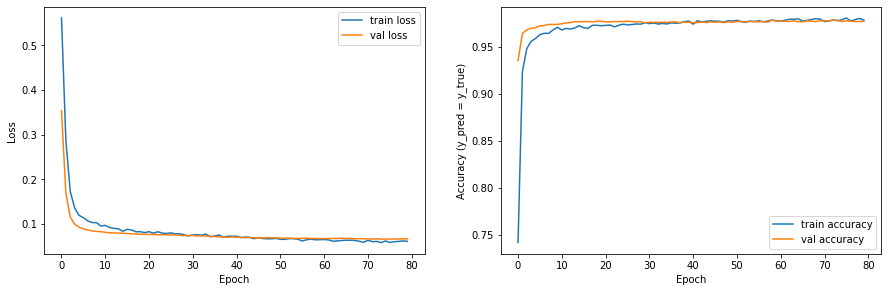

In [36]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [37]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

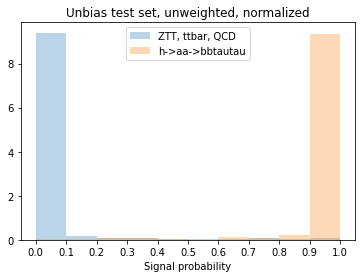

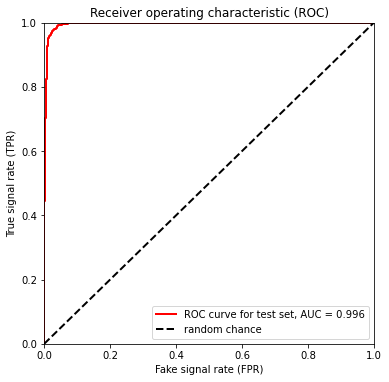

Test loss, test accuracy: [0.07131916203489705, 0.9735631942749023]


In [38]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Unbias test set, unweighted, normalized')
pyplot.xlabel('Signal probability')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

In [ ]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [39]:
from root_numpy import array2root

infolder = 'root_raw/et18_raw/'
outfolder = 'root_outputs/et18_outputs/'

inpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths)):
    inpaths[i] = infolder + inpaths[i]
    outpaths[i] = outfolder + outpaths[i]

allfiles = []
for i in range(len(inpaths)):
    allfiles.append(ROOT.RDataFrame('etau_tree', inpaths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_tt', mT_tt)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
print(len(allfiles))

46


## Data pre-processing

In [40]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])
    print(inpaths[i])

root_raw/et18_raw/DY.root
root_raw/et18_raw/DY1.root
root_raw/et18_raw/DY2.root
root_raw/et18_raw/DY3.root
root_raw/et18_raw/DY4.root
root_raw/et18_raw/GGHTT.root
root_raw/et18_raw/GGHWW.root
root_raw/et18_raw/GGZHLLTT.root
root_raw/et18_raw/GGZHNNTT.root
root_raw/et18_raw/GGZHQQTT.root
root_raw/et18_raw/GGZHWW.root
root_raw/et18_raw/ST_tW_antitop.root
root_raw/et18_raw/ST_tW_top.root
root_raw/et18_raw/ST_t_antitop.root
root_raw/et18_raw/ST_t_top.root
root_raw/et18_raw/TTTo2L2Nu.root
root_raw/et18_raw/TTToHadronic.root
root_raw/et18_raw/TTToSemiLeptonic.root
root_raw/et18_raw/VBFHTT.root
root_raw/et18_raw/VBFHWW.root
root_raw/et18_raw/VV2L2Nu.root
root_raw/et18_raw/WZ2L2Q.root
root_raw/et18_raw/WZ3LNu.root
root_raw/et18_raw/WminusHTT.root
root_raw/et18_raw/WminusHWW.root
root_raw/et18_raw/WplusHTT.root
root_raw/et18_raw/WplusHWW.root
root_raw/et18_raw/ZHTT.root
root_raw/et18_raw/ZHWW.root
root_raw/et18_raw/ZZ2L2Q.root
root_raw/et18_raw/ZZ4L.root
root_raw/et18_raw/data_obs.root
root_raw

## Feed to NN and write outputs to root files

In [41]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred_1b', np.float32)])
    array2root(y_pred, filename = outpaths[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths[i])

root_outputs/et18_outputs/DY.root
root_outputs/et18_outputs/DY1.root
root_outputs/et18_outputs/DY2.root
root_outputs/et18_outputs/DY3.root
root_outputs/et18_outputs/DY4.root
root_outputs/et18_outputs/GGHTT.root
root_outputs/et18_outputs/GGHWW.root
root_outputs/et18_outputs/GGZHLLTT.root
root_outputs/et18_outputs/GGZHNNTT.root
root_outputs/et18_outputs/GGZHQQTT.root
root_outputs/et18_outputs/GGZHWW.root
root_outputs/et18_outputs/ST_tW_antitop.root
root_outputs/et18_outputs/ST_tW_top.root
root_outputs/et18_outputs/ST_t_antitop.root
root_outputs/et18_outputs/ST_t_top.root
root_outputs/et18_outputs/TTTo2L2Nu.root
root_outputs/et18_outputs/TTToHadronic.root
root_outputs/et18_outputs/TTToSemiLeptonic.root
root_outputs/et18_outputs/VBFHTT.root
root_outputs/et18_outputs/VBFHWW.root
root_outputs/et18_outputs/VV2L2Nu.root
root_outputs/et18_outputs/WZ2L2Q.root
root_outputs/et18_outputs/WZ3LNu.root
root_outputs/et18_outputs/WminusHTT.root
root_outputs/et18_outputs/WminusHWW.root
root_outputs/et18_